<a href="https://colab.research.google.com/github/NikenKurniasari/Colorectal-Polyp-Detection/blob/main/YOLO11_model_for_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

##input data

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Cek isi direktori Google Drive
!ls /content/drive/MyDrive/scrypt/data


Mounted at /content/drive
 data_normal_RSUA_1gt_removed.zip
 data_normal_RSUA.zip
 data_RSUA_1gt_deleted.zip
 data_RSUA_1gt_removed.zip
 data_RSUA.zip
 dataset_all_capsesrs.zip
 dataset_all.zip
 final_dataset_cvcses.zip
 final_dataset.zip
 Kvasir-Capsule
 kvasir-seg_1gt_deleted.zip
 kvasir-seg_1_gt_removed.zip
 kvasir-seg.zip
 Kvasir-Sessile.zip
 output_AGC_HR_kvasir_seg_1gt_deleted.zip
 output_AGC_HR_kvasir_seg_1gt_removed.zip
 output_AGC_HR_normal_RSUA_1gt_removed.zip
 output_AGC_HR_RSUA_1gt_deleted.zip
 output_AGC_HR_RSUA_1gt_removed.zip
 output_AGC_kvasir_seg_1gt_deleted.zip
 output_AGC_kvasir_seg_1gt_removed.zip
 output_AGC_normal_RSUA_1gt_removed.zip
 output_AGC_RSUA_1gt_deleted.zip
 output_AGC_RSUA_1gt_removed.zip
 output_all_kvrs.zip
 output_all_sesrs.zip
 output_enhance_AGC_all_capsesrs.zip
 output_enhance_AGC_all_kvrs.zip
 output_enhance_AGC_all_sesrs.zip
 output_enhance_AGC_cvc-ses.zip
 output_enhance_AGC_kvasir-seg.zip
 output_enhance_AGC_normal_RSUA.zip
 output_enhance_AGC

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from IPython.display import Image, clear_output
import shutil
import random
from glob import glob
import numpy as np

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 45.4/112.6 GB disk)


#RSUA masuk

##function


In [ ]:
import pandas as pd
import os
import random
from glob import glob
import shutil


def split_dataset1(images_path, labels_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Memastikan rasio pembagian data totalnya 1.0
    # assert train_ratio + val_ratio + test_ratio == 1.0, "Total rasio train, val, dan test harus 1.0"

    # Membuat folder output untuk train, val, dan test
    os.makedirs(os.path.join(output_path, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'test'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'test'), exist_ok=True)

    # Dapatkan semua file gambar
    image_files = glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png"))

    # Pastikan ada file gambar
    assert len(image_files) > 0, "Tidak ada file gambar yang ditemukan."

    # Mengacak urutan file
    random.shuffle(image_files)

    # Hitung jumlah file untuk setiap set
    total_images = len(image_files)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)

    # Bagi dataset menjadi train, val, dan test
    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + val_count]
    test_images = image_files[train_count + val_count:]

    # Fungsi untuk menyalin file ke direktori tujuan dan mengonversi label
    def copy_files(image_set, subset):
        for img_file in image_set:
            # Salin file gambar
            shutil.copy(img_file, os.path.join(output_path, 'images', subset, os.path.basename(img_file)))

            # Salin file label dengan ekstensi CSV jika ada
            label_file_path = os.path.join(labels_path, os.path.splitext(os.path.basename(img_file))[0] + '.txt')
            if os.path.exists(label_file_path):
                #convert_csv_to_yolo(label_file_path, img_file, os.path.join(output_path, 'labels', subset))
                shutil.copy(label_file_path, os.path.join(output_path, 'labels', subset, os.path.basename(label_file_path)))
            else:
                print(f"Warning: Label tidak ditemukan untuk {img_file}")

    # Menyalin file ke direktori train, val, dan test
    copy_files(train_images, 'train')
    copy_files(val_images, 'val')
    copy_files(test_images, 'test')

    print(f"Dataset dibagi menjadi train ({len(train_images)}), val ({len(val_images)}), dan test ({len(test_images)})")


In [ ]:
import os
import random
from glob import glob
import shutil

def split_normal_dataset(images_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    images_dir = os.path.join(output_path, 'images')
    for subset in ['train', 'val', 'test']:
        folder_path = os.path.join(images_dir, subset)
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Folder '{folder_path}' tidak ditemukan. Pastikan struktur folder sudah benar.")

    # Ambil semua file gambar
    image_files = glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png"))
    assert len(image_files) > 0, "Tidak ada file gambar yang ditemukan."

    # Acak file
    random.shuffle(image_files)

    # Hitung jumlah file untuk tiap bagian
    total_images = len(image_files)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)

    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + val_count]
    test_images = image_files[train_count + val_count:]

    # Fungsi untuk menyalin gambar ke folder yang sesuai
    def copy_images(image_list, subset):
        for img_file in image_list:
            shutil.copy(img_file, os.path.join(images_dir, subset, os.path.basename(img_file)))

    # Salin gambar ke folder yang sudah ada
    copy_images(train_images, 'train')
    copy_images(val_images, 'val')
    copy_images(test_images, 'test')

    print(f"Dataset normal berhasil dibagi ke folder yang sudah ada: train ({len(train_images)}), val ({len(val_images)}), test ({len(test_images)})")


##asli

####kvasir

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/kvasir-seg_1_gt_removed.zip /content/

In [ ]:
!unzip /content/kvasir-seg_1_gt_removed.zip -d /content/kvasir-seg_1_gt_removed/


Archive:  /content/kvasir-seg_1_gt_removed.zip
   creating: /content/kvasir-seg_1_gt_removed/kvasir-seg/
   creating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/
   creating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/bboxes/
   creating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/images/
   creating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/masks/
  inflating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/kavsir_bboxes.json  
  inflating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/bboxes/kv-seg-226.txt  
  inflating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/bboxes/kv-seg-845.txt  
  inflating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/bboxes/kv-seg-950.txt  
  inflating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/bboxes/kv-seg-599.txt  
  inflating: /content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/bboxes/kv-seg-424.txt  
  inflating: /content/kvasir-seg_1_gt_removed/kvas

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/data_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/data_RSUA_1gt_removed.zip -d /content/data_RSUA_1gt_removed/


Archive:  /content/data_RSUA_1gt_removed.zip
   creating: /content/data_RSUA_1gt_removed/bboxes/
   creating: /content/data_RSUA_1gt_removed/images/
  inflating: /content/data_RSUA_1gt_removed/images/2_polyp-1-_202301260065C071.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/4_polyp-1-_202307170329C049.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/3_polyp-1-_asli_202405160871C094.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/4_polyp-1-_202406050908C006.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/4_polyp-1-_202409191126C010.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/3_polyp-1-_202306270295C062.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/polyp-1-_202305050217C020.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/6_polyp-1-_asli_202402190736C019.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/6_polyp-1-_202306270295C049.jpg  
  inflating: /content/data_RSUA_1gt_removed/images/2_polyp-1-_202411201276C112

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/data_normal_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/data_normal_RSUA_1gt_removed.zip -d /content/data_normal_RSUA_1gt_removed/


Archive:  /content/data_normal_RSUA_1gt_removed.zip
   creating: /content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/
   creating: /content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/Data Normal RSUA/
  inflating: /content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/Data Normal RSUA/202212150007C040.jpg  
  inflating: /content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/Data Normal RSUA/202212150007C042.jpg  
  inflating: /content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/Data Normal RSUA/202301260065C012.jpg  
  inflating: /content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/Data Normal RSUA/202301260065C014.jpg  
  inflating: /content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/Data Normal RSUA/202301260065C050.jpg  
  inflating: /content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/Data Normal RSUA/202302240107C026.jpg  
  inflating: /content/data_normal_RSUA_1gt_remove

In [ ]:
# Path ke folder output (misalnya, 'dataset_split' di direktori saat ini)
output_path = 'dataset_split_asli_kvrs_1gt_rem'

# Membuat folder output
os.makedirs(output_path, exist_ok=True)

In [ ]:
import pandas as pd
import os
import random
from glob import glob
import shutil


def split_dataset1(images_path, labels_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Memastikan rasio pembagian data totalnya 1.0
    # assert train_ratio + val_ratio + test_ratio == 1.0, "Total rasio train, val, dan test harus 1.0"

    # Membuat folder output untuk train, val, dan test
    os.makedirs(os.path.join(output_path, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'test'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'test'), exist_ok=True)

    # Dapatkan semua file gambar
    image_files = glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png"))

    # Pastikan ada file gambar
    assert len(image_files) > 0, "Tidak ada file gambar yang ditemukan."

    # Mengacak urutan file
    random.shuffle(image_files)

    # Hitung jumlah file untuk setiap set
    total_images = len(image_files)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)

    # Bagi dataset menjadi train, val, dan test
    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + val_count]
    test_images = image_files[train_count + val_count:]

    # Fungsi untuk menyalin file ke direktori tujuan dan mengonversi label
    def copy_files(image_set, subset):
        for img_file in image_set:
            # Salin file gambar
            shutil.copy(img_file, os.path.join(output_path, 'images', subset, os.path.basename(img_file)))

            # Salin file label dengan ekstensi CSV jika ada
            label_file_path = os.path.join(labels_path, os.path.splitext(os.path.basename(img_file))[0] + '.txt')
            if os.path.exists(label_file_path):
                #convert_csv_to_yolo(label_file_path, img_file, os.path.join(output_path, 'labels', subset))
                shutil.copy(label_file_path, os.path.join(output_path, 'labels', subset, os.path.basename(label_file_path)))
            else:
                print(f"Warning: Label tidak ditemukan untuk {img_file}")

    # Menyalin file ke direktori train, val, dan test
    copy_files(train_images, 'train')
    copy_files(val_images, 'val')
    copy_files(test_images, 'test')

    print(f"Dataset dibagi menjadi train ({len(train_images)}), val ({len(val_images)}), dan test ({len(test_images)})")


In [ ]:
import os
import glob

# Ganti path ke folder yang kamu maksud
folder_path = '/content/normal'

# Ambil semua file dalam folder
files = glob.glob(os.path.join(folder_path, '*'))

# Hapus satu per satu
for f in files:
    try:
        os.remove(f)
        print(f"Dihapus: {f}")
    except Exception as e:
        print(f"Gagal menghapus {f}. Error: {e}")


Dihapus: /content/normal/normalized_202402020707C059.jpg
Dihapus: /content/normal/normalized_202310190511C051.jpg
Dihapus: /content/normal/normalized_202307170329C033.jpg
Dihapus: /content/normal/normalized_202401220684C035.jpg
Dihapus: /content/normal/normalized_202402260753C055.jpg
Dihapus: /content/normal/normalized_202405200875C013.jpg
Dihapus: /content/normal/normalized_202310050474C023.jpg
Dihapus: /content/normal/normalized_202310030463C027.jpg
Dihapus: /content/normal/normalized_202301260065C012.jpg
Dihapus: /content/normal/normalized_202409191126C006.jpg
Dihapus: /content/normal/normalized_202407291035C086.jpg
Dihapus: /content/normal/normalized_202412041294C032.jpg
Dihapus: /content/normal/normalized_202412311348C043.jpg
Dihapus: /content/normal/normalized_202406280963C006.jpg
Dihapus: /content/normal/normalized_202406240950C046.jpg
Dihapus: /content/normal/normalized_202302240107C034.jpg
Dihapus: /content/normal/normalized_202405200875C070.jpg
Dihapus: /content/normal/normal

Saved: /content/normal/202402270755C036.jpg
Saved: /content/normal/202303210156C027.jpg
Saved: /content/normal/202402020707C073.jpg
Saved: /content/normal/202411041239C032.jpg
Saved: /content/normal/202312150626C024.jpg
Saved: /content/normal/202405160871C069.jpg
Saved: /content/normal/202406280963C006.jpg
Saved: /content/normal/202307170329C059.jpg
Saved: /content/normal/202310270531C034.jpg
Saved: /content/normal/202304100178C055.jpg
Saved: /content/normal/202410171198C037.jpg
Saved: /content/normal/202304100178C043.jpg
Saved: /content/normal/202412041294C032.jpg
Saved: /content/normal/202405130861C015.jpg
Saved: /content/normal/202312150625C014.jpg
Saved: /content/normal/202306220283C013.jpg
Saved: /content/normal/202401220684C035.jpg
Saved: /content/normal/202412311348C043.jpg
Saved: /content/normal/202301260065C014.jpg
Saved: /content/normal/202305120224C090.jpg
Saved: /content/normal/202305090219C059.jpg
Saved: /content/normal/202306190276C032.jpg
Saved: /content/normal/202312150

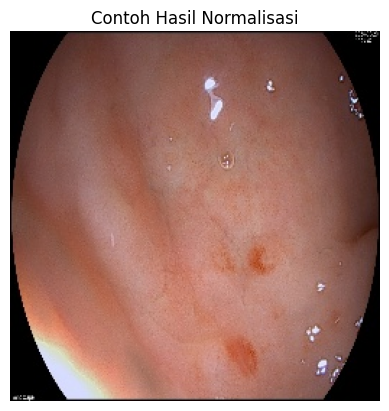

In [ ]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

# Path ke folder gambar normal
normal_images_dir = '/content/data_normal_RSUA_1gt_removed/data_normal_RSUA_1gt_removed/Data Normal RSUA'

# Ambil semua file gambar
image_files = glob.glob(os.path.join(normal_images_dir, "*.jpg")) + glob.glob(os.path.join(normal_images_dir, "*.png"))

# Fungsi normalisasi sederhana
def simple_normalization(img):
    img_float = img.astype(np.float32)
    norm_img = cv2.normalize(img_float, None, 0, 255, cv2.NORM_MINMAX)
    return norm_img.astype(np.uint8)

# Folder tujuan penyimpanan
save_dir = '/content/normal'
os.makedirs(save_dir, exist_ok=True)

# Looping ke semua gambar
for img_path in image_files:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error reading: {img_path}")
        continue

    resized_image = cv2.resize(image, (256, 256))
    normalized_image = simple_normalization(resized_image)

    # Simpan gambar hasil normalisasi
    base_name = os.path.basename(img_path)
    save_path = os.path.join(save_dir, f"{base_name}")
    cv2.imwrite(save_path, normalized_image)
    print(f"Saved: {save_path}")

# Opsional: tampilkan salah satu hasil untuk konfirmasi
sample_image = cv2.imread(save_path)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title("Contoh Hasil Normalisasi")
plt.axis('off')
plt.show()


In [ ]:
# Contoh penggunaan
images_path = '/content/normal'
images_path1 = '/content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/images'  # Path ke folder yang berisi semua file gambar
labels_path1 = '/content/kvasir-seg_1_gt_removed/kvasir-seg/Kvasir-SEG/bboxes'  # Path ke folder yang berisi semua file anotasi
images_path11 = '/content/data_RSUA_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path11 = '/content/data_RSUA_1gt_removed/bboxes'
output_path = '/content/dataset_split_asli_kvrs_1gt_rem'  # Path ke folder tujuan untuk dataset yang telah dipisah

split_dataset1(images_path1, labels_path1, output_path)
split_dataset1(images_path11, labels_path11, output_path)
split_normal_dataset (images_path, output_path)

Dataset dibagi menjadi train (665), val (190), dan test (95)
Dataset dibagi menjadi train (83), val (23), dan test (13)
Dataset normal berhasil dibagi ke folder yang sudah ada: train (83), val (23), test (13)


In [ ]:
# Inisialisasi counter
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_asli_kvrs_1gt_rem/images/train'):
    if file_name.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_asli_kvrs_1gt_rem/labels/train'):
    if file_name.endswith(('.txt')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")

Jumlah file gambar dalam folder: 831
Jumlah file gambar dalam folder: 748


In [ ]:
import yaml

# Data untuk file YAML
dataset = {
    'train': '/content/dataset_split_asli_kvrs_1gt_rem/images/train',  # Ubah sesuai path ke folder gambar train Anda
    'val': '/content/dataset_split_asli_kvrs_1gt_rem/images/val',      # Ubah sesuai path
    'test': '/content/dataset_split_asli_kvrs_1gt_rem/images/test',
    'nc': 1,  # Jumlah kelas
    'names': ['polyp']  # Nama-nama kelas
}

# Path untuk menyimpan file YAML
yaml_file = '/content/dataset1.yaml'

# Menulis file YAML
with open(yaml_file, 'w') as file:
    yaml.dump(dataset, file)

print(f"File YAML dataset berhasil dibuat: {yaml_file}")


File YAML dataset berhasil dibuat: /content/dataset1.yaml


###model

In [ ]:
# Load a model
model2 = YOLO("yolo11s.pt")

# Train the model
train_results = model2.train(
    data="/content/dataset1.yaml",  # path to dataset YAML
    epochs=100,             # max epoch
    imgsz=256,
    batch=8,
    device=0,
    project="/content/runs/detect",  # direktori utama penyimpanan
    name="train",                   # subfolder hasil training
    exist_ok=True                    # tidak error jika folder sudah ada
    #patience=10,            # Early stopping if no improvement in 10 epochs
    #verbose=True
)

# Evaluate model performance on the validation set
#metrics = model.val()

100%|██████████| 18.4M/18.4M [00:00<00:00, 347MB/s]

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset1.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=/content/runs/detect, rect=False, resume=False, retina_masks=Fa

100%|██████████| 755k/755k [00:00<00:00, 98.4MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

YOLO11s summary: 181 layers, 9,428,179 parameters, 9,428,163 gradients, 21.5 GFLOPs

Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 408MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1023.7±404.9 MB/s, size: 24.7 KB)


train: Scanning /content/dataset_split_asli_kvrs_1gt_rem/labels/train... 748 images, 83 backgrounds, 0 corrupt: 100%|██████████| 831/831 [00:00<00:00, 2659.51it/s]

train: New cache created: /content/dataset_split_asli_kvrs_1gt_rem/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 376.7±236.0 MB/s, size: 19.6 KB)


val: Scanning /content/dataset_split_asli_kvrs_1gt_rem/labels/val... 213 images, 23 backgrounds, 0 corrupt: 100%|██████████| 236/236 [00:00<00:00, 2128.05it/s]

val: New cache created: /content/dataset_split_asli_kvrs_1gt_rem/labels/val.cache


Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.568G      1.253      1.855      1.418         10        256: 100%|██████████| 104/104 [00:13<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.12it/s]

                   all        236        216     0.0134      0.741     0.0128     0.0068



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.643G      1.352      1.593      1.462         15        256: 100%|██████████| 104/104 [00:12<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.04it/s]

                   all        236        216      0.661       0.56      0.609      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      0.68G      1.428      1.638      1.496         17        256: 100%|██████████| 104/104 [00:11<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.14it/s]

                   all        236        216        0.3       0.19      0.163     0.0775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.752G      1.409      1.545      1.488         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.02it/s]

                   all        236        216      0.668      0.602      0.638      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.791G      1.381      1.473      1.467         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.02it/s]

                   all        236        216      0.701      0.528      0.581      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.861G      1.366        1.5      1.473         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.96it/s]

                   all        236        216      0.699      0.551      0.626      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.902G      1.347      1.393      1.459         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.94it/s]

                   all        236        216      0.663      0.634      0.684      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.941G      1.314      1.417      1.448         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]

                   all        236        216       0.59      0.574      0.583      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         1G      1.279      1.354      1.395         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]

                   all        236        216      0.654      0.574      0.622      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.09G      1.233      1.335      1.363          9        256: 100%|██████████| 104/104 [00:10<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.19it/s]

                   all        236        216      0.737       0.66      0.708       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.13G      1.234      1.306      1.393         13        256: 100%|██████████| 104/104 [00:10<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.25it/s]

                   all        236        216      0.673      0.574      0.617      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.17G      1.217      1.278      1.387          6        256: 100%|██████████| 104/104 [00:10<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]

                   all        236        216      0.742      0.707      0.772      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.24G      1.203      1.288       1.36          8        256: 100%|██████████| 104/104 [00:10<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.15it/s]

                   all        236        216      0.758      0.685      0.734      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.28G      1.172      1.253      1.345         15        256: 100%|██████████| 104/104 [00:10<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]

                   all        236        216      0.735      0.722      0.759        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.34G      1.141      1.208      1.322         13        256: 100%|██████████| 104/104 [00:10<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


                   all        236        216       0.79      0.676      0.777      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.38G      1.164      1.174      1.337          7        256: 100%|██████████| 104/104 [00:10<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.83it/s]

                   all        236        216      0.798      0.731      0.786      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.44G      1.191      1.196      1.366         10        256: 100%|██████████| 104/104 [00:10<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.97it/s]

                   all        236        216      0.756      0.703      0.772      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       1.5G      1.138      1.134      1.335          6        256: 100%|██████████| 104/104 [00:11<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.18it/s]

                   all        236        216      0.829      0.625       0.77      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.55G      1.155      1.211      1.345         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.08it/s]

                   all        236        216      0.751      0.698      0.763      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.61G      1.128       1.13      1.305         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.11it/s]

                   all        236        216      0.795      0.718      0.792      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.65G      1.119      1.128      1.315         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.07it/s]

                   all        236        216      0.748      0.759      0.792      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.71G      1.097      1.107      1.294         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all        236        216      0.745      0.718      0.775      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       1.8G      1.109      1.141      1.313         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.32it/s]

                   all        236        216      0.778      0.778       0.82      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.84G      1.082      1.071       1.29         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.20it/s]

                   all        236        216      0.817      0.806      0.844      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.88G      1.095      1.107      1.286          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.94it/s]

                   all        236        216      0.745      0.743       0.78      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.94G       1.05      1.042       1.27         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.20it/s]

                   all        236        216      0.763      0.801       0.82      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.98G      1.043      1.035       1.27         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all        236        216      0.786      0.718      0.802      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.05G      1.052      1.052      1.288         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all        236        216        0.8      0.773      0.829      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.09G      1.037      1.048      1.264         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.02it/s]

                   all        236        216      0.841      0.778      0.846       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.16G      1.047      1.058      1.279         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

                   all        236        216      0.772      0.739      0.807      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.2G      1.012      1.005       1.24         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.36it/s]

                   all        236        216      0.848      0.773      0.863      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.27G      1.052      1.013      1.291         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.34it/s]

                   all        236        216      0.828      0.787      0.839      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.31G      1.009      1.013      1.248         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.17it/s]

                   all        236        216      0.808      0.796      0.847      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.37G      1.023     0.9891      1.247         17        256: 100%|██████████| 104/104 [00:11<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.16it/s]

                   all        236        216      0.859      0.796       0.85      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.44G      1.012     0.9741      1.257         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.47it/s]

                   all        236        216      0.785      0.843      0.869      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.48G      1.019     0.9529      1.249         14        256: 100%|██████████| 104/104 [00:10<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]

                   all        236        216      0.841      0.806      0.865      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.55G      1.036      1.004      1.265         13        256: 100%|██████████| 104/104 [00:10<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]

                   all        236        216      0.829      0.742      0.828      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.59G     0.9692     0.9566      1.224         11        256: 100%|██████████| 104/104 [00:10<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.65it/s]

                   all        236        216      0.881      0.773      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.63G     0.9742     0.9395      1.238         12        256: 100%|██████████| 104/104 [00:10<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]

                   all        236        216      0.867       0.81      0.858      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.69G     0.9808     0.9131      1.232         12        256: 100%|██████████| 104/104 [00:10<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]

                   all        236        216      0.862      0.787      0.876      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.78G     0.9389     0.9087       1.21          9        256: 100%|██████████| 104/104 [00:10<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.19it/s]

                   all        236        216      0.873      0.755      0.846      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.81G     0.9462     0.9079      1.208         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.17it/s]

                   all        236        216      0.894      0.777      0.871      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.86G     0.9764     0.9354      1.229         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.20it/s]

                   all        236        216      0.834       0.79      0.867      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.93G     0.9421     0.8501      1.202         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]

                   all        236        216      0.832      0.804      0.849      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.97G     0.9784     0.9137      1.235         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.90it/s]

                   all        236        216      0.838      0.812      0.882      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.04G     0.9297     0.8935      1.202         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.21it/s]

                   all        236        216      0.827       0.84      0.885      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.08G     0.9479     0.8843      1.211         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all        236        216      0.925      0.764      0.883      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.14G     0.9547     0.8702      1.227         19        256: 100%|██████████| 104/104 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.99it/s]

                   all        236        216      0.838      0.836      0.882      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.2G     0.9581     0.8759      1.215         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.99it/s]

                   all        236        216      0.844      0.806      0.885      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.28G      0.905     0.8444      1.179         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.64it/s]

                   all        236        216       0.89      0.821      0.894      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.35G     0.9557     0.8954      1.234         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.09it/s]

                   all        236        216      0.881      0.819      0.895      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.39G     0.9217     0.8706      1.199          8        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]

                   all        236        216      0.839       0.82      0.876      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.43G     0.9135      0.858      1.194         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.83it/s]

                   all        236        216      0.816      0.787      0.867      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.47G     0.9071     0.8318      1.192         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.97it/s]

                   all        236        216      0.883      0.787      0.872      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.56G     0.9148     0.8421      1.191          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.98it/s]

                   all        236        216      0.784      0.792      0.847       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       3.6G     0.9192     0.8228      1.202         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

                   all        236        216      0.874      0.792      0.889       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.64G     0.9078     0.8164        1.2         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.08it/s]

                   all        236        216      0.875      0.824      0.893      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.68G      0.894     0.8182      1.187         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.03it/s]

                   all        236        216      0.882      0.824      0.888      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.75G     0.8947     0.7696      1.173         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.82it/s]

                   all        236        216      0.905      0.791      0.892      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.79G     0.8678     0.8059      1.167         10        256: 100%|██████████| 104/104 [00:12<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.91it/s]

                   all        236        216      0.915      0.782       0.89      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.85G     0.9148     0.7842      1.184         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.68it/s]

                   all        236        216      0.893       0.81      0.898      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.89G     0.8577      0.779       1.16         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.44it/s]

                   all        236        216      0.887      0.802      0.889      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.96G     0.8514     0.7721      1.164         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.45it/s]

                   all        236        216      0.917      0.847      0.898      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         4G     0.8637     0.7603      1.176         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.83it/s]

                   all        236        216      0.887      0.832      0.897      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.07G     0.8212     0.7439      1.137         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.06it/s]

                   all        236        216      0.896        0.8      0.893      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.13G     0.8364     0.7649      1.156         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.16it/s]

                   all        236        216      0.887      0.852      0.903      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.21G     0.8394     0.7189      1.136         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.25it/s]

                   all        236        216      0.878      0.792      0.893       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.26G     0.8377     0.7322      1.153          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.87it/s]

                   all        236        216      0.872      0.856      0.909      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.29G      0.837      0.728       1.16         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.09it/s]

                   all        236        216      0.892      0.878      0.905      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.37G     0.8361     0.6963      1.151         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.18it/s]

                   all        236        216       0.87      0.875      0.903      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.41G     0.8371     0.7344      1.156         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.11it/s]

                   all        236        216      0.843      0.884      0.908      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.45G     0.8173     0.7233      1.134         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.79it/s]

                   all        236        216      0.917      0.856      0.912        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.52G     0.8277     0.7043      1.148         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.77it/s]

                   all        236        216      0.921      0.859      0.914      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.56G     0.7962     0.6691      1.124         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.22it/s]

                   all        236        216      0.909      0.837      0.915      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.62G     0.8091     0.7067      1.124         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all        236        216      0.879      0.884      0.898      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.66G     0.8143     0.7182      1.147         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.16it/s]

                   all        236        216      0.886       0.83      0.897      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.73G     0.8078       0.69      1.133          8        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.63it/s]

                   all        236        216      0.921       0.87      0.917      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.81G     0.8077     0.6808      1.137         17        256: 100%|██████████| 104/104 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.27it/s]

                   all        236        216      0.871      0.852        0.9      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.85G     0.7946     0.6684      1.127         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.12it/s]

                   all        236        216      0.893      0.833      0.897      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.89G     0.8077     0.6754      1.145         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.02it/s]

                   all        236        216      0.916      0.858      0.908      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.93G     0.7895     0.6802      1.131          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.11it/s]

                   all        236        216      0.903      0.856      0.904      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.99G     0.7738      0.636      1.109         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.29it/s]

                   all        236        216      0.929      0.845      0.904      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.05G     0.7643     0.6262      1.109         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.16it/s]

                   all        236        216      0.917      0.861      0.915      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.11G     0.7589     0.6443      1.118         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.20it/s]

                   all        236        216      0.882      0.868      0.911      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       5.2G     0.7705     0.6529      1.109         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.13it/s]

                   all        236        216       0.91      0.838      0.909      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.24G     0.7615     0.6465      1.103         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.13it/s]

                   all        236        216      0.907      0.843       0.91      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.31G     0.7432     0.6206      1.092         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.04it/s]

                   all        236        216      0.835       0.88      0.908      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.35G     0.7377      0.614        1.1         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.89it/s]

                   all        236        216      0.867      0.875      0.906      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.39G     0.7384     0.6219      1.093          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.19it/s]

                   all        236        216      0.891       0.88      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.47G     0.7486     0.6181      1.114         19        256: 100%|██████████| 104/104 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.17it/s]

                   all        236        216        0.9      0.874      0.922       0.73


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.51G      0.608     0.4777      0.996          6        256: 100%|██████████| 104/104 [00:12<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.92it/s]

                   all        236        216      0.906      0.843      0.897      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.55G     0.5831     0.4414     0.9829          7        256: 100%|██████████| 104/104 [00:11<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]

                   all        236        216      0.901      0.861      0.907      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.59G     0.5765     0.4197     0.9744          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.80it/s]

                   all        236        216      0.874      0.897      0.911      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.66G      0.586     0.4197     0.9744          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.91it/s]

                   all        236        216        0.9      0.875      0.912      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       5.7G     0.5734     0.4073     0.9683          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all        236        216      0.888      0.884      0.912      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.76G     0.5542     0.4072     0.9638          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.04it/s]

                   all        236        216      0.907      0.875      0.909       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.82G     0.5752     0.4119     0.9794          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all        236        216      0.913      0.873      0.909      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.88G     0.5602     0.3958     0.9605          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.05it/s]

                   all        236        216      0.933      0.847      0.912      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.92G     0.5552     0.3981     0.9592          5        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.09it/s]

                   all        236        216       0.91      0.838      0.908      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.01G     0.5525     0.4002     0.9579          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.07it/s]

                   all        236        216      0.877      0.894      0.912      0.732



100 epochs completed in 0.370 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 19.1MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


                   all        236        216      0.892       0.88      0.923      0.733
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/runs/detect/train


In [ ]:
import pandas as pd

# Path ke file hasil training YOLOv8
results_path = "/content/runs/detect/train/results.csv"

# Baca file hasil training
df = pd.read_csv(results_path)

# Hitung F1-score dari precision dan recall
df['f1_score'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])


# Simpan ke file baru CSV (bisa ditimpa file lama juga jika mau)
f1_output_path = "/content/runs/detect/train/results_with_f1.csv"
df.to_csv(f1_output_path, index=False)

print("F1-score berhasil disimpan ke:", f1_output_path)


F1-score berhasil disimpan ke: /content/runs/detect/train/results_with_f1.csv


/content/runs/detect/train


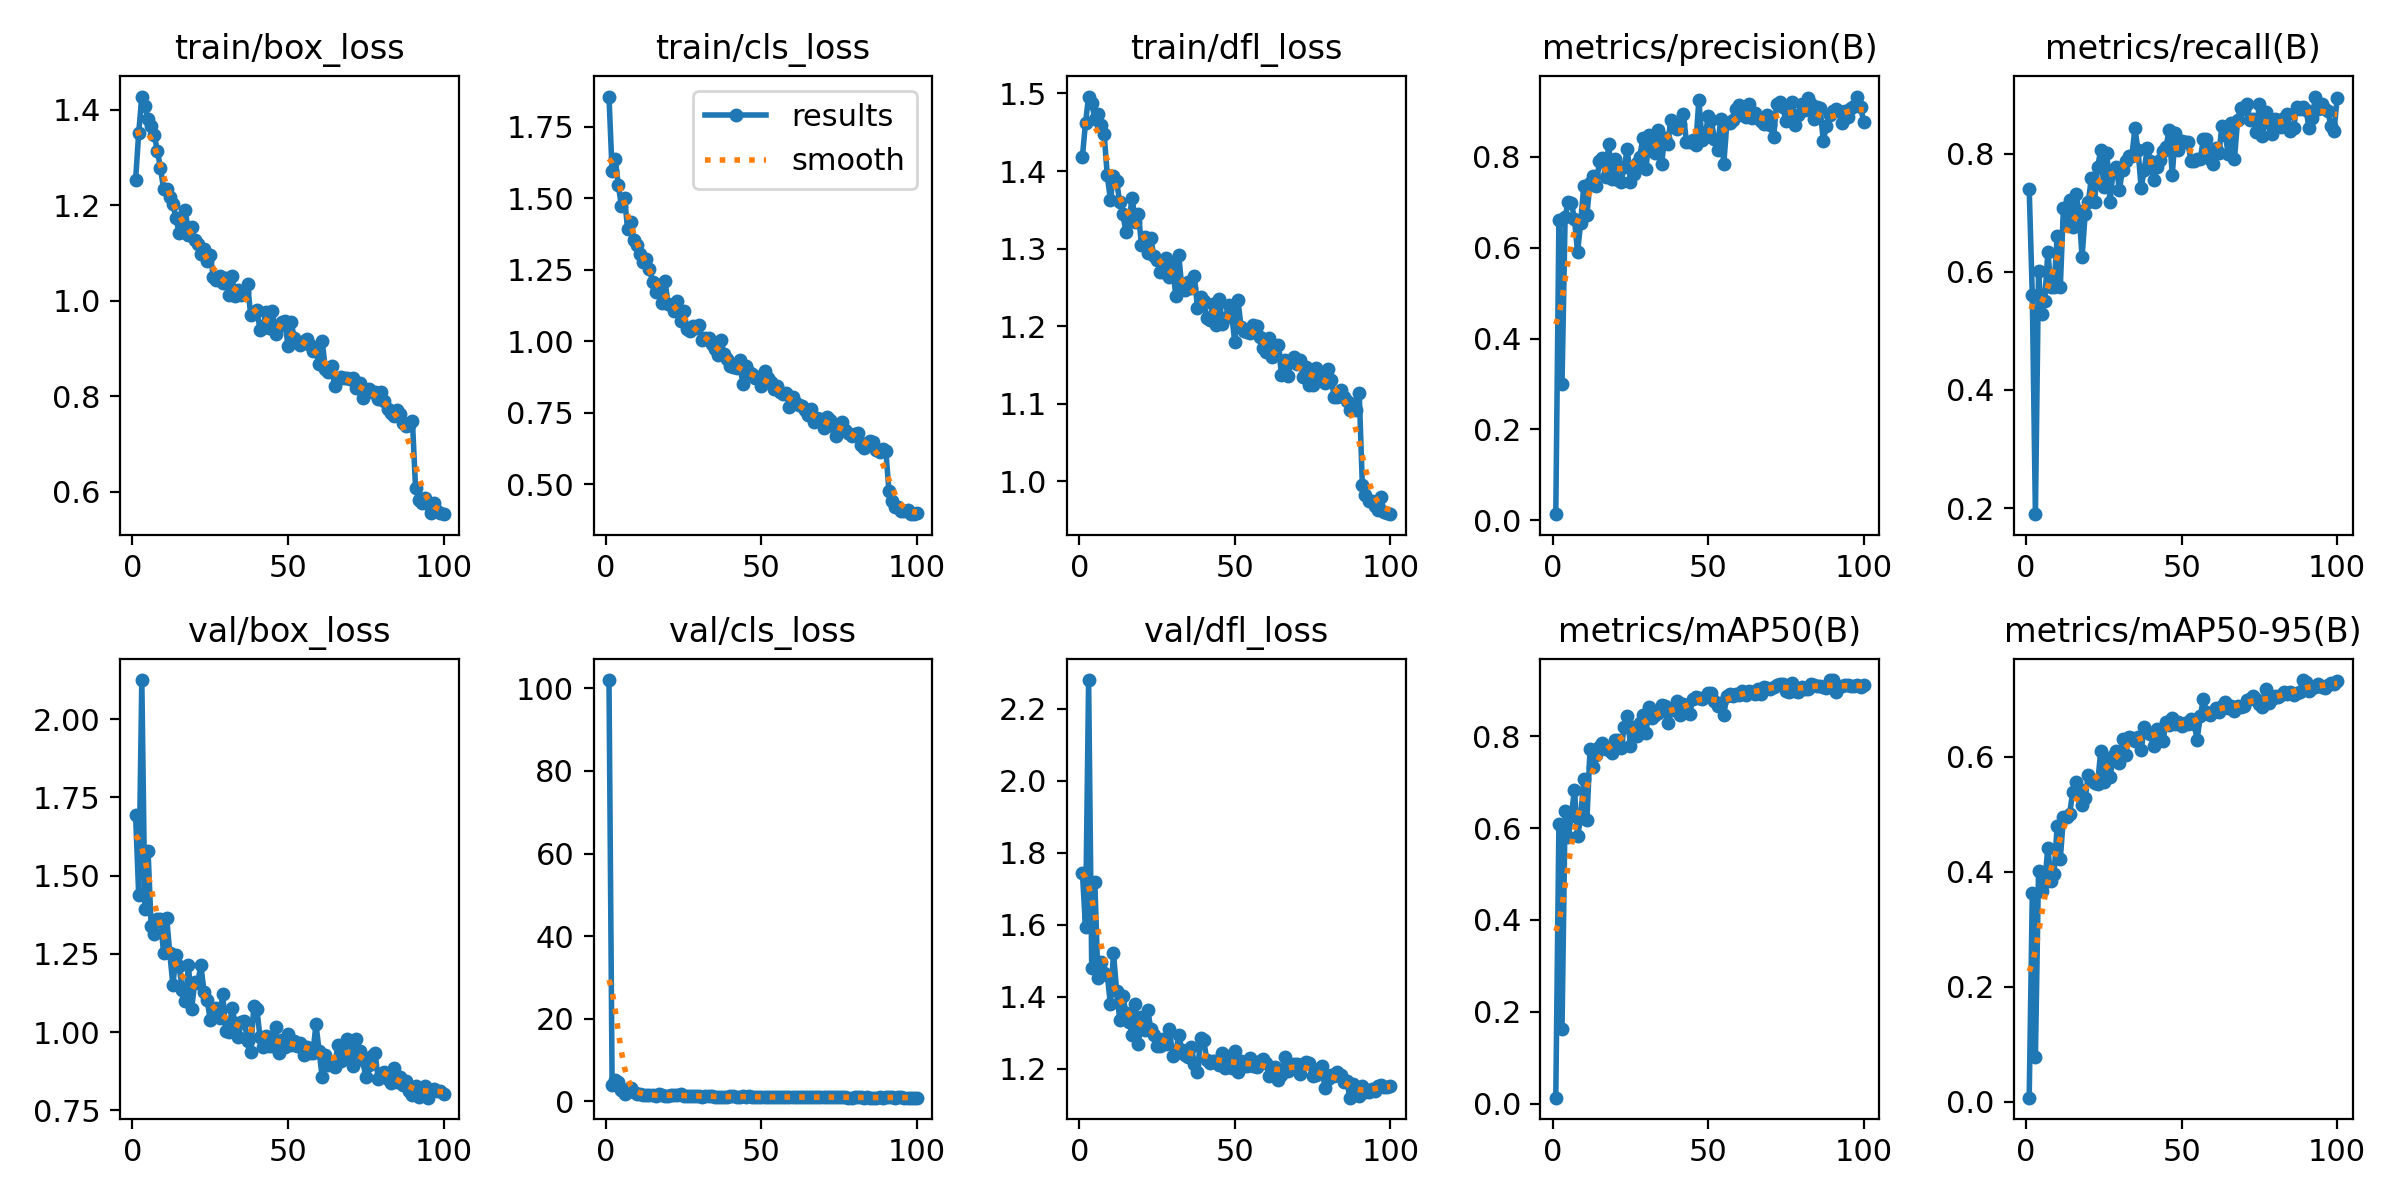

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/results.png', width=600)

/content/runs/detect/train


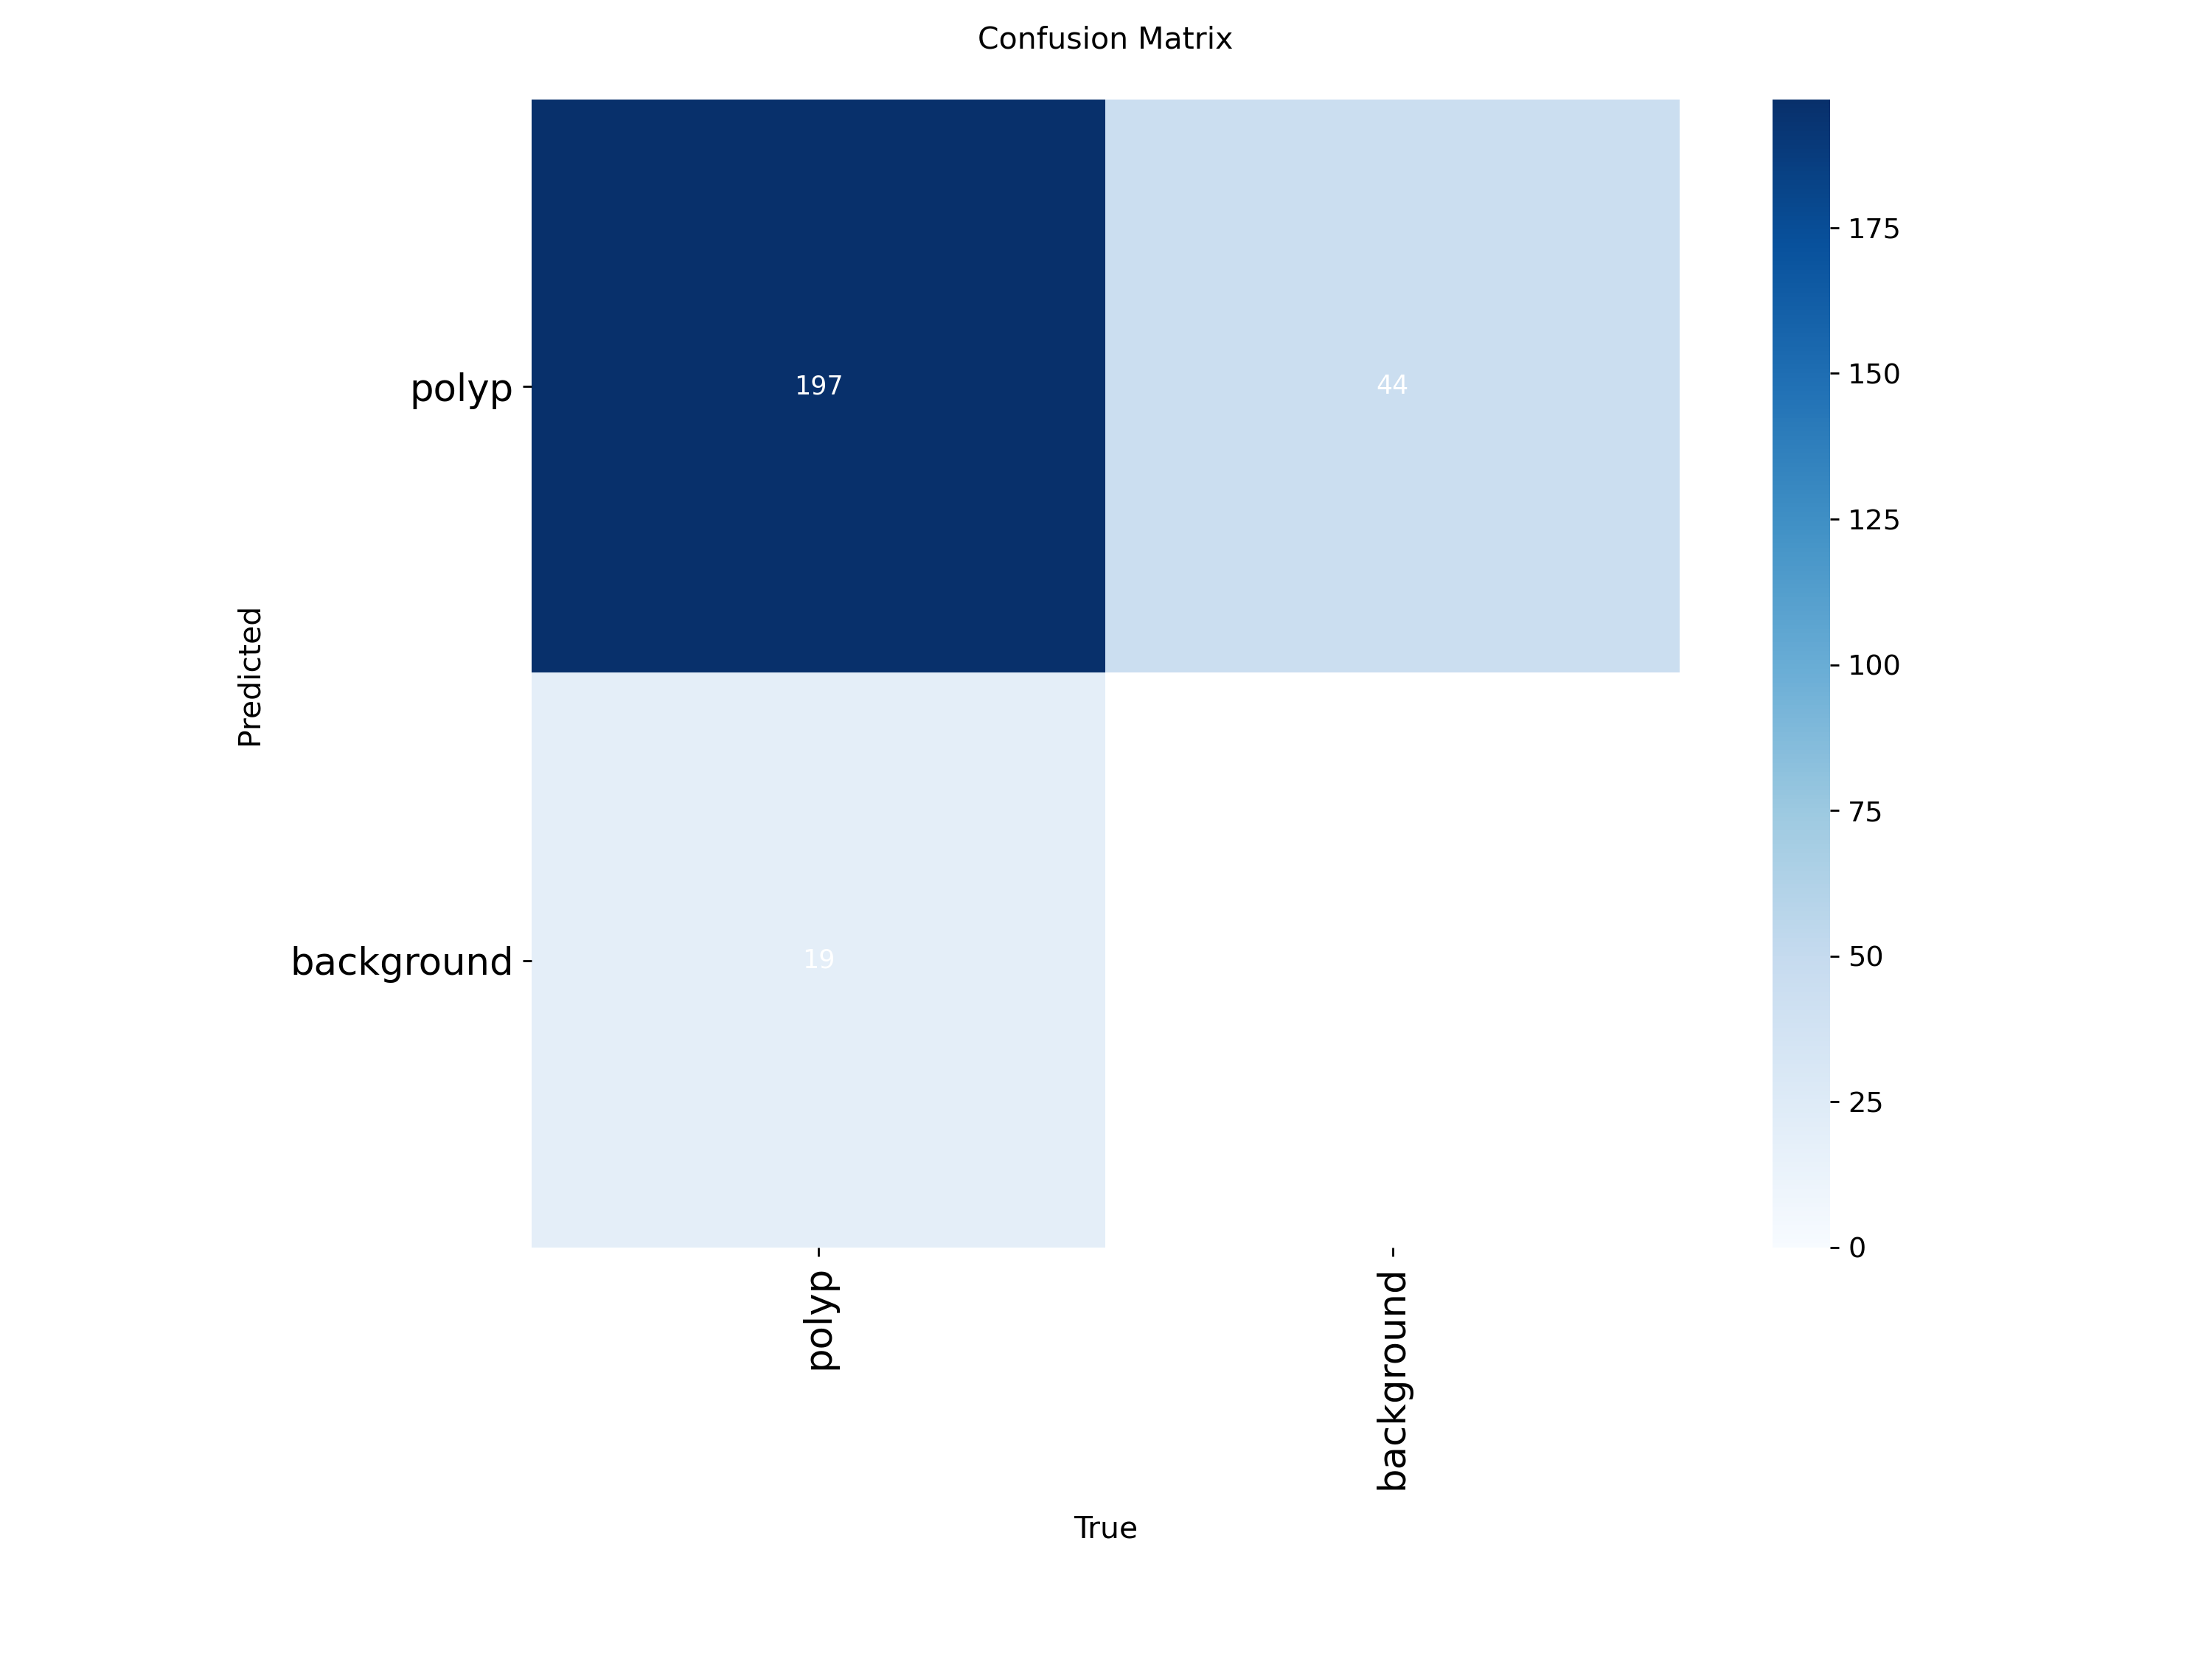

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

/content/runs/detect/train


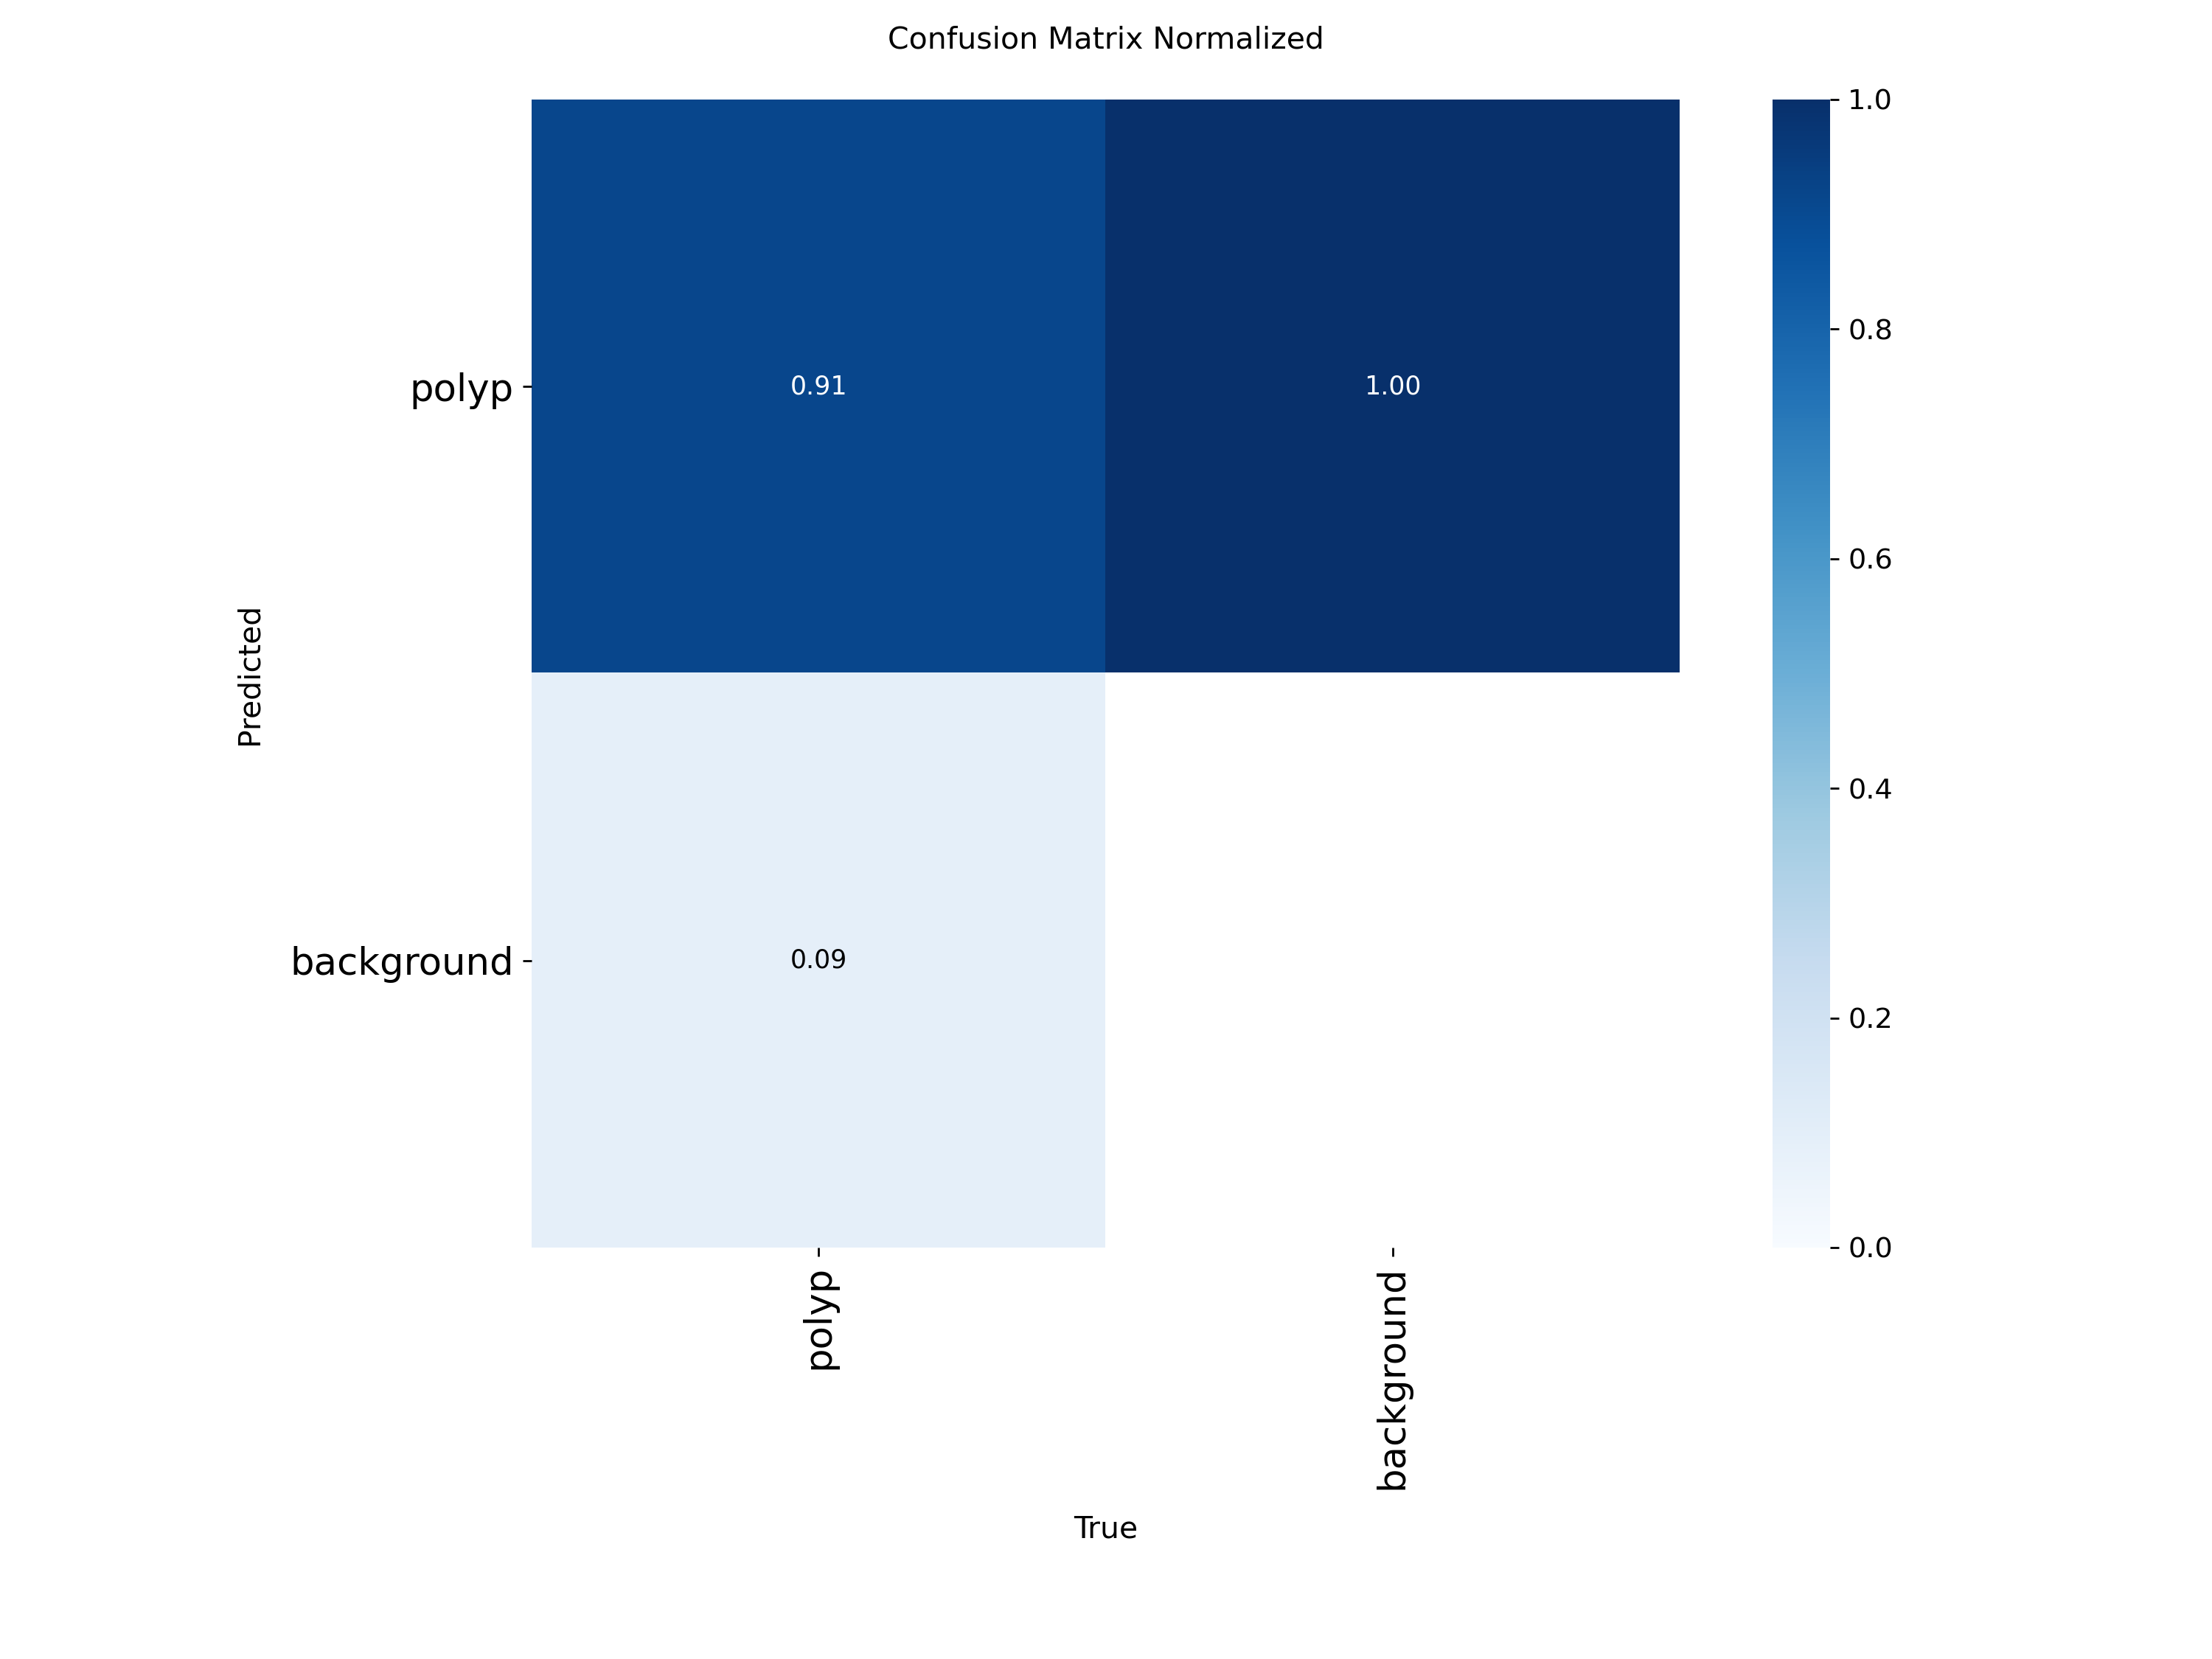

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/confusion_matrix_normalized.png', width=600)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/dataset1.yaml project=/content/runs/detect name=val   conf=0.5 iou=0.5

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1274.0±351.8 MB/s, size: 24.8 KB)
val: Scanning /content/dataset_split_asli_kvrs_1gt_rem/labels/val.cache... 213 images, 23 backgrounds, 0 corrupt: 100% 236/236 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 15/15 [00:01<00:00,  8.92it/s]
                   all        236        216      0.918       0.88      0.921      0.761
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


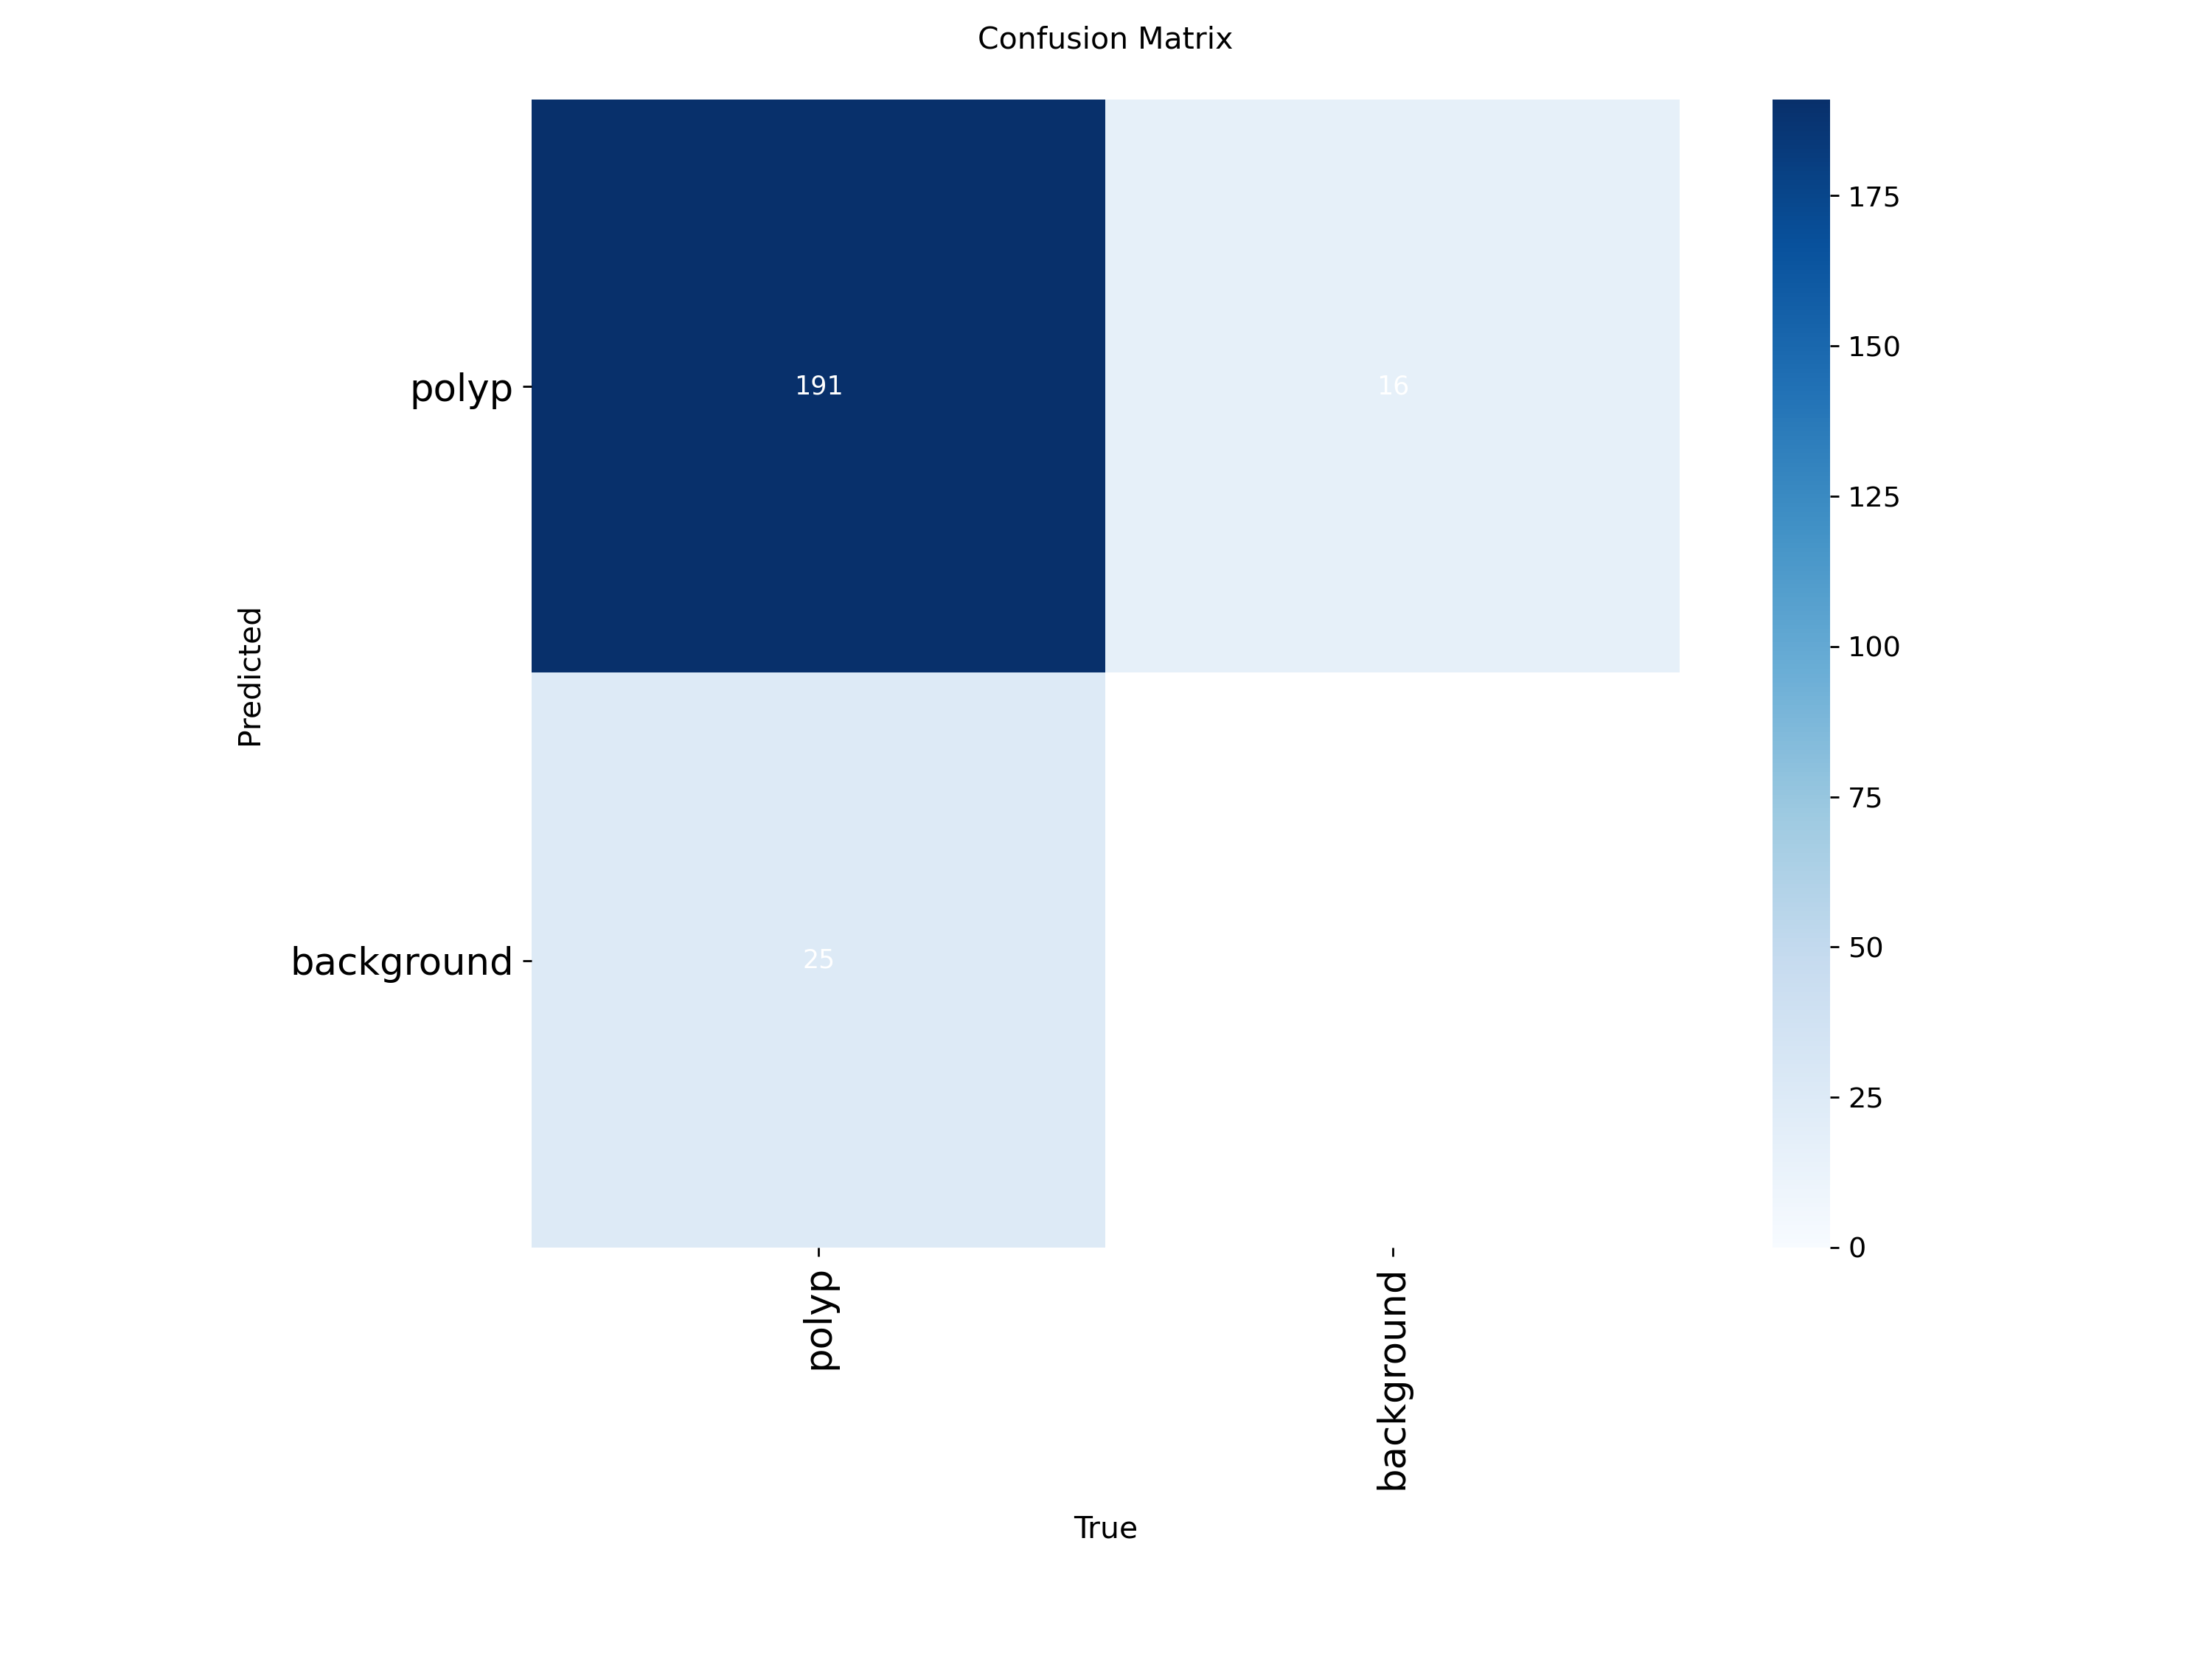

In [ ]:
Image(filename=f'/content/runs/detect/val/confusion_matrix.png', width=600)

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.5 iou=0.5 source=/content/dataset_split_asli_kvrs_1gt_rem/images/test project=/content/runs/detect name=predict save=True save_txt=True save_conf=True

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/121 /content/dataset_split_asli_kvrs_1gt_rem/images/test/202303210154C036.jpg: 256x256 (no detections), 11.3ms
image 2/121 /content/dataset_split_asli_kvrs_1gt_rem/images/test/202305050217C032.jpg: 256x256 (no detections), 8.3ms
image 3/121 /content/dataset_split_asli_kvrs_1gt_rem/images/test/202309190441C039.jpg: 256x256 (no detections), 7.8ms
image 4/121 /content/dataset_split_asli_kvrs_1gt_rem/images/test/202310270531C028.jpg: 256x256 (no detections), 7.8ms
image 5/121 /content/dataset_split_asli_kvrs_1gt_rem/images/test/202401220684C035.jpg: 256x256 (no detections), 7.6ms
image 6/121 /content/dataset_split_asli_kvrs_1gt_rem/images/test/202402120724C016.jpg: 256x256 (no detections), 8.2ms
image 7/121 /content/dataset_split_asli_kvrs_1gt_rem/images/test/202402120724C055.jpg: 256x256 (no detections), 8.8ms
image

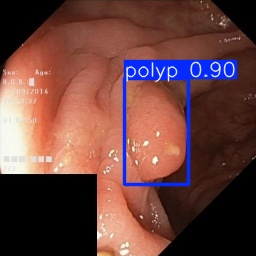

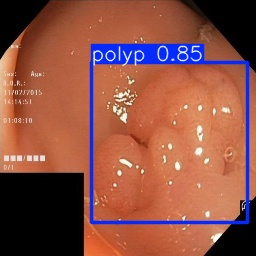

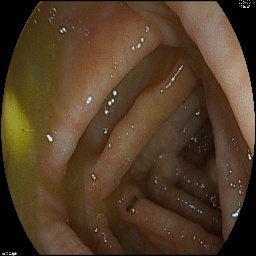

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'/content/runs/detect/predict'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=300))
    print("\n")

####test

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from collections import defaultdict

def compute_iou(box1, box2):
    """Menghitung IoU antara dua bounding box: [x_center, y_center, w, h]"""
    def to_corners(box):
        x, y, w, h = box
        return [x - w/2, y - h/2, x + w/2, y + h/2]

    box1 = to_corners(box1)
    box2 = to_corners(box2)

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append((cls, bbox))
    return labels

def evaluate(pred_dir, gt_dir, iou_threshold=0.5):
    predictions = []
    for pred_file in glob.glob(f"{pred_dir}/*.txt"):
        filename = os.path.basename(pred_file)
        image_id = filename.replace('.txt', '')
        gt_file = os.path.join(gt_dir, filename)

        pred_labels = []
        with open(pred_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                bbox = list(map(float, parts[1:5]))
                conf = float(parts[5]) if len(parts) > 5 else 1.0  # asumsikan confidence = 1.0 jika tidak tersedia
                pred_labels.append((image_id, cls, conf, bbox))
        predictions.extend(pred_labels)

    predictions.sort(key=lambda x: x[2], reverse=True)  # sort by confidence
    class_gt_counts = defaultdict(int)
    gt_boxes = defaultdict(list)

    for gt_file in glob.glob(f"{gt_dir}/*.txt"):
        image_id = os.path.basename(gt_file).replace('.txt', '')
        for cls, bbox in load_labels(gt_file):
            gt_boxes[(image_id, cls)].append({'bbox': bbox, 'used': False})
            class_gt_counts[cls] += 1

    stats = []
    acc_tp = 0
    acc_fp = 0

    for image_id, cls, conf, pred_box in predictions:
        matched = False
        candidates = gt_boxes.get((image_id, cls), [])
        for gt in candidates:
            if not gt['used']:
                iou = compute_iou(pred_box, gt['bbox'])
                if iou >= iou_threshold:
                    gt['used'] = True
                    matched = True
                    break

        tp = 1 if matched else 0
        fp = 0 if matched else 1

        acc_tp += tp
        acc_fp += fp

        precision = acc_tp / (acc_tp + acc_fp) if (acc_tp + acc_fp) > 0 else 0
        recall = acc_tp / sum(class_gt_counts.values()) if sum(class_gt_counts.values()) > 0 else 0

        stats.append([image_id, cls, conf, tp, fp, acc_tp, acc_fp, precision, recall])

    df = pd.DataFrame(stats, columns=["Image", "Class", "Confidence", "TP", "FP", "Acc TP", "Acc FP", "Precision", "Recall"])
    return df

# Contoh pemanggilan:
pred_dir = '/content/runs/detect/predict/labels'
gt_dir = '/content/dataset_split_asli_kvrs_1gt_rem/labels/test'
df_metrics = evaluate(pred_dir, gt_dir)
df_metrics.to_csv("/content/detection_metrics_asli_1gt_rem.csv", index=False)


Total Ground Truth: 108
Final Precision: 0.8835
Final Recall: 0.8426
Final F1-Score: 0.8626


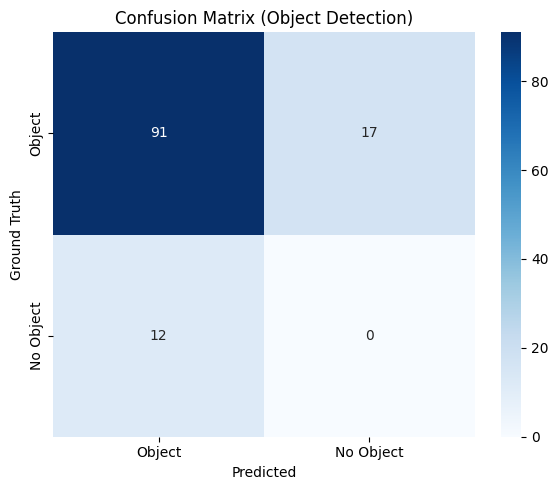

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def count_total_groundtruth(gt_dir):
    """
    Menghitung total jumlah bounding box (ground truth) dari folder label YOLO.

    Args:
        gt_dir (str): Path ke folder label ground truth (YOLO format)

    Returns:
        int: Total jumlah ground truth bounding box
    """
    total_gt = 0
    for file_name in os.listdir(gt_dir):
        if file_name.endswith('.txt'):
            file_path = os.path.join(gt_dir, file_name)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_gt += len(lines)
    return total_gt
gt_dir = '/content/dataset_split_asli_kvrs_1gt_rem/labels/test'
total_gt = count_total_groundtruth(gt_dir)
print(f"Total Ground Truth: {total_gt}")

def compute_final_metrics(df: pd.DataFrame, total_gt: int):
    """
    Menghitung TP, FP, FN, Precision, Recall, dan F1-score dari DataFrame hasil evaluasi.

    Args:
        df (pd.DataFrame): DataFrame berisi kolom ['TP', 'FP'] untuk masing-masing prediksi
        total_gt (int): Jumlah total ground truth (box sebenarnya)

    Returns:
        dict: Confusion matrix dan metrik evaluasi
    """
    tp = df['TP'].sum()
    fp = df['FP'].sum()
    fn = total_gt - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }
# Misalnya 'eval_df' adalah DataFrame berisi kolom ['TP', 'FP']
final_result = compute_final_metrics(df_metrics, total_gt)

print(f"Final Precision: {final_result['Precision']}")
print(f"Final Recall: {final_result['Recall']}")
print(f"Final F1-Score: {final_result['F1 Score']}")

tp = final_result['True Positive (TP)']
fp = final_result['False Positive (FP)']
fn = final_result['False Negative (FN)']
tn = 0  # TN tidak dihitung dalam object detection
# Plot confusion matrix
conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

labels = ['Object', 'No Object']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix (Object Detection)')
plt.tight_layout()
plt.show()

##AGC-HR

####kvasir

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_AGC_HR_kvasir_seg_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_AGC_HR_kvasir_seg_1gt_removed.zip -d /content/output_AGC_HR_kvasir_seg_1gt_removed/


Archive:  /content/output_AGC_HR_kvasir_seg_1gt_removed.zip
   creating: /content/output_AGC_HR_kvasir_seg_1gt_removed/bboxes/
   creating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-347.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-204.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-911.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-79.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-709.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-870.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-919.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-646.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/images/kv-seg-812.jpg  
  inflating: /content/output_AGC_HR_kvasir_seg_1gt_removed/i

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_AGC_HR_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_AGC_HR_RSUA_1gt_removed.zip -d /content/output_AGC_HR_RSUA_1gt_removed/


Archive:  /content/output_AGC_HR_RSUA_1gt_removed.zip
   creating: /content/output_AGC_HR_RSUA_1gt_removed/bboxes/
   creating: /content/output_AGC_HR_RSUA_1gt_removed/images/
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/2_polyp-1-_202301260065C071.jpg  
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/4_polyp-1-_202307170329C049.jpg  
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/3_polyp-1-_asli_202405160871C094.jpg  
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/4_polyp-1-_202406050908C006.jpg  
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/4_polyp-1-_202409191126C010.jpg  
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/3_polyp-1-_202306270295C062.jpg  
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/polyp-1-_202305050217C020.jpg  
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/6_polyp-1-_asli_202402190736C019.jpg  
  inflating: /content/output_AGC_HR_RSUA_1gt_removed/images/6_po

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_AGC_HR_normal_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_AGC_HR_normal_RSUA_1gt_removed.zip -d /content/output_AGC_HR_normal_RSUA_1gt_removed/


Archive:  /content/output_AGC_HR_normal_RSUA_1gt_removed.zip
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202405200875C070.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202409051095C040.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202412311348C043.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202405130861C015.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202402020707C059.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202306270295C027.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202310030465C060.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202306270295C045.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202305090219C035.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202407291035C086.jpg  
  inflating: /content/output_AGC_HR_normal_RSUA_1gt_removed/202409191126C006.jpg  
  inflating: /content/outp

In [ ]:
# Path ke folder output (misalnya, 'dataset_split' di direktori saat ini)
output_path = 'dataset_split_AGC_HR_kvrs_1gt_rem'

# Membuat folder output
os.makedirs(output_path, exist_ok=True)

In [ ]:
import pandas as pd
import os
import random
from glob import glob
import shutil


def split_dataset1(images_path, labels_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Memastikan rasio pembagian data totalnya 1.0
    # assert train_ratio + val_ratio + test_ratio == 1.0, "Total rasio train, val, dan test harus 1.0"

    # Membuat folder output untuk train, val, dan test
    os.makedirs(os.path.join(output_path, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'test'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'test'), exist_ok=True)

    # Dapatkan semua file gambar
    image_files = glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png"))

    # Pastikan ada file gambar
    assert len(image_files) > 0, "Tidak ada file gambar yang ditemukan."

    # Mengacak urutan file
    random.shuffle(image_files)

    # Hitung jumlah file untuk setiap set
    total_images = len(image_files)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)

    # Bagi dataset menjadi train, val, dan test
    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + val_count]
    test_images = image_files[train_count + val_count:]

    # Fungsi untuk menyalin file ke direktori tujuan dan mengonversi label
    def copy_files(image_set, subset):
        for img_file in image_set:
            # Salin file gambar
            shutil.copy(img_file, os.path.join(output_path, 'images', subset, os.path.basename(img_file)))

            # Salin file label dengan ekstensi CSV jika ada
            label_file_path = os.path.join(labels_path, os.path.splitext(os.path.basename(img_file))[0] + '.txt')
            if os.path.exists(label_file_path):
                #convert_csv_to_yolo(label_file_path, img_file, os.path.join(output_path, 'labels', subset))
                shutil.copy(label_file_path, os.path.join(output_path, 'labels', subset, os.path.basename(label_file_path)))
            else:
                print(f"Warning: Label tidak ditemukan untuk {img_file}")

    # Menyalin file ke direktori train, val, dan test
    copy_files(train_images, 'train')
    copy_files(val_images, 'val')
    copy_files(test_images, 'test')

    print(f"Dataset dibagi menjadi train ({len(train_images)}), val ({len(val_images)}), dan test ({len(test_images)})")


In [ ]:
import os
import glob

# Ganti path ke folder yang kamu maksud
folder_path = '/content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val'


# Ambil semua file dalam folder
files = glob.glob(os.path.join(folder_path, '*'))

# Hapus satu per satu
for f in files:
    try:
        os.remove(f)
        print(f"Dihapus: {f}")
    except Exception as e:
        print(f"Gagal menghapus {f}. Error: {e}")


Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-28.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-107.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-959.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-327.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-890.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-928.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-710.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-538.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-918.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-380.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-426.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv-seg-886.jpg
Dihapus: /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val/kv

In [ ]:
# Contoh penggunaan
images_path = '/content/output_AGC_HR_normal_RSUA_1gt_removed'
images_path1 = '/content/output_AGC_HR_kvasir_seg_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path1 = '/content/output_AGC_HR_kvasir_seg_1gt_removed/bboxes'  # Path ke folder yang berisi semua file anotasi
images_path11 = '/content/output_AGC_HR_RSUA_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path11 = '/content/output_AGC_HR_RSUA_1gt_removed/bboxes'
output_path = '/content/dataset_split_AGC_HR_kvrs_1gt_rem'  # Path ke folder tujuan untuk dataset yang telah dipisah

split_dataset1(images_path1, labels_path1, output_path)
split_dataset1(images_path11, labels_path11, output_path)
split_normal_dataset (images_path, output_path)

Dataset dibagi menjadi train (665), val (190), dan test (95)
Dataset dibagi menjadi train (83), val (23), dan test (13)
Dataset normal berhasil dibagi ke folder yang sudah ada: train (83), val (23), test (13)


In [ ]:
# Inisialisasi counter
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_AGC_HR_kvrs_1gt_rem/images/train'):
    if file_name.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_AGC_HR_kvrs_1gt_rem/labels/train'):
    if file_name.endswith(('.txt')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")

Jumlah file gambar dalam folder: 831
Jumlah file gambar dalam folder: 748


In [ ]:
import yaml

# Data untuk file YAML
dataset = {
    'train': '/content/dataset_split_AGC_HR_kvrs_1gt_rem/images/train',  # Ubah sesuai path ke folder gambar train Anda
    'val': '/content/dataset_split_AGC_HR_kvrs_1gt_rem/images/val',      # Ubah sesuai path
    'test': '/content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test',
    'nc': 1,  # Jumlah kelas
    'names': ['polyp']  # Nama-nama kelas
}

# Path untuk menyimpan file YAML
yaml_file = '/content/dataset2.yaml'

# Menulis file YAML
with open(yaml_file, 'w') as file:
    yaml.dump(dataset, file)

print(f"File YAML dataset berhasil dibuat: {yaml_file}")


File YAML dataset berhasil dibuat: /content/dataset2.yaml


###model

In [ ]:
# Load a model
model2 = YOLO("yolo11s.pt")

# Train the model
train_results = model2.train(
    data="/content/dataset2.yaml",  # path to dataset YAML
    epochs=100,             # max epoch
    imgsz=256,
    batch=8,
    device=0,
    project="/content/runs/detect",  # direktori utama penyimpanan
    name="train",                   # subfolder hasil training
    exist_ok=True                    # tidak error jika folder sudah ada
    #patience=10,            # Early stopping if no improvement in 10 epochs
    #verbose=True
)

# Evaluate model performance on the validation set
#metrics = model.val()

100%|██████████| 18.4M/18.4M [00:00<00:00, 185MB/s]


Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset2.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

100%|██████████| 755k/755k [00:00<00:00, 24.4MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512, 128, 1, False]          
 17                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1    345472  ultralytics.nn.modules.block.C3k2            [384, 256, 1, False]          
 20                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 114MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 853.6±523.2 MB/s, size: 24.4 KB)


train: Scanning /content/dataset_split_AGC_HR_kvrs_1gt_rem/labels/train... 748 images, 83 backgrounds, 0 corrupt: 100%|██████████| 831/831 [00:00<00:00, 2434.97it/s]

train: New cache created: /content/dataset_split_AGC_HR_kvrs_1gt_rem/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 496.0±172.3 MB/s, size: 24.8 KB)


val: Scanning /content/dataset_split_AGC_HR_kvrs_1gt_rem/labels/val... 213 images, 23 backgrounds, 0 corrupt: 100%|██████████| 236/236 [00:00<00:00, 1782.39it/s]

val: New cache created: /content/dataset_split_AGC_HR_kvrs_1gt_rem/labels/val.cache


Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.568G      1.241      1.871      1.419         15        256: 100%|██████████| 104/104 [00:18<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


                   all        236        215     0.0578      0.209     0.0428     0.0209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.643G      1.432      1.645      1.503         16        256: 100%|██████████| 104/104 [00:13<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.12it/s]

                   all        236        215      0.602       0.53      0.561      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      0.68G      1.524      1.706      1.549         16        256: 100%|██████████| 104/104 [00:12<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.38it/s]

                   all        236        215      0.623      0.507      0.557      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.752G      1.489      1.643      1.516         15        256: 100%|██████████| 104/104 [00:12<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]

                   all        236        215      0.641      0.572      0.595       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.791G      1.445       1.62      1.522          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        236        215        0.5      0.595      0.565       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.861G      1.395       1.53      1.464         15        256: 100%|██████████| 104/104 [00:12<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.91it/s]

                   all        236        215      0.639      0.637      0.656      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       0.9G      1.369      1.504      1.432          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.40it/s]

                   all        236        215      0.683      0.642      0.675      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.961G      1.348      1.431      1.452         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.35it/s]

                   all        236        215       0.71      0.679      0.748      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         1G       1.32      1.392      1.425         11        256: 100%|██████████| 104/104 [00:12<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.49it/s]

                   all        236        215      0.765      0.679       0.72      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.06G      1.279      1.383       1.42          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.32it/s]

                   all        236        215      0.706       0.67        0.7      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.13G      1.259      1.315      1.413         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.55it/s]

                   all        236        215      0.728      0.685       0.76      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       1.2G      1.278      1.386      1.409         10        256: 100%|██████████| 104/104 [00:12<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.48it/s]

                   all        236        215      0.796      0.673      0.775      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.24G      1.191      1.374      1.355         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.39it/s]

                   all        236        215      0.833      0.707      0.784      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.31G      1.216      1.303      1.373         15        256: 100%|██████████| 104/104 [00:12<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.46it/s]

                   all        236        215      0.696       0.67      0.712      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.35G      1.196      1.289      1.358         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.64it/s]

                   all        236        215      0.837      0.719      0.814      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.39G      1.191      1.246      1.346          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.38it/s]

                   all        236        215      0.747      0.674      0.749      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.46G      1.211      1.337      1.372         11        256: 100%|██████████| 104/104 [00:12<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.48it/s]

                   all        236        215      0.891      0.682      0.827      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       1.5G       1.16      1.228      1.316          5        256: 100%|██████████| 104/104 [00:12<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.31it/s]

                   all        236        215      0.785      0.749      0.807      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.54G      1.138      1.217       1.34         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.36it/s]

                   all        236        215      0.756       0.75      0.795      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       1.6G       1.14      1.173      1.305         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.46it/s]

                   all        236        215      0.863       0.73      0.829      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.66G      1.149      1.178      1.343         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.71it/s]

                   all        236        215      0.799      0.749      0.831      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.73G      1.103      1.189      1.298         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.53it/s]

                   all        236        215      0.821      0.768      0.842      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.77G      1.094      1.173      1.292         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.64it/s]

                   all        236        215      0.853      0.772      0.851      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.83G      1.107      1.157      1.311         15        256: 100%|██████████| 104/104 [00:12<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.41it/s]

                   all        236        215      0.746      0.753      0.801      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.92G      1.121      1.132      1.302         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.48it/s]

                   all        236        215      0.795      0.776      0.851      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.96G      1.093      1.128      1.293         11        256: 100%|██████████| 104/104 [00:12<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.49it/s]

                   all        236        215      0.775      0.726      0.796      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.03G      1.095      1.082      1.305         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.62it/s]

                   all        236        215      0.787      0.757      0.825      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.07G       1.08      1.147      1.291         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.71it/s]

                   all        236        215      0.781      0.763      0.821      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.11G      1.072      1.084       1.29         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.62it/s]

                   all        236        215      0.863      0.764      0.857      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.18G      1.066      1.076      1.282         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.70it/s]

                   all        236        215      0.794      0.767      0.829      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.22G      1.036      1.079      1.269         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.69it/s]

                   all        236        215      0.761      0.813      0.854      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.29G      1.074      1.041      1.286         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.43it/s]

                   all        236        215      0.804       0.84       0.88      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.33G      1.072      1.032      1.285         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.72it/s]

                   all        236        215      0.791      0.795      0.838      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.42G      1.011      1.035      1.242         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.63it/s]

                   all        236        215      0.869      0.781      0.874      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.46G      1.016      1.003      1.246         18        256: 100%|██████████| 104/104 [00:12<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.80it/s]

                   all        236        215      0.857      0.786      0.879      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.49G      0.982      0.974      1.239         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.68it/s]

                   all        236        215      0.879        0.8      0.882      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.54G      1.024      1.011       1.29         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.86it/s]

                   all        236        215      0.841      0.819      0.879      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.59G      1.005     0.9868      1.246         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.79it/s]

                   all        236        215      0.841       0.81       0.87      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.65G     0.9895     0.9474      1.246         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.37it/s]

                   all        236        215      0.908      0.733      0.873      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.69G      1.021     0.9861      1.232         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.98it/s]

                   all        236        215      0.888      0.753      0.882      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.76G     0.9724     0.9453      1.229          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.78it/s]

                   all        236        215      0.852      0.801      0.879      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.8G     0.9744     0.9187      1.224         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.56it/s]

                   all        236        215      0.873      0.791      0.869      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.88G      1.026     0.9705      1.241         16        256: 100%|██████████| 104/104 [00:12<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        236        215      0.841      0.763       0.85      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.91G     0.9892     0.9377       1.24         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.51it/s]

                   all        236        215      0.904        0.8       0.89      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.99G     0.9813     0.9553      1.229         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.58it/s]

                   all        236        215      0.852      0.819      0.877      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.03G     0.9672     0.9608       1.22         11        256: 100%|██████████| 104/104 [00:12<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.80it/s]

                   all        236        215      0.891      0.764      0.876      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.08G     0.9673       0.91      1.219         15        256: 100%|██████████| 104/104 [00:12<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.85it/s]

                   all        236        215      0.831      0.809      0.886       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.16G     0.9792       0.96      1.252         19        256: 100%|██████████| 104/104 [00:12<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.77it/s]

                   all        236        215      0.877       0.83      0.898      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.2G     0.9561     0.9112      1.224         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.73it/s]

                   all        236        215      0.898      0.823      0.915      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.25G     0.9684     0.9079      1.219         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.49it/s]

                   all        236        215      0.888      0.808      0.898      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.29G     0.9646     0.9044      1.244         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.64it/s]

                   all        236        215      0.886      0.823      0.903      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.35G     0.9403     0.9403      1.212         10        256: 100%|██████████| 104/104 [00:12<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.65it/s]

                   all        236        215      0.912      0.772      0.887      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.41G     0.9218      0.843      1.206         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.70it/s]

                   all        236        215       0.83        0.8      0.875      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.48G     0.9094     0.8405      1.199         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.44it/s]

                   all        236        215      0.871      0.787      0.885      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.52G      0.927     0.8642      1.207          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.65it/s]

                   all        236        215      0.856       0.87      0.913      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.58G     0.9375     0.8608      1.205         10        256: 100%|██████████| 104/104 [00:12<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.73it/s]

                   all        236        215      0.887      0.851      0.914      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.62G     0.8897     0.8233      1.182         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.63it/s]

                   all        236        215      0.847      0.842      0.907      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.69G     0.9069     0.8272      1.182         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.90it/s]

                   all        236        215      0.915      0.781      0.901      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.73G     0.8843     0.8104       1.18         10        256: 100%|██████████| 104/104 [00:12<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.41it/s]

                   all        236        215      0.905      0.841      0.905      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.79G     0.8901     0.8133      1.189         10        256: 100%|██████████| 104/104 [00:12<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.64it/s]

                   all        236        215      0.892      0.837      0.903      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.86G     0.9173     0.8301      1.196         16        256: 100%|██████████| 104/104 [00:12<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.71it/s]

                   all        236        215      0.905      0.797      0.901      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       3.9G     0.8909     0.8239      1.175         16        256: 100%|██████████| 104/104 [00:12<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.32it/s]

                   all        236        215      0.936      0.814      0.926      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.96G     0.8871     0.7899      1.182         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.53it/s]

                   all        236        215      0.874      0.851       0.92       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.05G     0.8837     0.8258      1.176         15        256: 100%|██████████| 104/104 [00:12<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.51it/s]

                   all        236        215      0.899      0.829      0.916      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.09G      0.875     0.7951      1.179         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.59it/s]

                   all        236        215      0.921      0.813      0.907      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.13G     0.8725     0.8002      1.183         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.76it/s]

                   all        236        215      0.909      0.835      0.921      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.21G      0.852     0.7788       1.16         16        256: 100%|██████████| 104/104 [00:12<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.70it/s]

                   all        236        215      0.903      0.823      0.913      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.26G     0.8417     0.7663       1.16          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.77it/s]

                   all        236        215      0.889      0.859      0.921      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.29G     0.8595     0.7659      1.183         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.19it/s]

                   all        236        215      0.865      0.856      0.917       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.37G      0.848     0.7695      1.161         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.61it/s]

                   all        236        215      0.919      0.842      0.922      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.41G     0.8441     0.7854      1.161          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.58it/s]

                   all        236        215      0.892      0.851      0.919       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.45G     0.8396     0.7552      1.155         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.70it/s]

                   all        236        215      0.891      0.837      0.915      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.51G     0.8346     0.7418      1.149          8        256: 100%|██████████| 104/104 [00:12<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.85it/s]

                   all        236        215      0.937      0.814      0.921      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.58G     0.8309     0.7508      1.152          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.70it/s]

                   all        236        215      0.951      0.823      0.929      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.62G     0.8475     0.7094      1.146         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.75it/s]

                   all        236        215      0.906      0.884      0.933      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.65G     0.8085     0.7338      1.131         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.37it/s]

                   all        236        215      0.909      0.842      0.918      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.73G     0.8224     0.7428      1.151          7        256: 100%|██████████| 104/104 [00:12<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.47it/s]

                   all        236        215      0.917      0.837      0.918      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.77G     0.8391     0.7099      1.147         15        256: 100%|██████████| 104/104 [00:12<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.52it/s]

                   all        236        215      0.902      0.817      0.912      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.84G     0.8292     0.7242      1.149         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.04it/s]

                   all        236        215      0.945      0.801      0.928      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.88G     0.8261     0.7365       1.15         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]

                   all        236        215      0.861      0.839      0.905      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.94G     0.8026     0.7061      1.125         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]

                   all        236        215       0.92      0.805      0.913      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         5G     0.7971     0.6899      1.128         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]

                   all        236        215      0.907      0.805      0.895      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.08G     0.8029      0.686      1.142         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]

                   all        236        215      0.885      0.847      0.914      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.12G      0.805     0.6784       1.15         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

                   all        236        215      0.878       0.84       0.92      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.19G     0.7756     0.6622      1.108         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.97it/s]

                   all        236        215      0.866      0.884       0.93       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.23G     0.7574     0.6524      1.091         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.61it/s]

                   all        236        215       0.91      0.849      0.926      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.27G     0.7593     0.6166      1.098         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]

                   all        236        215      0.879      0.898      0.923      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.36G     0.7711     0.6537      1.109         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]

                   all        236        215      0.917      0.809      0.908      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       5.4G      0.785     0.6492      1.126          9        256: 100%|██████████| 104/104 [00:12<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]

                   all        236        215      0.891      0.837      0.913       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.44G     0.7786     0.6776      1.128         19        256: 100%|██████████| 104/104 [00:12<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]

                   all        236        215      0.927      0.829      0.916       0.69


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.53G     0.6182     0.4891     0.9927          6        256: 100%|██████████| 104/104 [00:12<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.47it/s]

                   all        236        215      0.921      0.813      0.909      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.56G     0.6101     0.4679      1.007          7        256: 100%|██████████| 104/104 [00:12<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.46it/s]

                   all        236        215      0.877      0.863       0.92      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       5.6G     0.6182     0.4663     0.9922          5        256: 100%|██████████| 104/104 [00:12<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.60it/s]

                   all        236        215      0.893      0.852      0.914      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.68G     0.6157     0.4557     0.9948          7        256: 100%|██████████| 104/104 [00:12<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.55it/s]

                   all        236        215      0.945      0.803      0.912      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.71G     0.5768     0.4285     0.9712          6        256: 100%|██████████| 104/104 [00:12<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.48it/s]

                   all        236        215      0.941      0.815      0.916      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.79G     0.6086     0.4544     0.9904          6        256: 100%|██████████| 104/104 [00:12<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.65it/s]

                   all        236        215      0.918      0.832      0.909      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.83G     0.5992     0.4355     0.9994          6        256: 100%|██████████| 104/104 [00:12<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.81it/s]

                   all        236        215      0.892      0.841      0.912      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.87G     0.5842     0.4325     0.9779          6        256: 100%|██████████| 104/104 [00:12<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        236        215       0.91      0.828      0.916      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.92G     0.5736      0.408     0.9693          5        256: 100%|██████████| 104/104 [00:12<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.42it/s]

                   all        236        215      0.924      0.814      0.913      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         6G     0.5767     0.4286     0.9703          7        256: 100%|██████████| 104/104 [00:12<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.82it/s]

                   all        236        215      0.921      0.816      0.914      0.693



100 epochs completed in 0.392 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 19.1MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


                   all        236        215      0.867      0.883       0.93      0.711
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/runs/detect/train


In [ ]:
import pandas as pd

# Path ke file hasil training YOLOv8
results_path = "/content/runs/detect/train/results.csv"

# Baca file hasil training
df = pd.read_csv(results_path)

# Hitung F1-score dari precision dan recall
df['f1_score'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])


# Simpan ke file baru CSV (bisa ditimpa file lama juga jika mau)
f1_output_path = "/content/runs/detect/train/results_with_f1.csv"
df.to_csv(f1_output_path, index=False)

print("F1-score berhasil disimpan ke:", f1_output_path)


F1-score berhasil disimpan ke: /content/runs/detect/train/results_with_f1.csv


[Errno 2] No such file or directory: '/content/runs/detect/train2'
/content


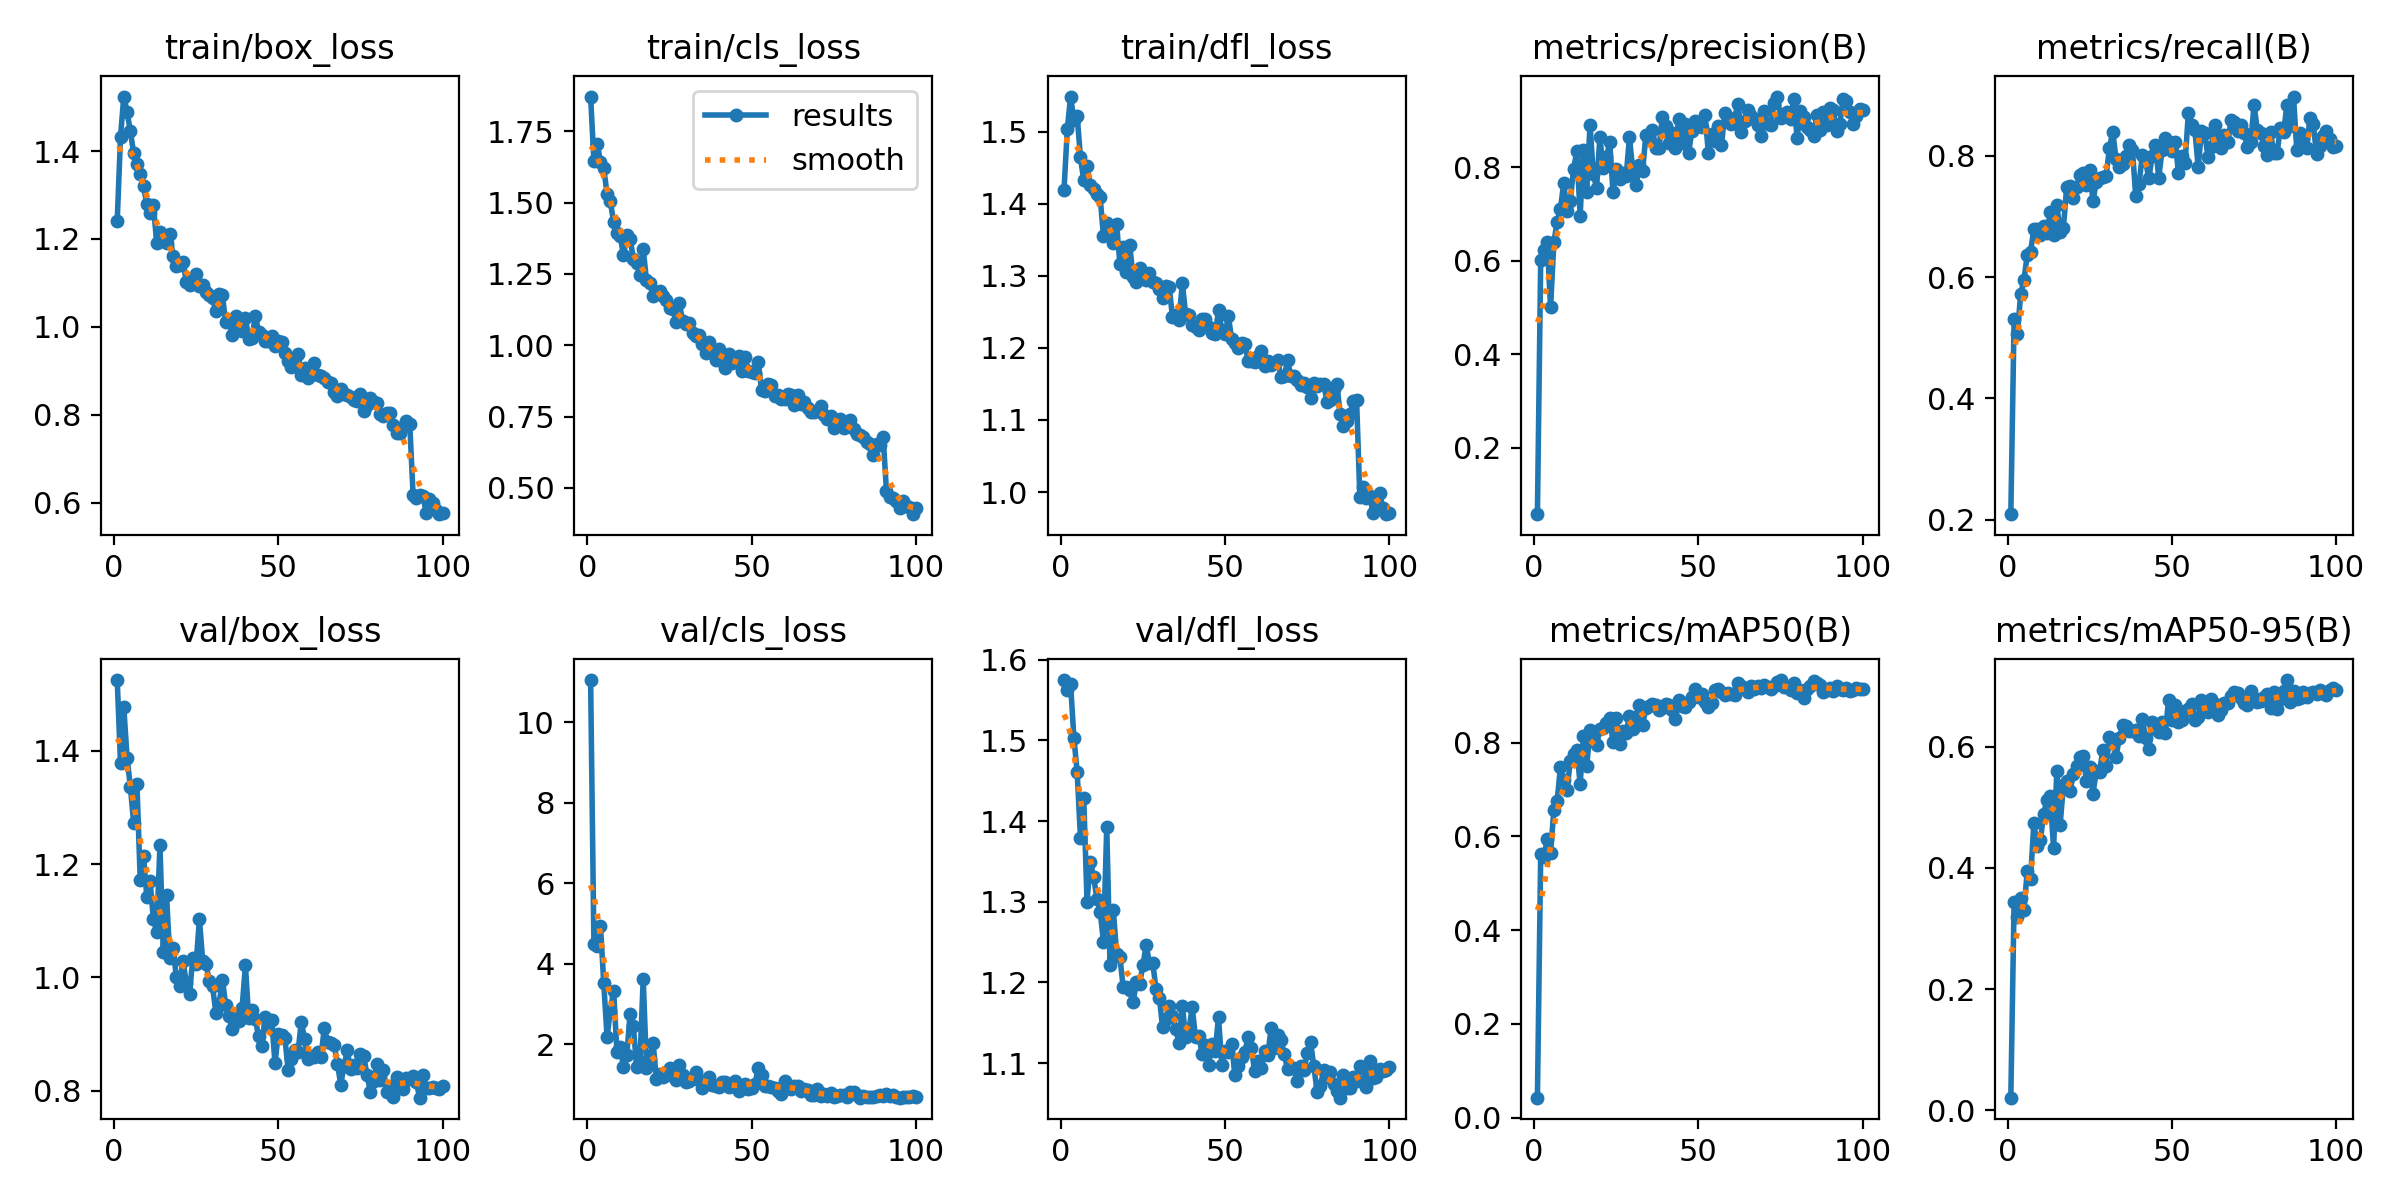

In [ ]:
%cd /content/runs/detect/train2
Image(filename=f'/content/runs/detect/train/results.png', width=600)

/content/runs/detect/train


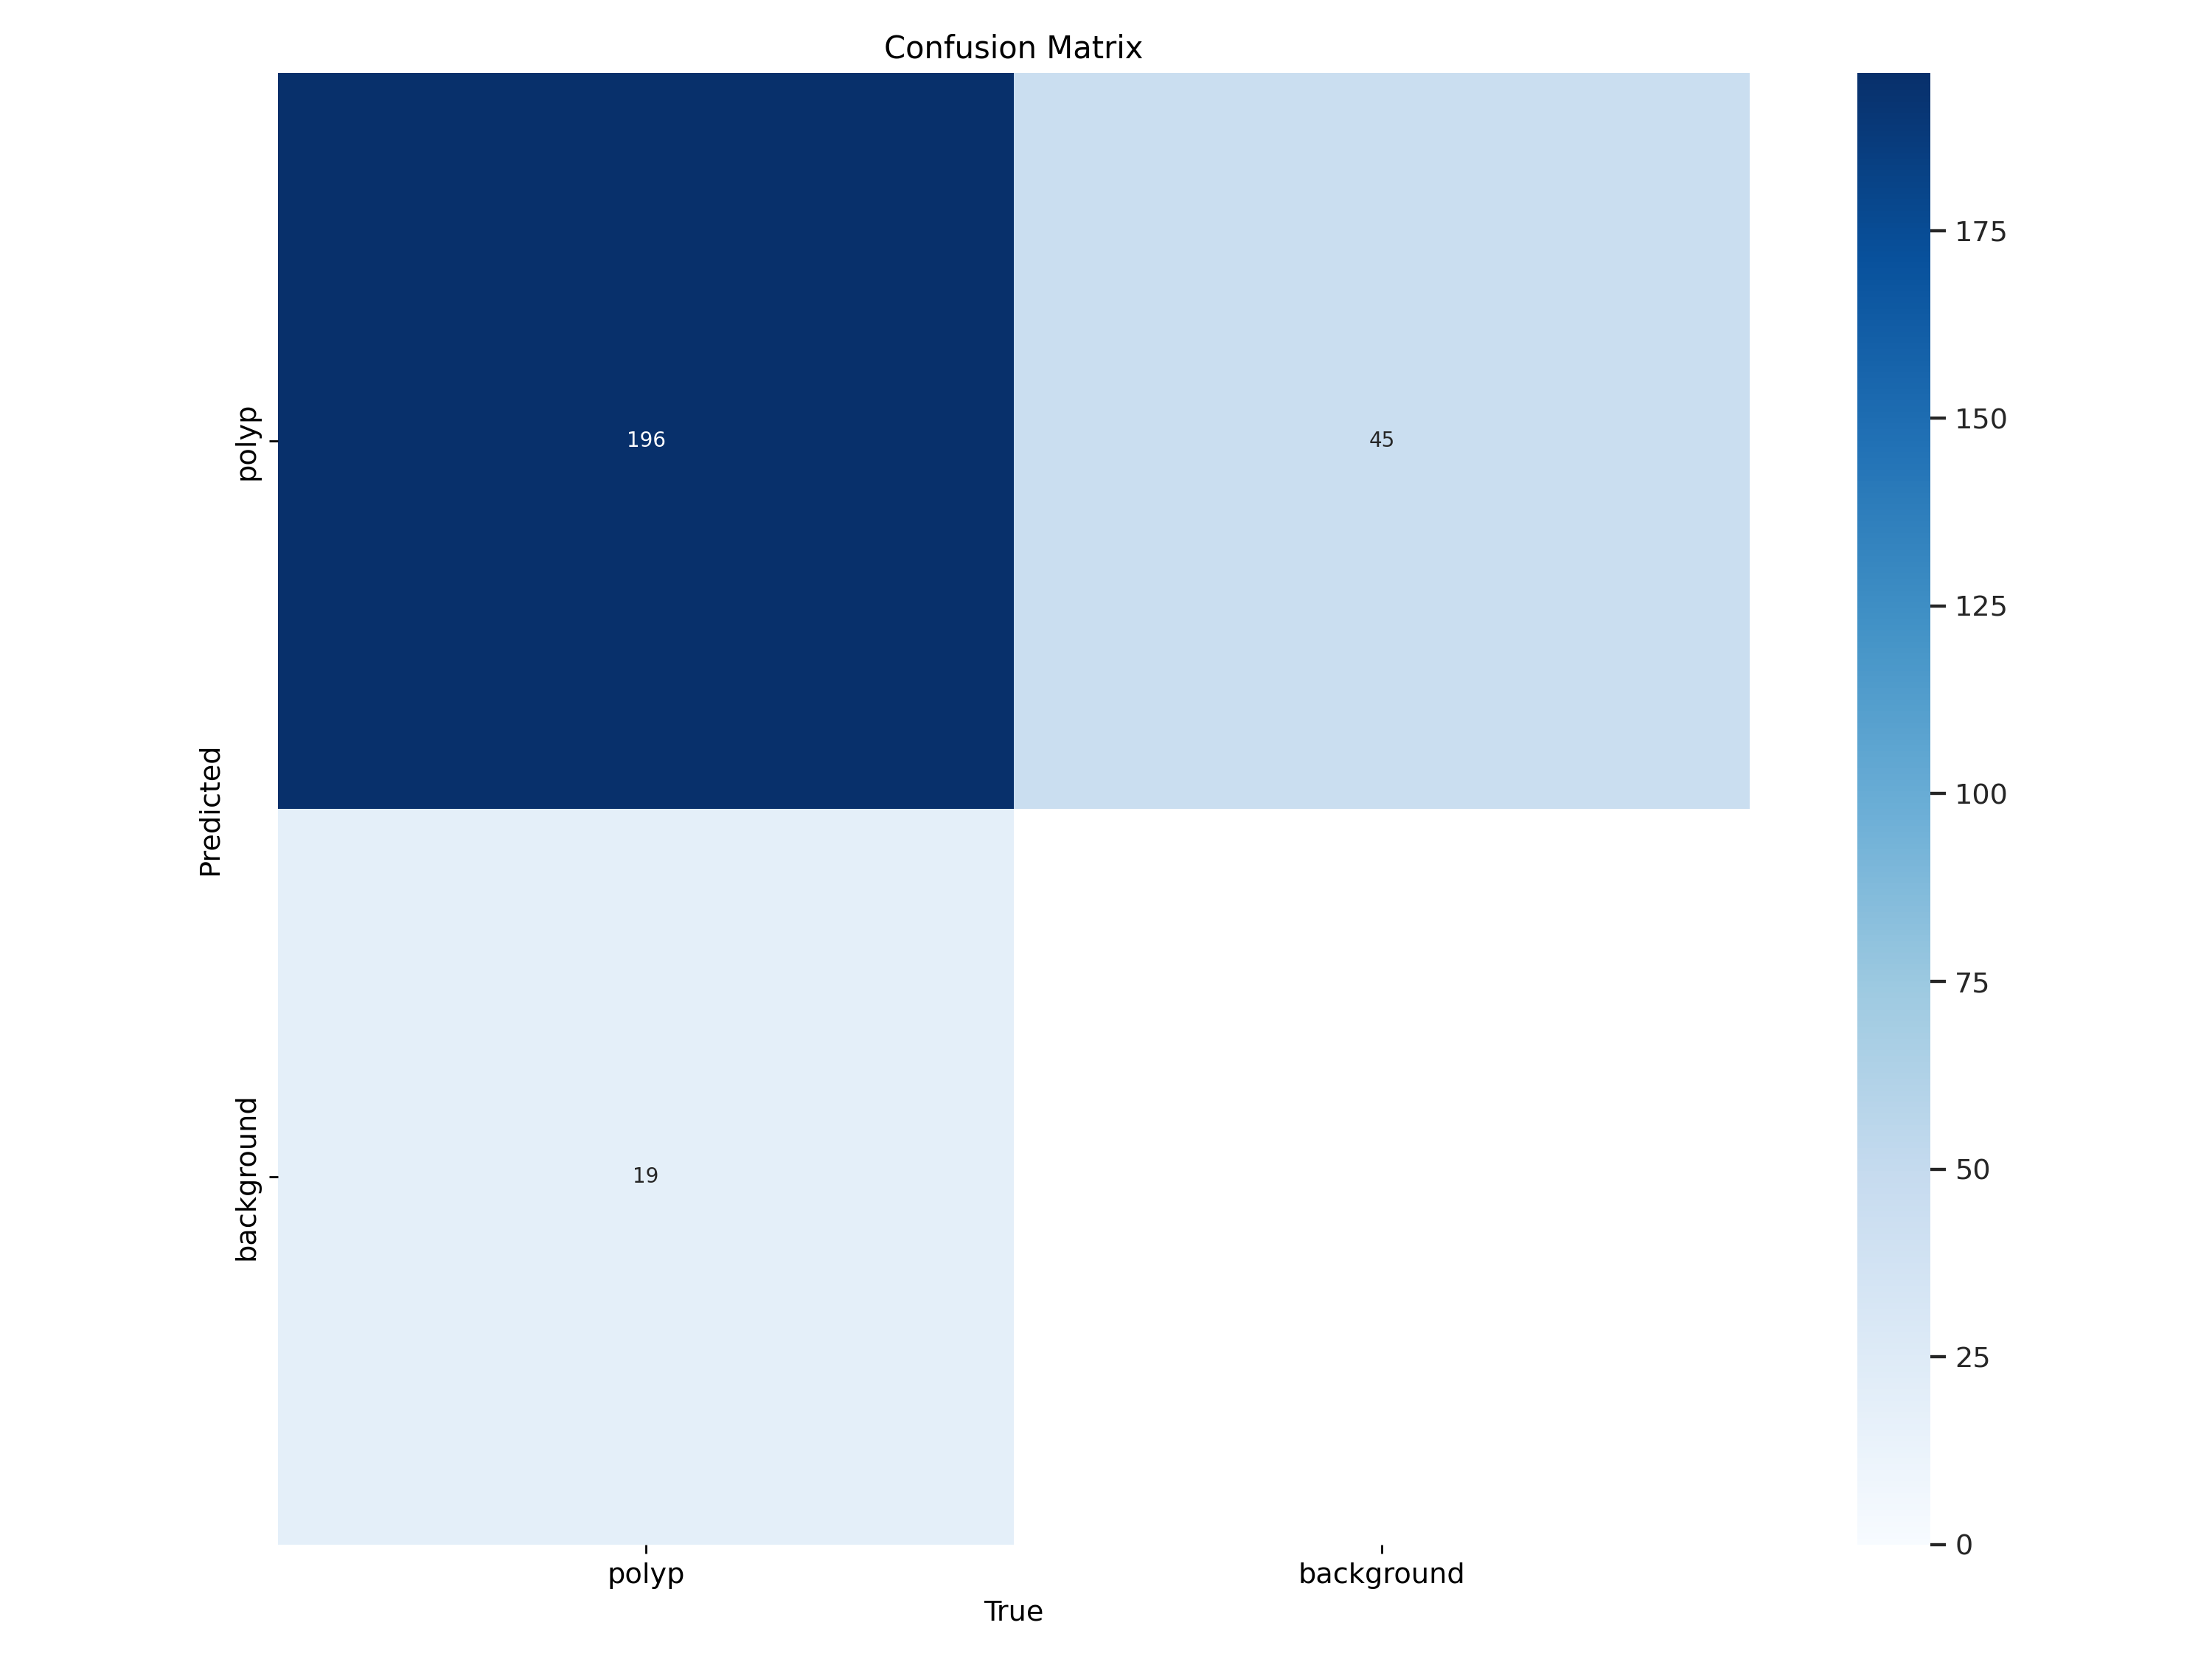

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

/content/runs/detect/train


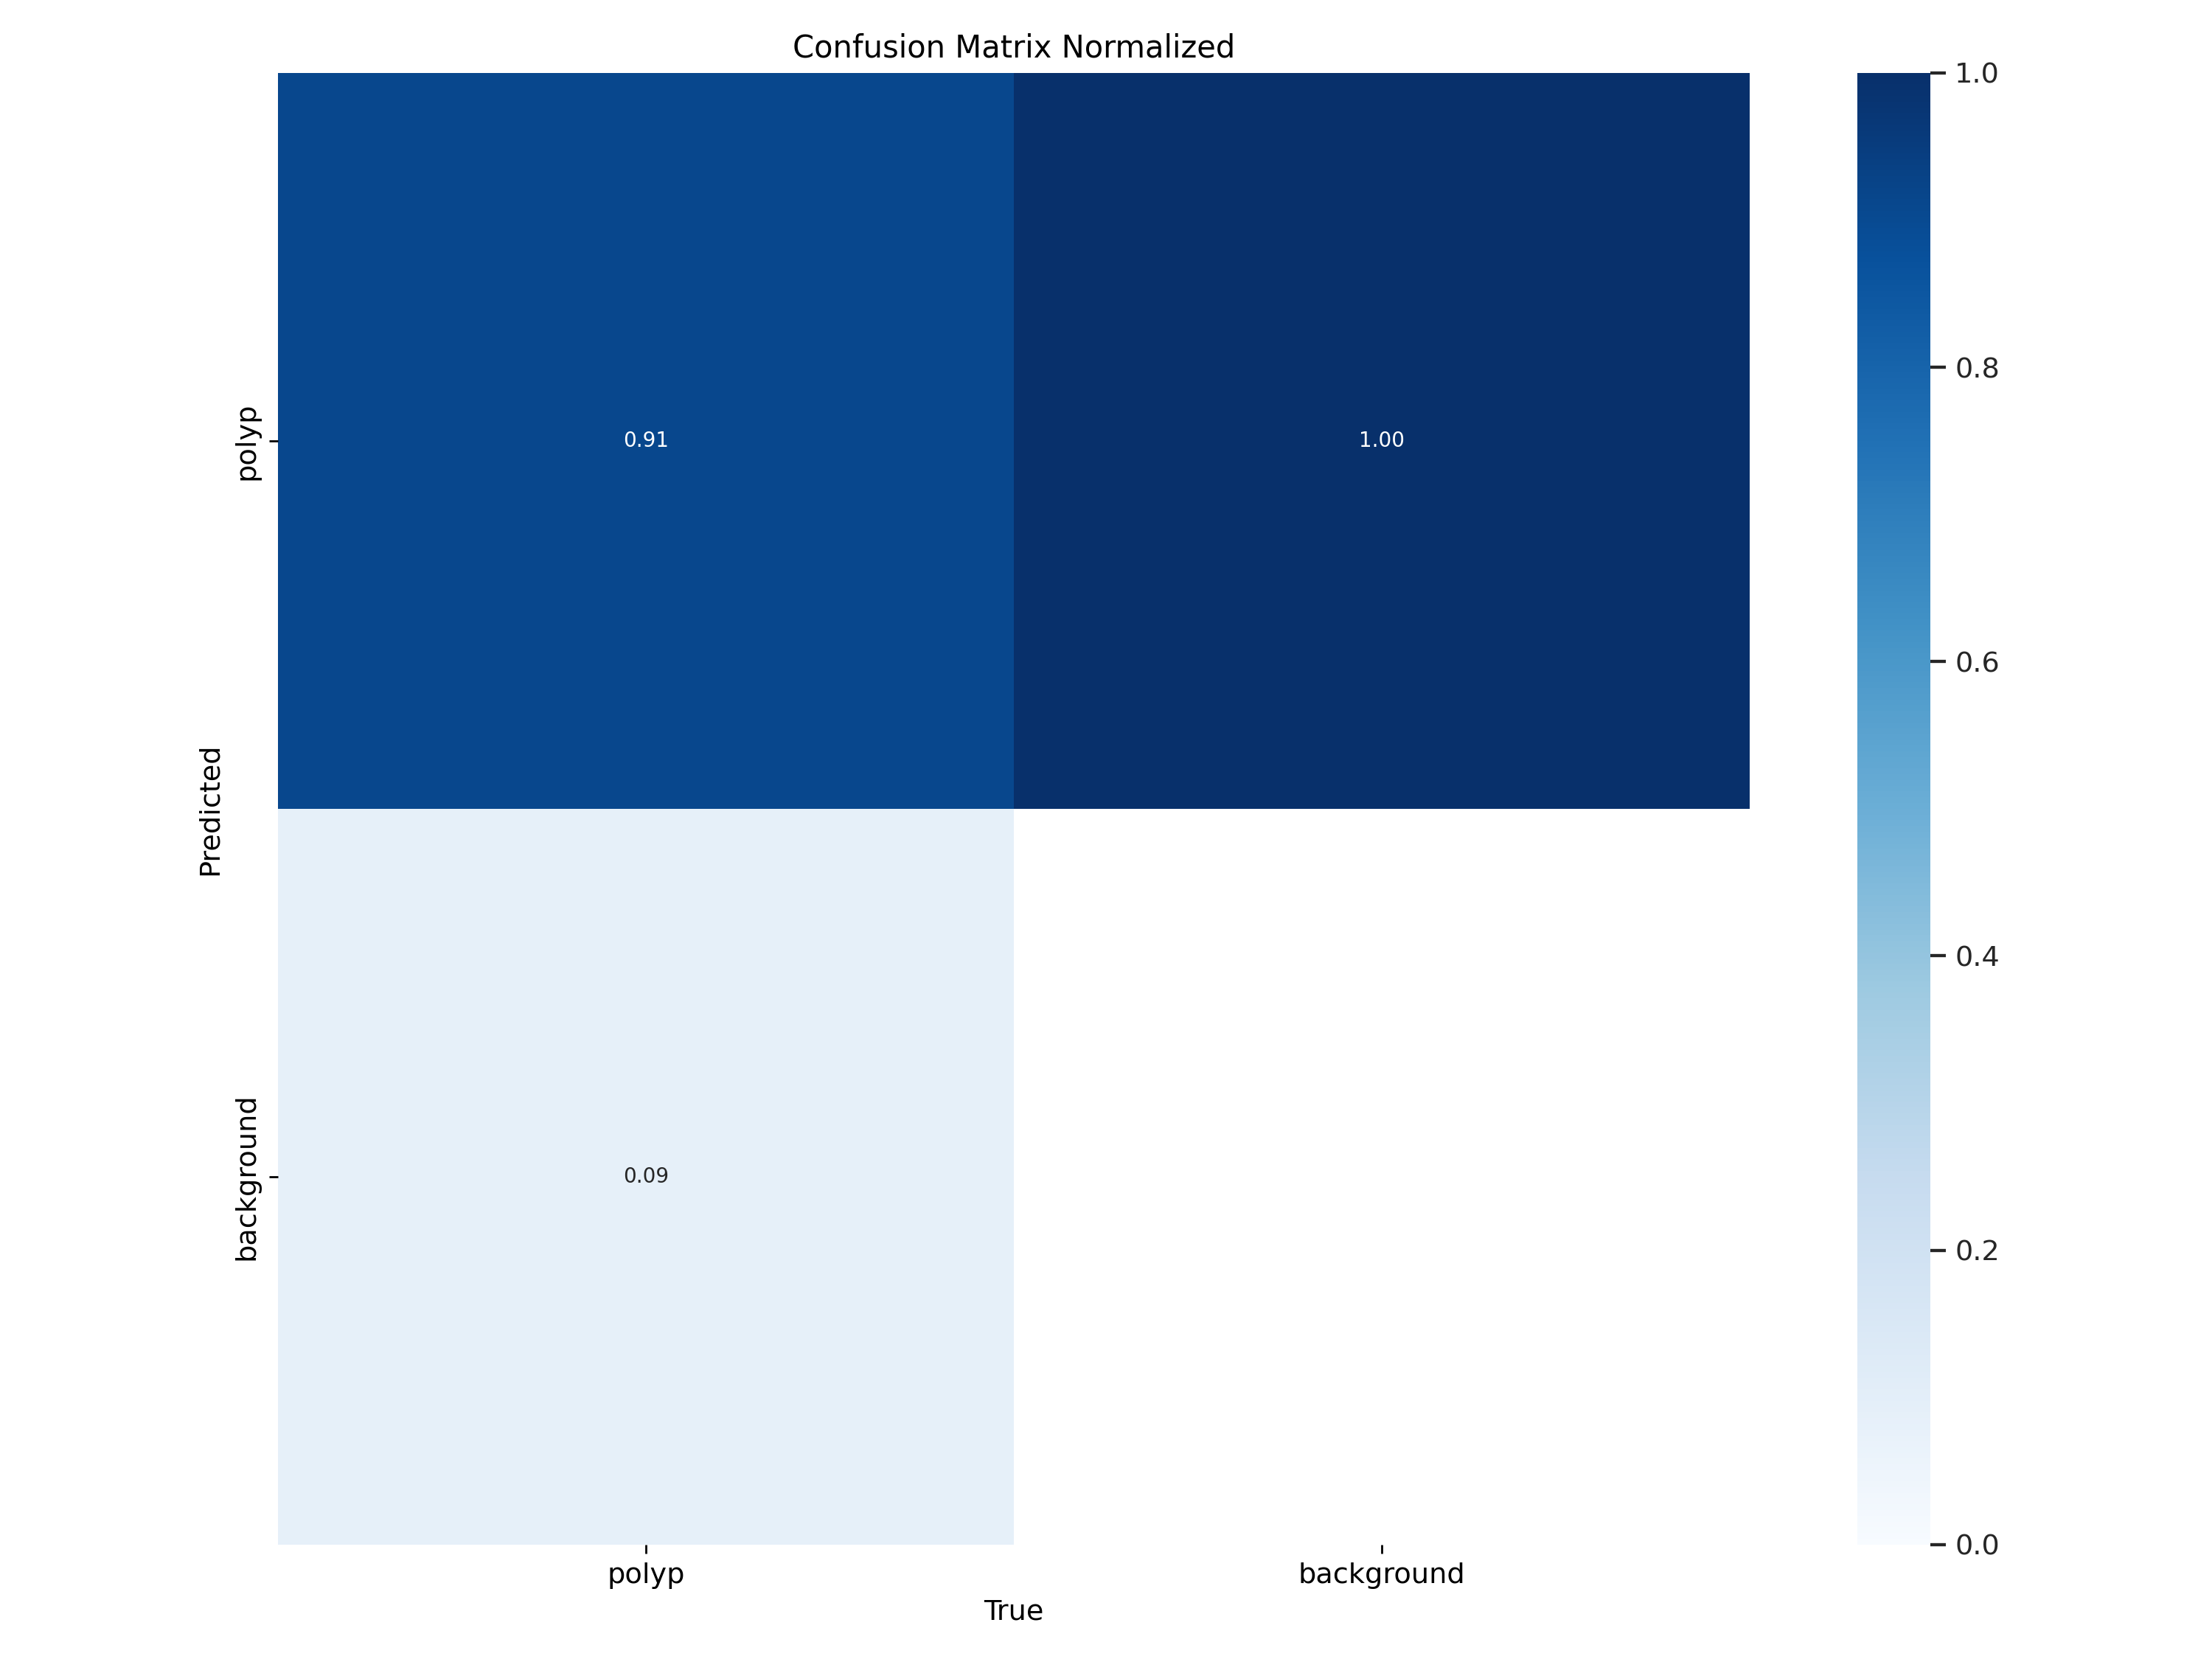

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/confusion_matrix_normalized.png', width=600)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/dataset2.yaml project=/content/runs/detect name=val   conf=0.5 iou=0.5

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1173.6±336.8 MB/s, size: 20.7 KB)
val: Scanning /content/dataset_split_AGC_HR_kvrs_1gt_rem/labels/val.cache... 213 images, 23 backgrounds, 0 corrupt: 100% 236/236 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 15/15 [00:01<00:00,  8.38it/s]
                   all        236        215      0.936      0.828      0.905      0.733
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


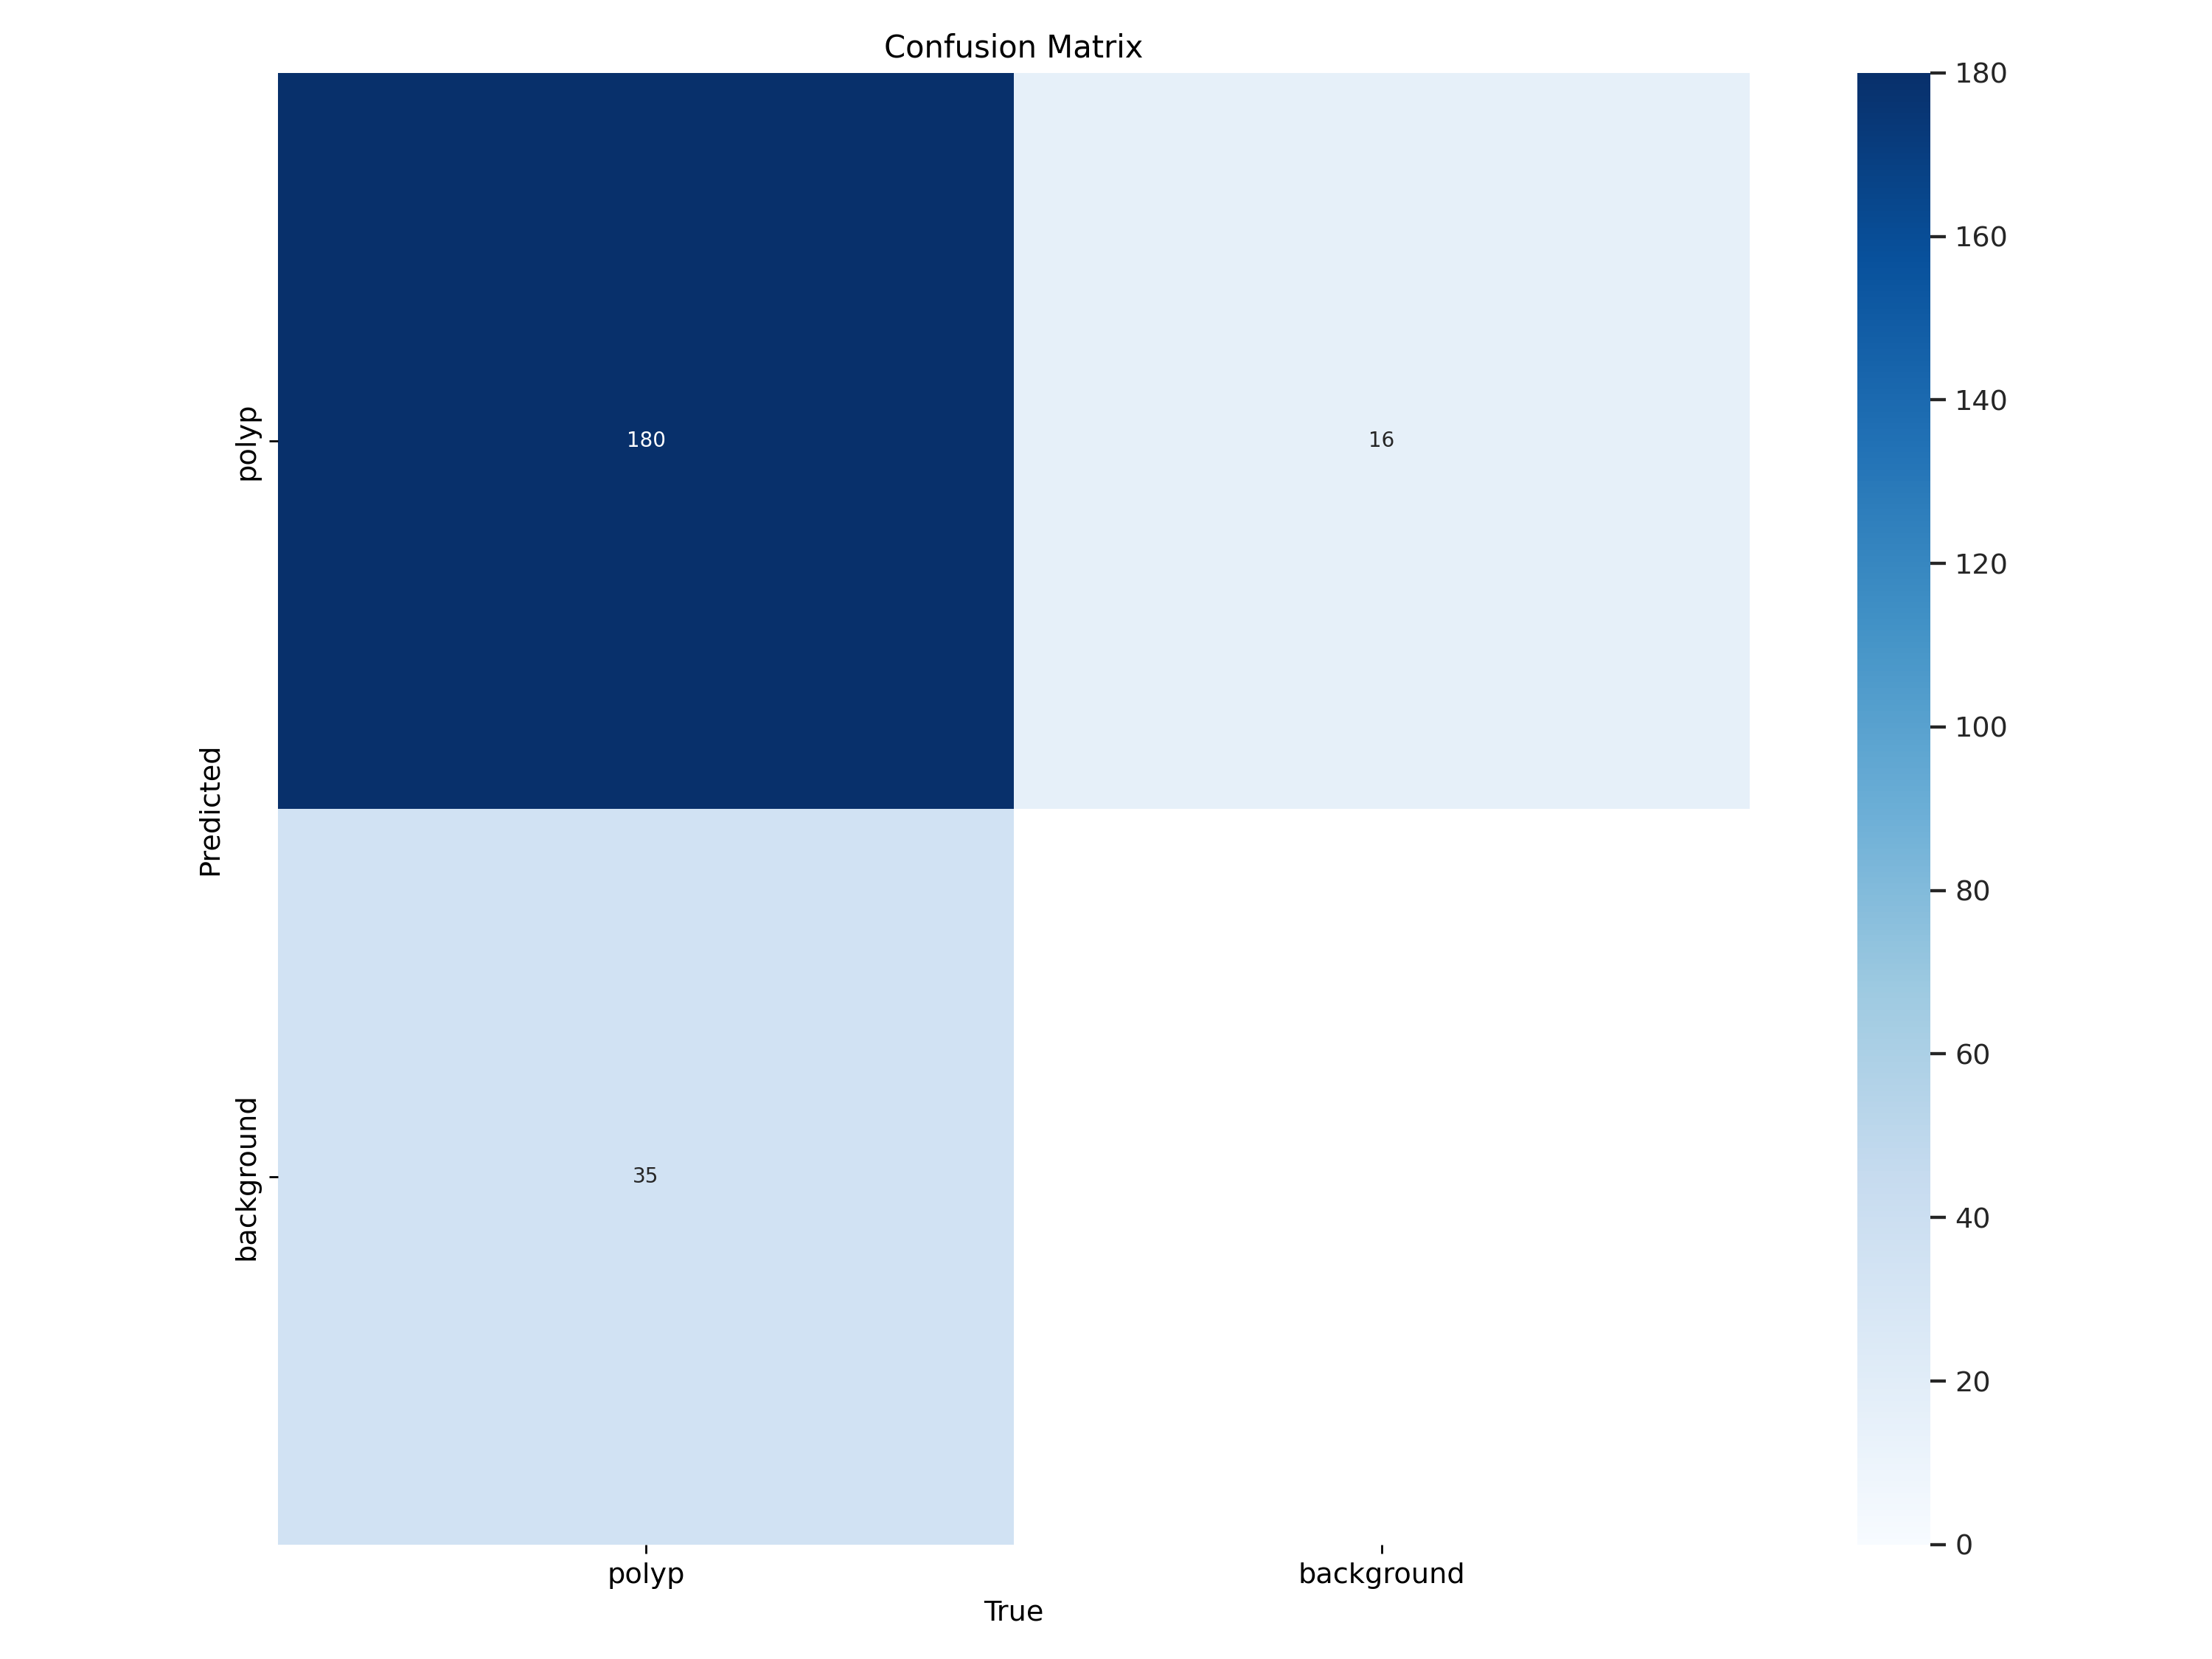

In [ ]:
Image(filename=f'/content/runs/detect/val/confusion_matrix.png', width=600)

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.5 iou=0.5 source=/content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test project=/content/runs/detect name=predict save=True save_txt=True save_conf=True

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/121 /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test/202302240107C026.jpg: 256x256 (no detections), 19.3ms
image 2/121 /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test/202304100178C055.jpg: 256x256 (no detections), 10.9ms
image 3/121 /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test/202305050217C032.jpg: 256x256 (no detections), 9.9ms
image 4/121 /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test/202305050217C060.jpg: 256x256 (no detections), 8.4ms
image 5/121 /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test/202306090262C009.jpg: 256x256 (no detections), 7.9ms
image 6/121 /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test/202306220283C043.jpg: 256x256 (no detections), 7.8ms
image 7/121 /content/dataset_split_AGC_HR_kvrs_1gt_rem/images/test/202312150626C024.jpg: 256x256 (no detection

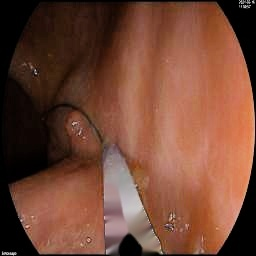

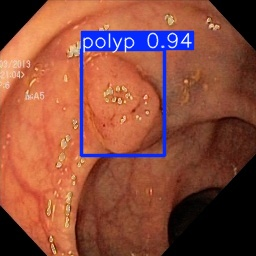

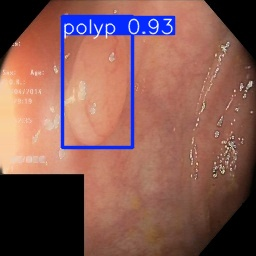

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'/content/runs/detect/predict'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=300))
    print("\n")

####test

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from collections import defaultdict

def compute_iou(box1, box2):
    """Menghitung IoU antara dua bounding box: [x_center, y_center, w, h]"""
    def to_corners(box):
        x, y, w, h = box
        return [x - w/2, y - h/2, x + w/2, y + h/2]

    box1 = to_corners(box1)
    box2 = to_corners(box2)

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append((cls, bbox))
    return labels

def evaluate(pred_dir, gt_dir, iou_threshold=0.5):
    predictions = []
    for pred_file in glob.glob(f"{pred_dir}/*.txt"):
        filename = os.path.basename(pred_file)
        image_id = filename.replace('.txt', '')
        gt_file = os.path.join(gt_dir, filename)

        pred_labels = []
        with open(pred_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                bbox = list(map(float, parts[1:5]))
                conf = float(parts[5]) if len(parts) > 5 else 1.0  # asumsikan confidence = 1.0 jika tidak tersedia
                pred_labels.append((image_id, cls, conf, bbox))
        predictions.extend(pred_labels)

    predictions.sort(key=lambda x: x[2], reverse=True)  # sort by confidence
    class_gt_counts = defaultdict(int)
    gt_boxes = defaultdict(list)

    for gt_file in glob.glob(f"{gt_dir}/*.txt"):
        image_id = os.path.basename(gt_file).replace('.txt', '')
        for cls, bbox in load_labels(gt_file):
            gt_boxes[(image_id, cls)].append({'bbox': bbox, 'used': False})
            class_gt_counts[cls] += 1

    stats = []
    acc_tp = 0
    acc_fp = 0

    for image_id, cls, conf, pred_box in predictions:
        matched = False
        candidates = gt_boxes.get((image_id, cls), [])
        for gt in candidates:
            if not gt['used']:
                iou = compute_iou(pred_box, gt['bbox'])
                if iou >= iou_threshold:
                    gt['used'] = True
                    matched = True
                    break

        tp = 1 if matched else 0
        fp = 0 if matched else 1

        acc_tp += tp
        acc_fp += fp

        precision = acc_tp / (acc_tp + acc_fp) if (acc_tp + acc_fp) > 0 else 0
        recall = acc_tp / sum(class_gt_counts.values()) if sum(class_gt_counts.values()) > 0 else 0

        stats.append([image_id, cls, conf, tp, fp, acc_tp, acc_fp, precision, recall])

    df = pd.DataFrame(stats, columns=["Image", "Class", "Confidence", "TP", "FP", "Acc TP", "Acc FP", "Precision", "Recall"])
    return df

# Contoh pemanggilan:
pred_dir = '/content/runs/detect/predict/labels'
gt_dir = '/content/dataset_split_AGC_HR_kvrs_1gt_rem/labels/test'
df_metrics = evaluate(pred_dir, gt_dir)
df_metrics.to_csv("/content/detection_metrics_AGC_HR_1gt_rem.csv", index=False)


Total Ground Truth: 108
Final Precision: 0.96
Final Recall: 0.8889
Final F1-Score: 0.9231


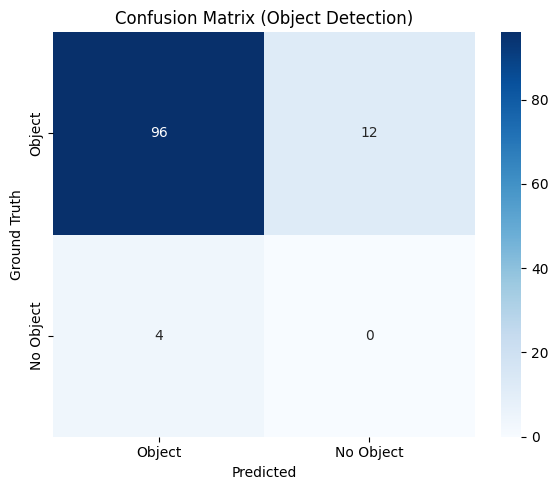

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def count_total_groundtruth(gt_dir):
    """
    Menghitung total jumlah bounding box (ground truth) dari folder label YOLO.

    Args:
        gt_dir (str): Path ke folder label ground truth (YOLO format)

    Returns:
        int: Total jumlah ground truth bounding box
    """
    total_gt = 0
    for file_name in os.listdir(gt_dir):
        if file_name.endswith('.txt'):
            file_path = os.path.join(gt_dir, file_name)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_gt += len(lines)
    return total_gt
gt_dir = '/content/dataset_split_AGC_HR_kvrs_1gt_rem/labels/test'
total_gt = count_total_groundtruth(gt_dir)
print(f"Total Ground Truth: {total_gt}")

def compute_final_metrics(df: pd.DataFrame, total_gt: int):
    """
    Menghitung TP, FP, FN, Precision, Recall, dan F1-score dari DataFrame hasil evaluasi.

    Args:
        df (pd.DataFrame): DataFrame berisi kolom ['TP', 'FP'] untuk masing-masing prediksi
        total_gt (int): Jumlah total ground truth (box sebenarnya)

    Returns:
        dict: Confusion matrix dan metrik evaluasi
    """
    tp = df['TP'].sum()
    fp = df['FP'].sum()
    fn = total_gt - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }
# Misalnya 'eval_df' adalah DataFrame berisi kolom ['TP', 'FP']
final_result = compute_final_metrics(df_metrics, total_gt)

print(f"Final Precision: {final_result['Precision']}")
print(f"Final Recall: {final_result['Recall']}")
print(f"Final F1-Score: {final_result['F1 Score']}")

tp = final_result['True Positive (TP)']
fp = final_result['False Positive (FP)']
fn = final_result['False Negative (FN)']
tn = 0  # TN tidak dihitung dalam object detection
# Plot confusion matrix
conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

labels = ['Object', 'No Object']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix (Object Detection)')
plt.tight_layout()
plt.show()

##HR-AGC

####kvasir

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_HR_AGC_kvasir_seg_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_HR_AGC_kvasir_seg_1gt_removed.zip -d /content/output_HR_AGC_kvasir_seg_1gt_removed/


Archive:  /content/output_HR_AGC_kvasir_seg_1gt_removed.zip
   creating: /content/output_HR_AGC_kvasir_seg_1gt_removed/bboxes/
   creating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-347.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-204.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-911.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-79.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-709.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-870.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-919.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-646.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/images/kv-seg-812.jpg  
  inflating: /content/output_HR_AGC_kvasir_seg_1gt_removed/i

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_HR_AGC_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_HR_AGC_RSUA_1gt_removed.zip -d /content/output_HR_AGC_RSUA_1gt_removed/


Archive:  /content/output_HR_AGC_RSUA_1gt_removed.zip
   creating: /content/output_HR_AGC_RSUA_1gt_removed/bboxes/
   creating: /content/output_HR_AGC_RSUA_1gt_removed/images/
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/2_polyp-1-_202301260065C071.jpg  
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/4_polyp-1-_202307170329C049.jpg  
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/3_polyp-1-_asli_202405160871C094.jpg  
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/4_polyp-1-_202406050908C006.jpg  
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/4_polyp-1-_202409191126C010.jpg  
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/3_polyp-1-_202306270295C062.jpg  
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/polyp-1-_202305050217C020.jpg  
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/6_polyp-1-_asli_202402190736C019.jpg  
  inflating: /content/output_HR_AGC_RSUA_1gt_removed/images/6_po

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_HR_AGC_normal_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_HR_AGC_normal_RSUA_1gt_removed.zip -d /content/output_HR_AGC_normal_RSUA_1gt_removed/


Archive:  /content/output_HR_AGC_normal_RSUA_1gt_removed.zip
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202405200875C070.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202409051095C040.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202412311348C043.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202405130861C015.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202402020707C059.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202306270295C027.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202310030465C060.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202306270295C045.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202305090219C035.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202407291035C086.jpg  
  inflating: /content/output_HR_AGC_normal_RSUA_1gt_removed/202409191126C006.jpg  
  inflating: /content/outp

In [ ]:
# Path ke folder output (misalnya, 'dataset_split' di direktori saat ini)
output_path = 'dataset_split_HR_AGC_kvrs_1gt_rem'

# Membuat folder output
os.makedirs(output_path, exist_ok=True)

In [ ]:
import pandas as pd
import os
import random
from glob import glob
import shutil


def split_dataset1(images_path, labels_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Memastikan rasio pembagian data totalnya 1.0
    # assert train_ratio + val_ratio + test_ratio == 1.0, "Total rasio train, val, dan test harus 1.0"

    # Membuat folder output untuk train, val, dan test
    os.makedirs(os.path.join(output_path, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'test'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'test'), exist_ok=True)

    # Dapatkan semua file gambar
    image_files = glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png"))

    # Pastikan ada file gambar
    assert len(image_files) > 0, "Tidak ada file gambar yang ditemukan."

    # Mengacak urutan file
    random.shuffle(image_files)

    # Hitung jumlah file untuk setiap set
    total_images = len(image_files)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)

    # Bagi dataset menjadi train, val, dan test
    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + val_count]
    test_images = image_files[train_count + val_count:]

    # Fungsi untuk menyalin file ke direktori tujuan dan mengonversi label
    def copy_files(image_set, subset):
        for img_file in image_set:
            # Salin file gambar
            shutil.copy(img_file, os.path.join(output_path, 'images', subset, os.path.basename(img_file)))

            # Salin file label dengan ekstensi CSV jika ada
            label_file_path = os.path.join(labels_path, os.path.splitext(os.path.basename(img_file))[0] + '.txt')
            if os.path.exists(label_file_path):
                #convert_csv_to_yolo(label_file_path, img_file, os.path.join(output_path, 'labels', subset))
                shutil.copy(label_file_path, os.path.join(output_path, 'labels', subset, os.path.basename(label_file_path)))
            else:
                print(f"Warning: Label tidak ditemukan untuk {img_file}")

    # Menyalin file ke direktori train, val, dan test
    copy_files(train_images, 'train')
    copy_files(val_images, 'val')
    copy_files(test_images, 'test')

    print(f"Dataset dibagi menjadi train ({len(train_images)}), val ({len(val_images)}), dan test ({len(test_images)})")


In [ ]:
# Contoh penggunaan
images_path = '/content/output_HR_AGC_normal_RSUA_1gt_removed'
images_path1 = '/content/output_HR_AGC_kvasir_seg_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path1 = '/content/output_HR_AGC_kvasir_seg_1gt_removed/bboxes'  # Path ke folder yang berisi semua file anotasi
images_path11 = '/content/output_HR_AGC_RSUA_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path11 = '/content/output_HR_AGC_RSUA_1gt_removed/bboxes'
output_path = '/content/dataset_split_HR_AGC_kvrs_1gt_rem'  # Path ke folder tujuan untuk dataset yang telah dipisah

split_dataset1(images_path1, labels_path1, output_path)
split_dataset1(images_path11, labels_path11, output_path)
split_normal_dataset (images_path, output_path)

Dataset dibagi menjadi train (665), val (190), dan test (95)
Dataset dibagi menjadi train (83), val (23), dan test (13)
Dataset normal berhasil dibagi ke folder yang sudah ada: train (83), val (23), test (13)


In [ ]:
# Inisialisasi counter
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_HR_AGC_kvrs_1gt_rem/images/train'):
    if file_name.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_HR_AGC_kvrs_1gt_rem/labels/train'):
    if file_name.endswith(('.txt')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")

Jumlah file gambar dalam folder: 831
Jumlah file gambar dalam folder: 748


In [ ]:
import yaml

# Data untuk file YAML
dataset = {
    'train': '/content/dataset_split_HR_AGC_kvrs_1gt_rem/images/train',  # Ubah sesuai path ke folder gambar train Anda
    'val': '/content/dataset_split_HR_AGC_kvrs_1gt_rem/images/val',      # Ubah sesuai path
    'test': '/content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test',
    'nc': 1,  # Jumlah kelas
    'names': ['polyp']  # Nama-nama kelas
}

# Path untuk menyimpan file YAML
yaml_file = '/content/dataset3.yaml'

# Menulis file YAML
with open(yaml_file, 'w') as file:
    yaml.dump(dataset, file)

print(f"File YAML dataset berhasil dibuat: {yaml_file}")


File YAML dataset berhasil dibuat: /content/dataset3.yaml


###model

In [ ]:
# Load a model
model2 = YOLO("yolo11s.pt")

# Train the model
train_results = model2.train(
    data="/content/dataset3.yaml",  # path to dataset YAML
    epochs=100,             # max epoch
    imgsz=256,
    batch=8,
    device=0,
    project="/content/runs/detect",  # direktori utama penyimpanan
    name="train",                   # subfolder hasil training
    exist_ok=True                    # tidak error jika folder sudah ada
    #patience=10,            # Early stopping if no improvement in 10 epochs
    #verbose=True
)

# Evaluate model performance on the validation set
#metrics = model.val()

100%|██████████| 18.4M/18.4M [00:00<00:00, 449MB/s]

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset3.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

100%|██████████| 755k/755k [00:00<00:00, 76.5MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

YOLO11s summary: 181 layers, 9,428,179 parameters, 9,428,163 gradients, 21.5 GFLOPs

Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 341MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 887.8±357.1 MB/s, size: 29.0 KB)


train: Scanning /content/dataset_split_HR_AGC_kvrs_1gt_rem/labels/train... 748 images, 83 backgrounds, 0 corrupt: 100%|██████████| 831/831 [00:00<00:00, 2105.12it/s]

train: New cache created: /content/dataset_split_HR_AGC_kvrs_1gt_rem/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 252.4±217.5 MB/s, size: 23.6 KB)


val: Scanning /content/dataset_split_HR_AGC_kvrs_1gt_rem/labels/val... 213 images, 23 backgrounds, 0 corrupt: 100%|██████████| 236/236 [00:00<00:00, 1601.17it/s]

val: New cache created: /content/dataset_split_HR_AGC_kvrs_1gt_rem/labels/val.cache


Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.568G      1.286      1.883      1.438         14        256: 100%|██████████| 104/104 [00:15<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]

                   all        236        213      0.346      0.493        0.3      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.641G      1.427      1.648        1.5         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.73it/s]

                   all        236        213      0.592      0.549      0.553      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      0.68G      1.434      1.607      1.501         20        256: 100%|██████████| 104/104 [00:11<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.76it/s]

                   all        236        213      0.259       0.46      0.283      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.752G      1.472      1.623      1.534         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.59it/s]

                   all        236        213      0.549      0.535      0.591      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.791G      1.417      1.554      1.505          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.67it/s]

                   all        236        213       0.67      0.545      0.592      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.861G      1.389      1.501      1.463         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.16it/s]

                   all        236        213      0.788      0.629      0.742      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.902G      1.379      1.527      1.473          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.49it/s]

                   all        236        213      0.734      0.592      0.687      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.941G      1.337       1.43      1.454         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.73it/s]

                   all        236        213      0.781      0.596      0.715      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         1G      1.294      1.377      1.395         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.61it/s]

                   all        236        213      0.743      0.732       0.79       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.09G      1.272      1.386      1.408          8        256: 100%|██████████| 104/104 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.75it/s]

                   all        236        213      0.781      0.507      0.634      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.13G      1.258      1.307      1.389         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.86it/s]

                   all        236        213      0.779      0.695      0.764      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.17G      1.261      1.326      1.399         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.79it/s]

                   all        236        213      0.769      0.662      0.772      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.24G      1.235      1.343      1.372         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.56it/s]

                   all        236        213      0.767      0.667       0.75       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.28G      1.197      1.282       1.35         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.64it/s]

                   all        236        213      0.789      0.742        0.8      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.34G      1.212      1.262      1.379         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.63it/s]

                   all        236        213       0.71      0.808      0.814       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.38G      1.186      1.263      1.352         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.06it/s]

                   all        236        213      0.786      0.688      0.819      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.44G      1.194      1.266      1.336         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]

                   all        236        213      0.754      0.733      0.794      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.49G      1.148        1.2      1.328          5        256: 100%|██████████| 104/104 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.52it/s]

                   all        236        213      0.831      0.761      0.839      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.55G      1.195      1.254      1.375         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.82it/s]

                   all        236        213      0.803      0.767      0.804      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.61G      1.106      1.144      1.298         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.19it/s]

                   all        236        213      0.847      0.709      0.822      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.65G      1.134      1.168      1.311         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.10it/s]

                   all        236        213      0.825      0.733      0.844       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.71G      1.119      1.176       1.31         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.92it/s]

                   all        236        213      0.868      0.709      0.844      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       1.8G      1.128      1.175      1.329         18        256: 100%|██████████| 104/104 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.61it/s]

                   all        236        213      0.844      0.761      0.862      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.84G       1.13       1.13      1.312         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.04it/s]

                   all        236        213      0.856      0.698      0.827      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.88G      1.114      1.121        1.3         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.29it/s]

                   all        236        213       0.85      0.797      0.881      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.94G      1.081      1.111      1.296         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.82it/s]

                   all        236        213      0.904      0.755      0.878      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.98G      1.104      1.103      1.287         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.86it/s]

                   all        236        213      0.796      0.812      0.866      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.05G      1.069      1.061       1.28         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.88it/s]

                   all        236        213      0.811      0.807      0.873      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.09G      1.029       1.06      1.261         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.97it/s]

                   all        236        213       0.81       0.77      0.878      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.16G      1.031      1.021      1.275         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.83it/s]

                   all        236        213      0.817      0.839      0.881      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.2G      1.041      1.023      1.279         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.91it/s]

                   all        236        213       0.85       0.85      0.892       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.27G      1.044     0.9877      1.284         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.20it/s]

                   all        236        213      0.825      0.794      0.875      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.31G      1.041      1.014      1.265          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]

                   all        236        213      0.834       0.77      0.873      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.37G      1.033      1.016      1.256         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.09it/s]

                   all        236        213      0.821      0.817      0.882      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.44G      1.013     0.9911      1.243         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

                   all        236        213      0.851      0.832      0.904      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.48G      1.022      0.999      1.263         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.86it/s]

                   all        236        213      0.857      0.822      0.901      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.55G      1.019     0.9596      1.258         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]

                   all        236        213      0.848      0.783      0.887      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.59G      1.005     0.9617       1.24         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.13it/s]

                   all        236        213      0.856      0.783      0.883      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.63G      1.021      1.005       1.26         15        256: 100%|██████████| 104/104 [00:10<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.09it/s]

                   all        236        213      0.867      0.845      0.897      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.69G       0.98     0.9733      1.229         11        256: 100%|██████████| 104/104 [00:10<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.66it/s]

                   all        236        213      0.863       0.77      0.869      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.78G       1.01     0.9817      1.253          9        256: 100%|██████████| 104/104 [00:10<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.51it/s]

                   all        236        213      0.851      0.807      0.876      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.82G      1.012     0.9856      1.256         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.18it/s]

                   all        236        213      0.859       0.85      0.902      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.86G     0.9821     0.9569       1.23         13        256: 100%|██████████| 104/104 [00:10<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.25it/s]

                   all        236        213      0.873      0.806      0.892      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.93G     0.9625     0.9275      1.221         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.63it/s]

                   all        236        213      0.882      0.887      0.916      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.97G     0.9987     0.9326      1.231         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]

                   all        236        213       0.84      0.803       0.86      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.04G     0.9735     0.9219      1.219         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.02it/s]

                   all        236        213      0.864      0.869      0.903      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.08G     0.9596     0.9414      1.211         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.05it/s]

                   all        236        213      0.879      0.873      0.923      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.14G     0.9424     0.9042      1.206         19        256: 100%|██████████| 104/104 [00:11<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.04it/s]

                   all        236        213      0.868      0.859      0.906      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.2G     0.9513     0.9112      1.217         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        236        213      0.894      0.826      0.913      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.28G      0.942     0.9037      1.213          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.05it/s]

                   all        236        213      0.935      0.761      0.905      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.35G     0.9406     0.9506      1.212         11        256: 100%|██████████| 104/104 [00:12<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.03it/s]

                   all        236        213      0.892      0.812      0.913       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.39G     0.9376     0.9379      1.202         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.32it/s]

                   all        236        213      0.861      0.822      0.892      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.43G     0.9174     0.8492        1.2         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.05it/s]

                   all        236        213      0.848      0.798      0.871       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.47G     0.9145     0.8783      1.198         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.92it/s]

                   all        236        213      0.836       0.85      0.899      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.56G     0.9132     0.8521      1.193          8        256: 100%|██████████| 104/104 [00:11<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.90it/s]

                   all        236        213      0.857      0.836      0.903      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       3.6G     0.9077     0.8704      1.189         12        256: 100%|██████████| 104/104 [00:10<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]

                   all        236        213      0.813      0.897      0.908      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.64G     0.9547     0.9072      1.218         15        256: 100%|██████████| 104/104 [00:10<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]

                   all        236        213      0.913      0.786      0.884      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.68G     0.9156     0.8769      1.187         14        256: 100%|██████████| 104/104 [00:10<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]

                   all        236        213       0.86      0.836      0.895      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.75G     0.9038     0.8412      1.177         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]

                   all        236        213      0.855       0.85      0.919      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.79G     0.8861     0.8318      1.177          8        256: 100%|██████████| 104/104 [00:11<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]

                   all        236        213      0.845      0.859       0.91      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.85G     0.9208     0.8239      1.194         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]

                   all        236        213      0.911      0.863      0.927      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.89G     0.8676     0.8272      1.167         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.91it/s]

                   all        236        213      0.917      0.808      0.923      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.96G     0.8757        0.8      1.154         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.13it/s]

                   all        236        213      0.885      0.854      0.926      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         4G     0.8614     0.7985      1.173         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.81it/s]

                   all        236        213       0.86      0.862      0.914      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.07G     0.8931     0.8326      1.175         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.50it/s]

                   all        236        213       0.88       0.85      0.903      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.13G     0.8971     0.8114      1.177         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.93it/s]

                   all        236        213      0.912      0.822      0.918      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.21G      0.847     0.7949      1.148         18        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.07it/s]

                   all        236        213      0.883      0.854      0.923      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.26G     0.8453     0.7707      1.148         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]

                   all        236        213      0.905      0.809      0.911      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.29G     0.8405     0.7778      1.156         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.01it/s]

                   all        236        213      0.899      0.796       0.91      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.37G     0.8507     0.7619      1.152         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.37it/s]

                   all        236        213      0.933      0.826      0.932      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.41G     0.8417     0.7713      1.143         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.20it/s]

                   all        236        213      0.865      0.871      0.922      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.45G     0.8469     0.7613      1.158         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.99it/s]

                   all        236        213        0.9      0.873      0.938      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.52G     0.8404     0.7504      1.152          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.48it/s]

                   all        236        213      0.897      0.869      0.936      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.56G     0.8589     0.7764      1.174          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.88it/s]

                   all        236        213      0.933      0.854      0.935      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.62G      0.828     0.7396      1.134         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

                   all        236        213      0.898      0.845      0.933      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.65G     0.8456     0.7675      1.152         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.27it/s]

                   all        236        213      0.931      0.823      0.933      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.73G     0.8119     0.7491      1.135          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.99it/s]

                   all        236        213      0.885      0.883      0.937      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.81G     0.8265     0.7074      1.136         18        256: 100%|██████████| 104/104 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

                   all        236        213      0.937      0.812      0.925      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.85G     0.8396      0.745      1.137         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.17it/s]

                   all        236        213      0.849      0.898      0.942      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.89G     0.8244     0.7186      1.134         17        256: 100%|██████████| 104/104 [00:12<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.73it/s]

                   all        236        213      0.895      0.897      0.936      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.93G      0.796     0.7193      1.129          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.30it/s]

                   all        236        213      0.889      0.865      0.933      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.99G     0.7969     0.7064      1.123         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.23it/s]

                   all        236        213      0.933      0.854      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.05G     0.7945     0.7018      1.122          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.85it/s]

                   all        236        213      0.946      0.808       0.93      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.11G     0.7876      0.698      1.122         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.99it/s]

                   all        236        213      0.885      0.859      0.929      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       5.2G     0.7586     0.6711      1.101         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.17it/s]

                   all        236        213      0.867      0.888      0.932      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.24G     0.7868     0.6844      1.117         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.03it/s]

                   all        236        213      0.895      0.885      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.31G     0.7417     0.6491      1.085         17        256: 100%|██████████| 104/104 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.21it/s]

                   all        236        213      0.899       0.88      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.35G     0.7836     0.6608      1.119         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.81it/s]

                   all        236        213      0.886      0.887      0.931      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.39G     0.7821     0.6938      1.114          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.68it/s]

                   all        236        213      0.855      0.913      0.938      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.47G      0.786     0.6863      1.123         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.15it/s]

                   all        236        213      0.912      0.869      0.939      0.736


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.51G     0.6461     0.5408       1.01          6        256: 100%|██████████| 104/104 [00:12<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.03it/s]

                   all        236        213      0.908      0.838      0.928      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.55G     0.6147     0.4844     0.9953          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.71it/s]

                   all        236        213      0.891      0.841       0.93      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.59G     0.6184      0.489     0.9852          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.97it/s]

                   all        236        213      0.873      0.869      0.932      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.66G     0.5993     0.4641     0.9794          7        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.01it/s]

                   all        236        213      0.912      0.859      0.934      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       5.7G     0.5857     0.4572     0.9838          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.06it/s]

                   all        236        213      0.888      0.895      0.937      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.76G      0.599      0.446     0.9888          6        256: 100%|██████████| 104/104 [00:11<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.11it/s]

                   all        236        213      0.912      0.869      0.934      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.82G     0.5791     0.4581     0.9751          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.75it/s]

                   all        236        213      0.915      0.858      0.935      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.88G      0.575     0.4356     0.9609          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.94it/s]

                   all        236        213       0.92      0.883      0.937      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.92G     0.5649     0.4385     0.9762          5        256: 100%|██████████| 104/104 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.75it/s]

                   all        236        213      0.912       0.87      0.936      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.01G     0.5687     0.4298     0.9742          6        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.03it/s]

                   all        236        213      0.911      0.865      0.936      0.742



100 epochs completed in 0.376 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 19.1MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


                   all        236        213      0.917      0.878      0.937      0.749
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/runs/detect/train


In [ ]:
import pandas as pd

# Path ke file hasil training YOLOv8
results_path = "/content/runs/detect/train/results.csv"

# Baca file hasil training
df = pd.read_csv(results_path)

# Hitung F1-score dari precision dan recall
df['f1_score'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])


# Simpan ke file baru CSV (bisa ditimpa file lama juga jika mau)
f1_output_path = "/content/runs/detect/train/results_with_f1.csv"
df.to_csv(f1_output_path, index=False)

print("F1-score berhasil disimpan ke:", f1_output_path)


F1-score berhasil disimpan ke: /content/runs/detect/train/results_with_f1.csv


/content/runs/detect/train


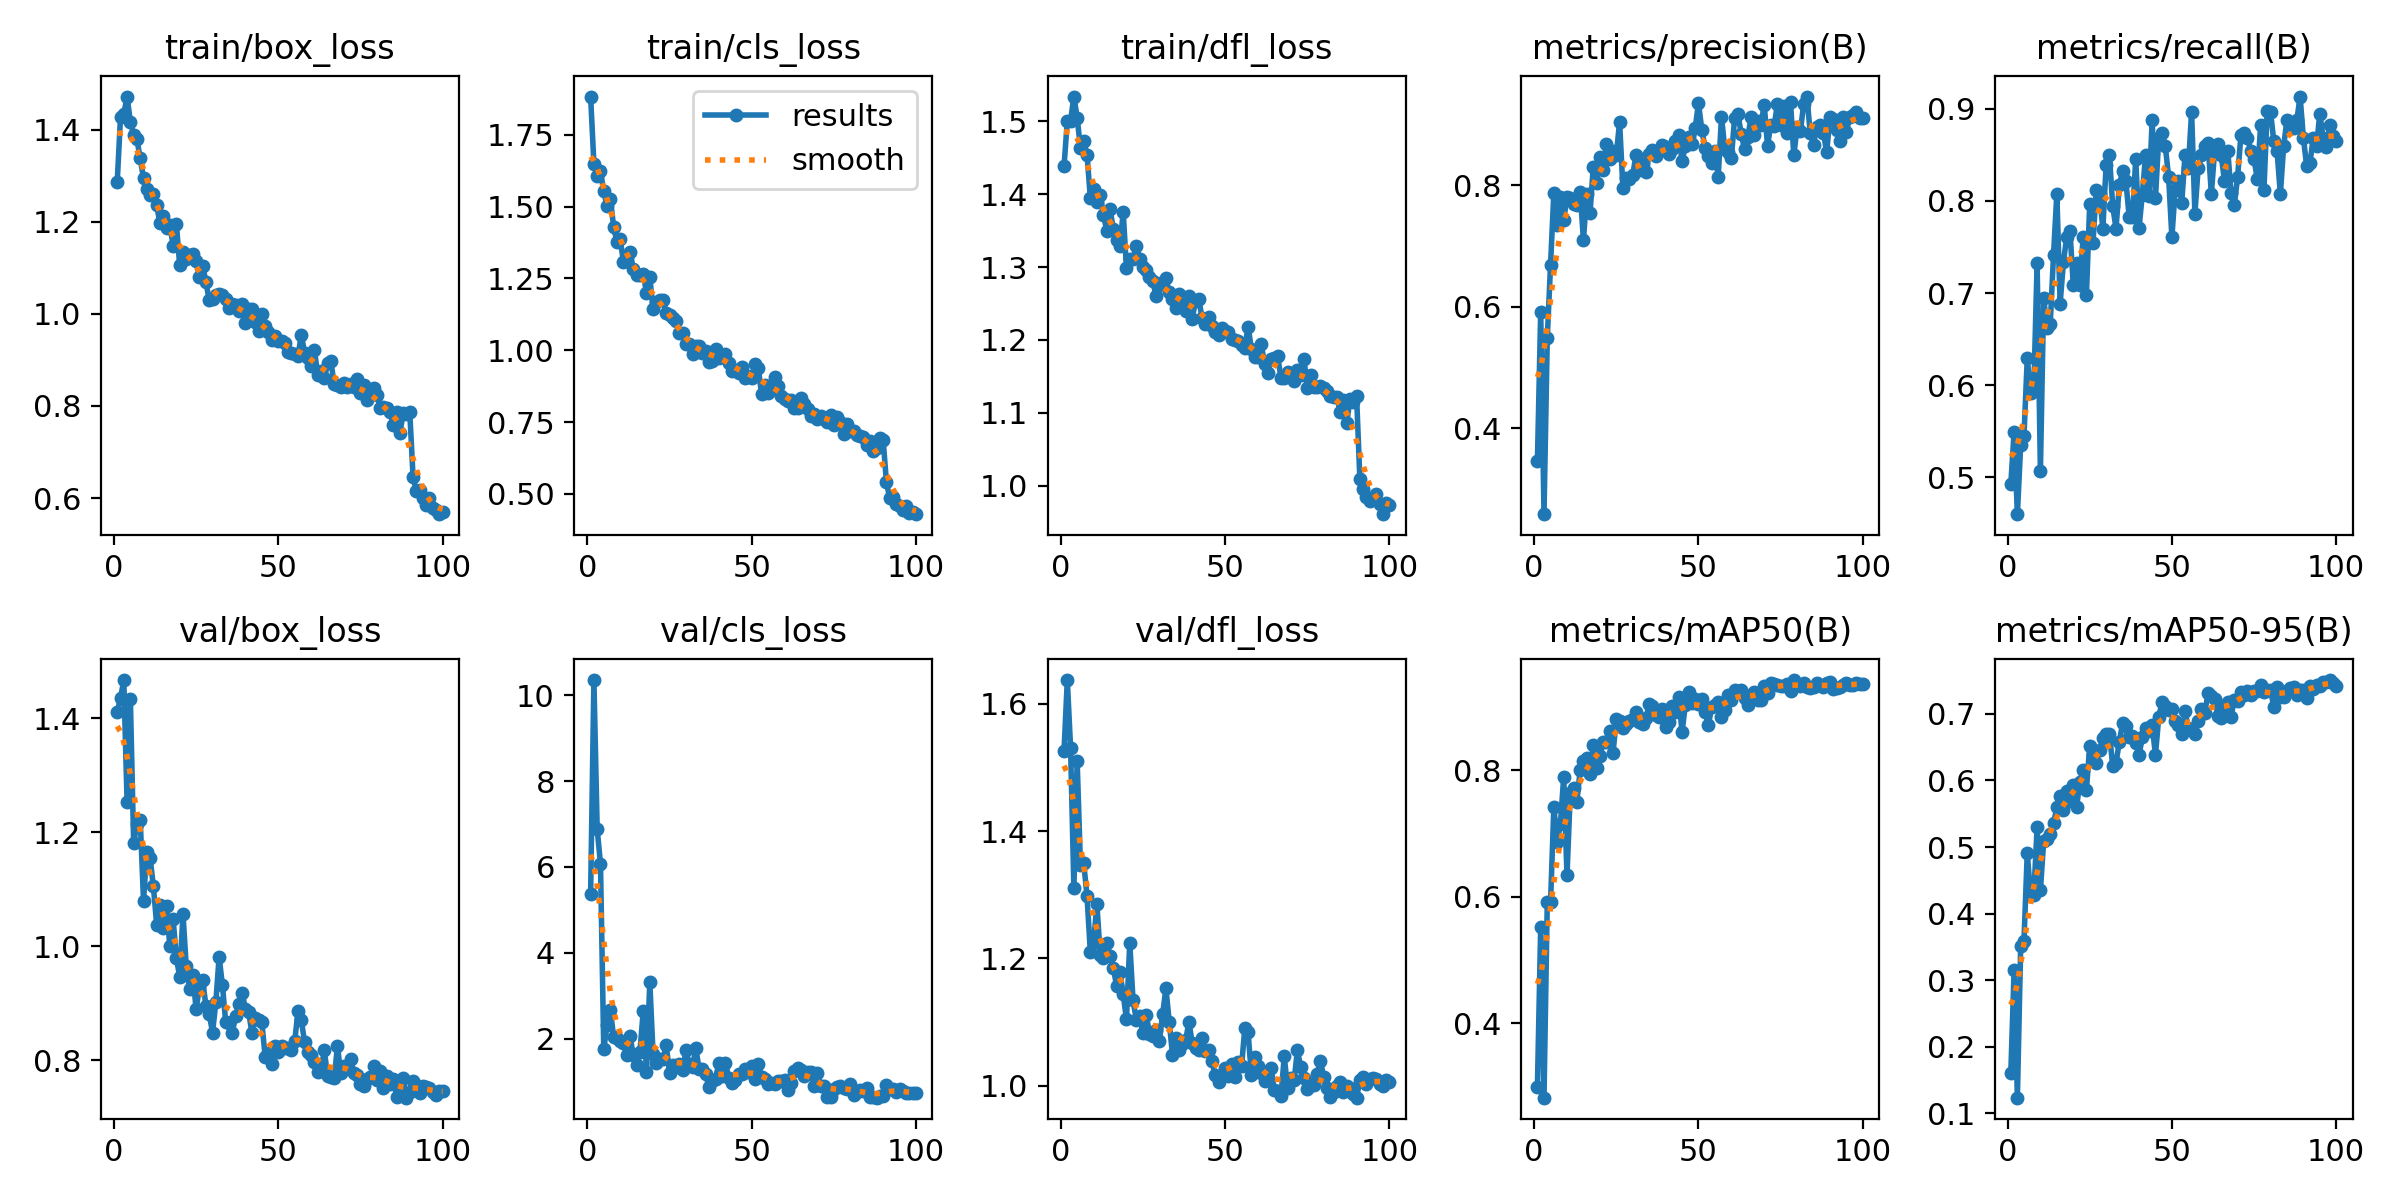

In [ ]:
from IPython.display import Image, display
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/results.png', width=600)

[Errno 2] No such file or directory: '/content/runs/detect/train2'
/content/runs/detect/train


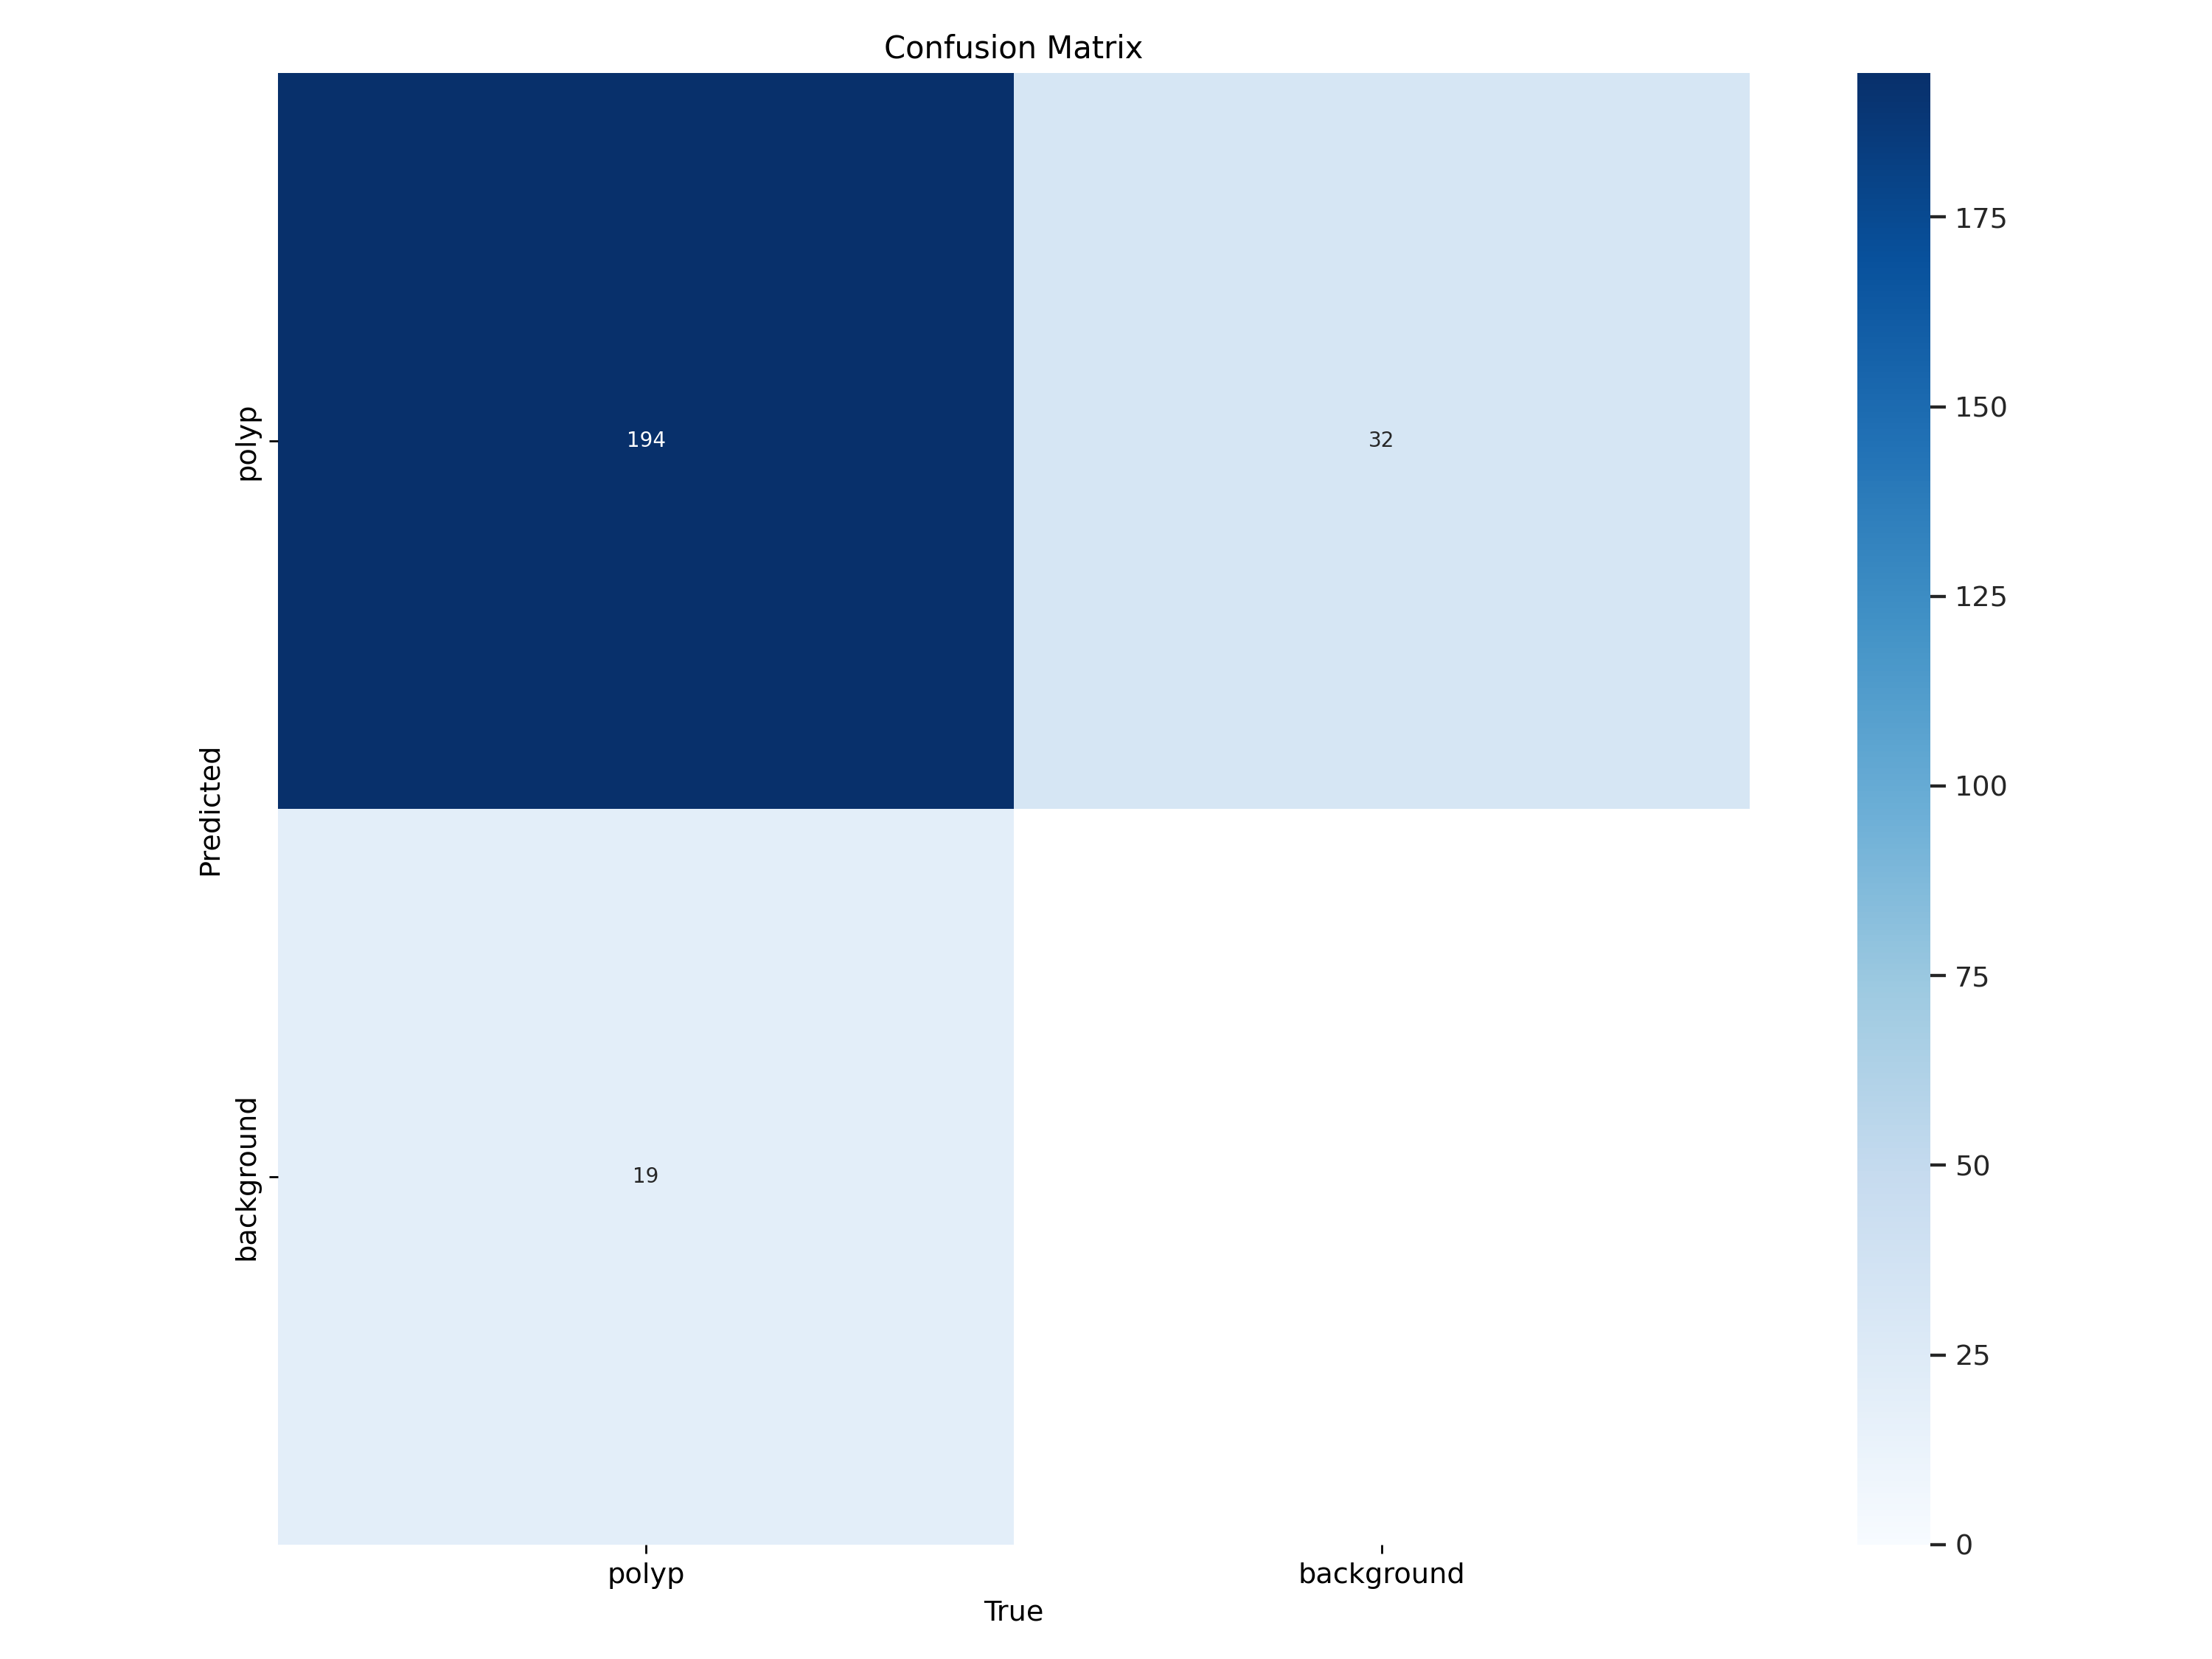

In [ ]:
%cd /content/runs/detect/train2
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

/content/runs/detect/train


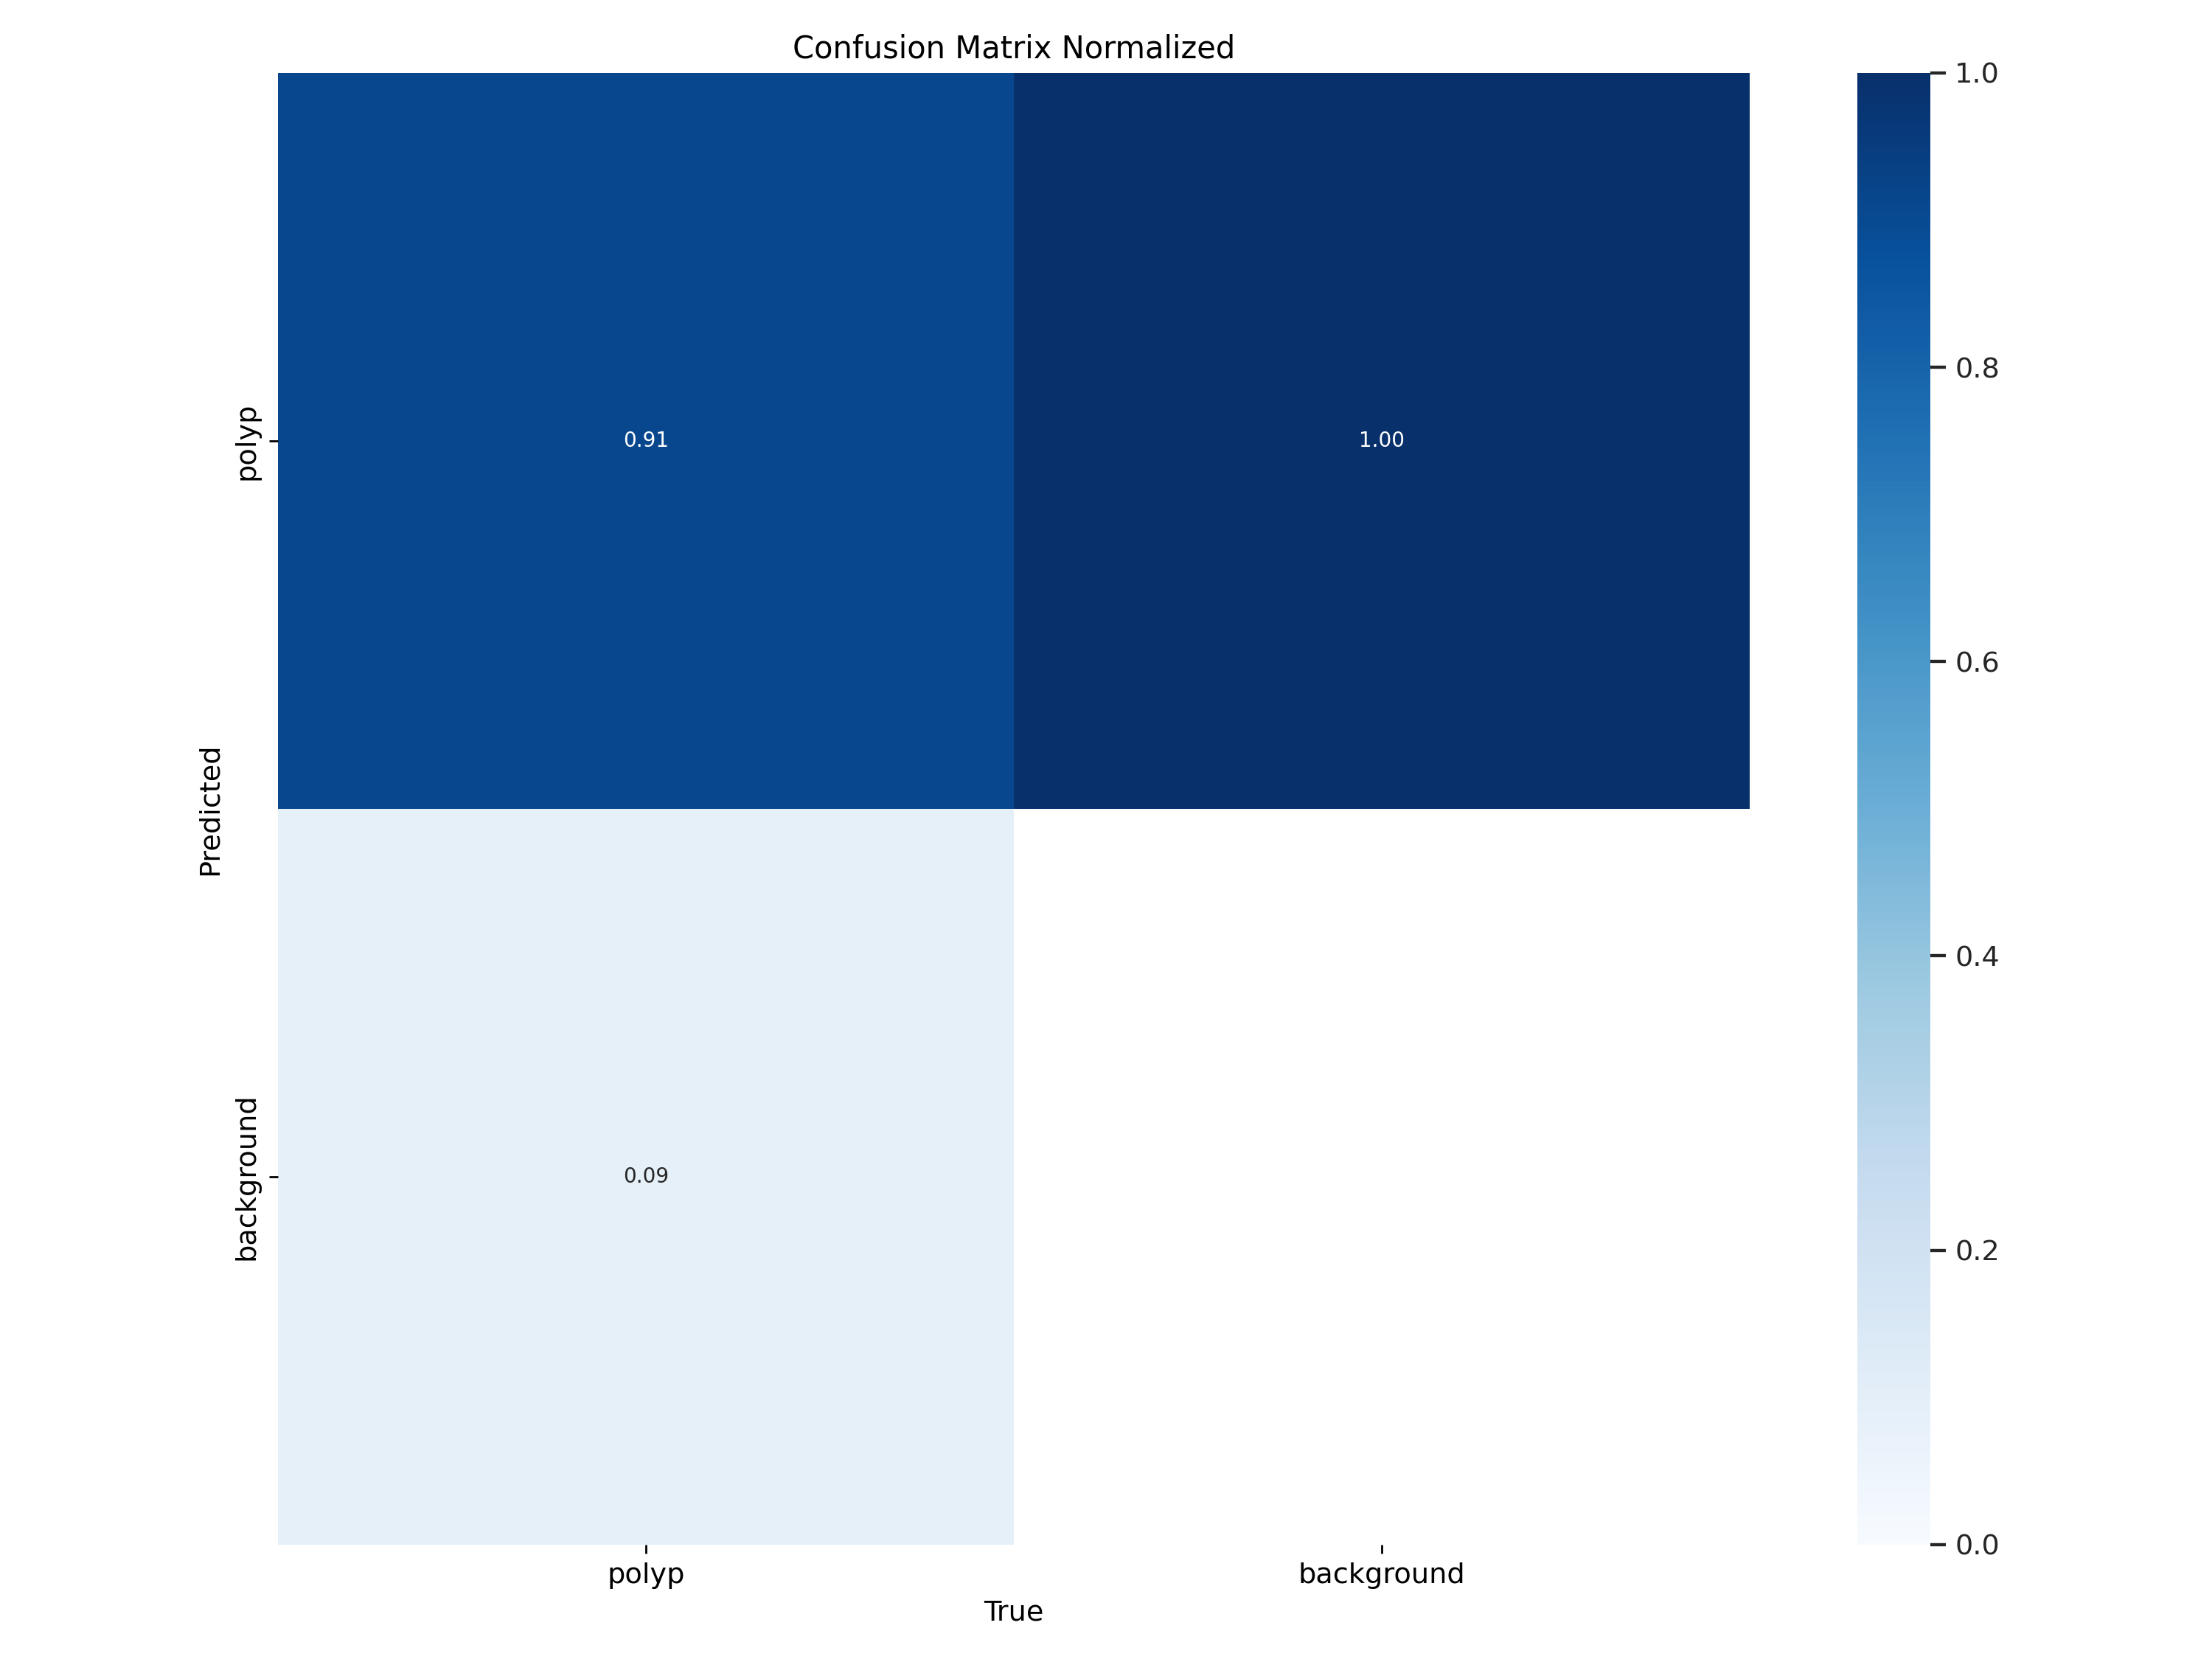

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/confusion_matrix_normalized.png', width=600)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/dataset3.yaml project=/content/runs/detect name=val   conf=0.5 iou=0.5

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1337.3±288.3 MB/s, size: 25.2 KB)
val: Scanning /content/dataset_split_HR_AGC_kvrs_1gt_rem/labels/val.cache... 213 images, 23 backgrounds, 0 corrupt: 100% 236/236 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 15/15 [00:01<00:00,  8.56it/s]
                   all        236        213      0.934      0.869      0.919      0.776
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


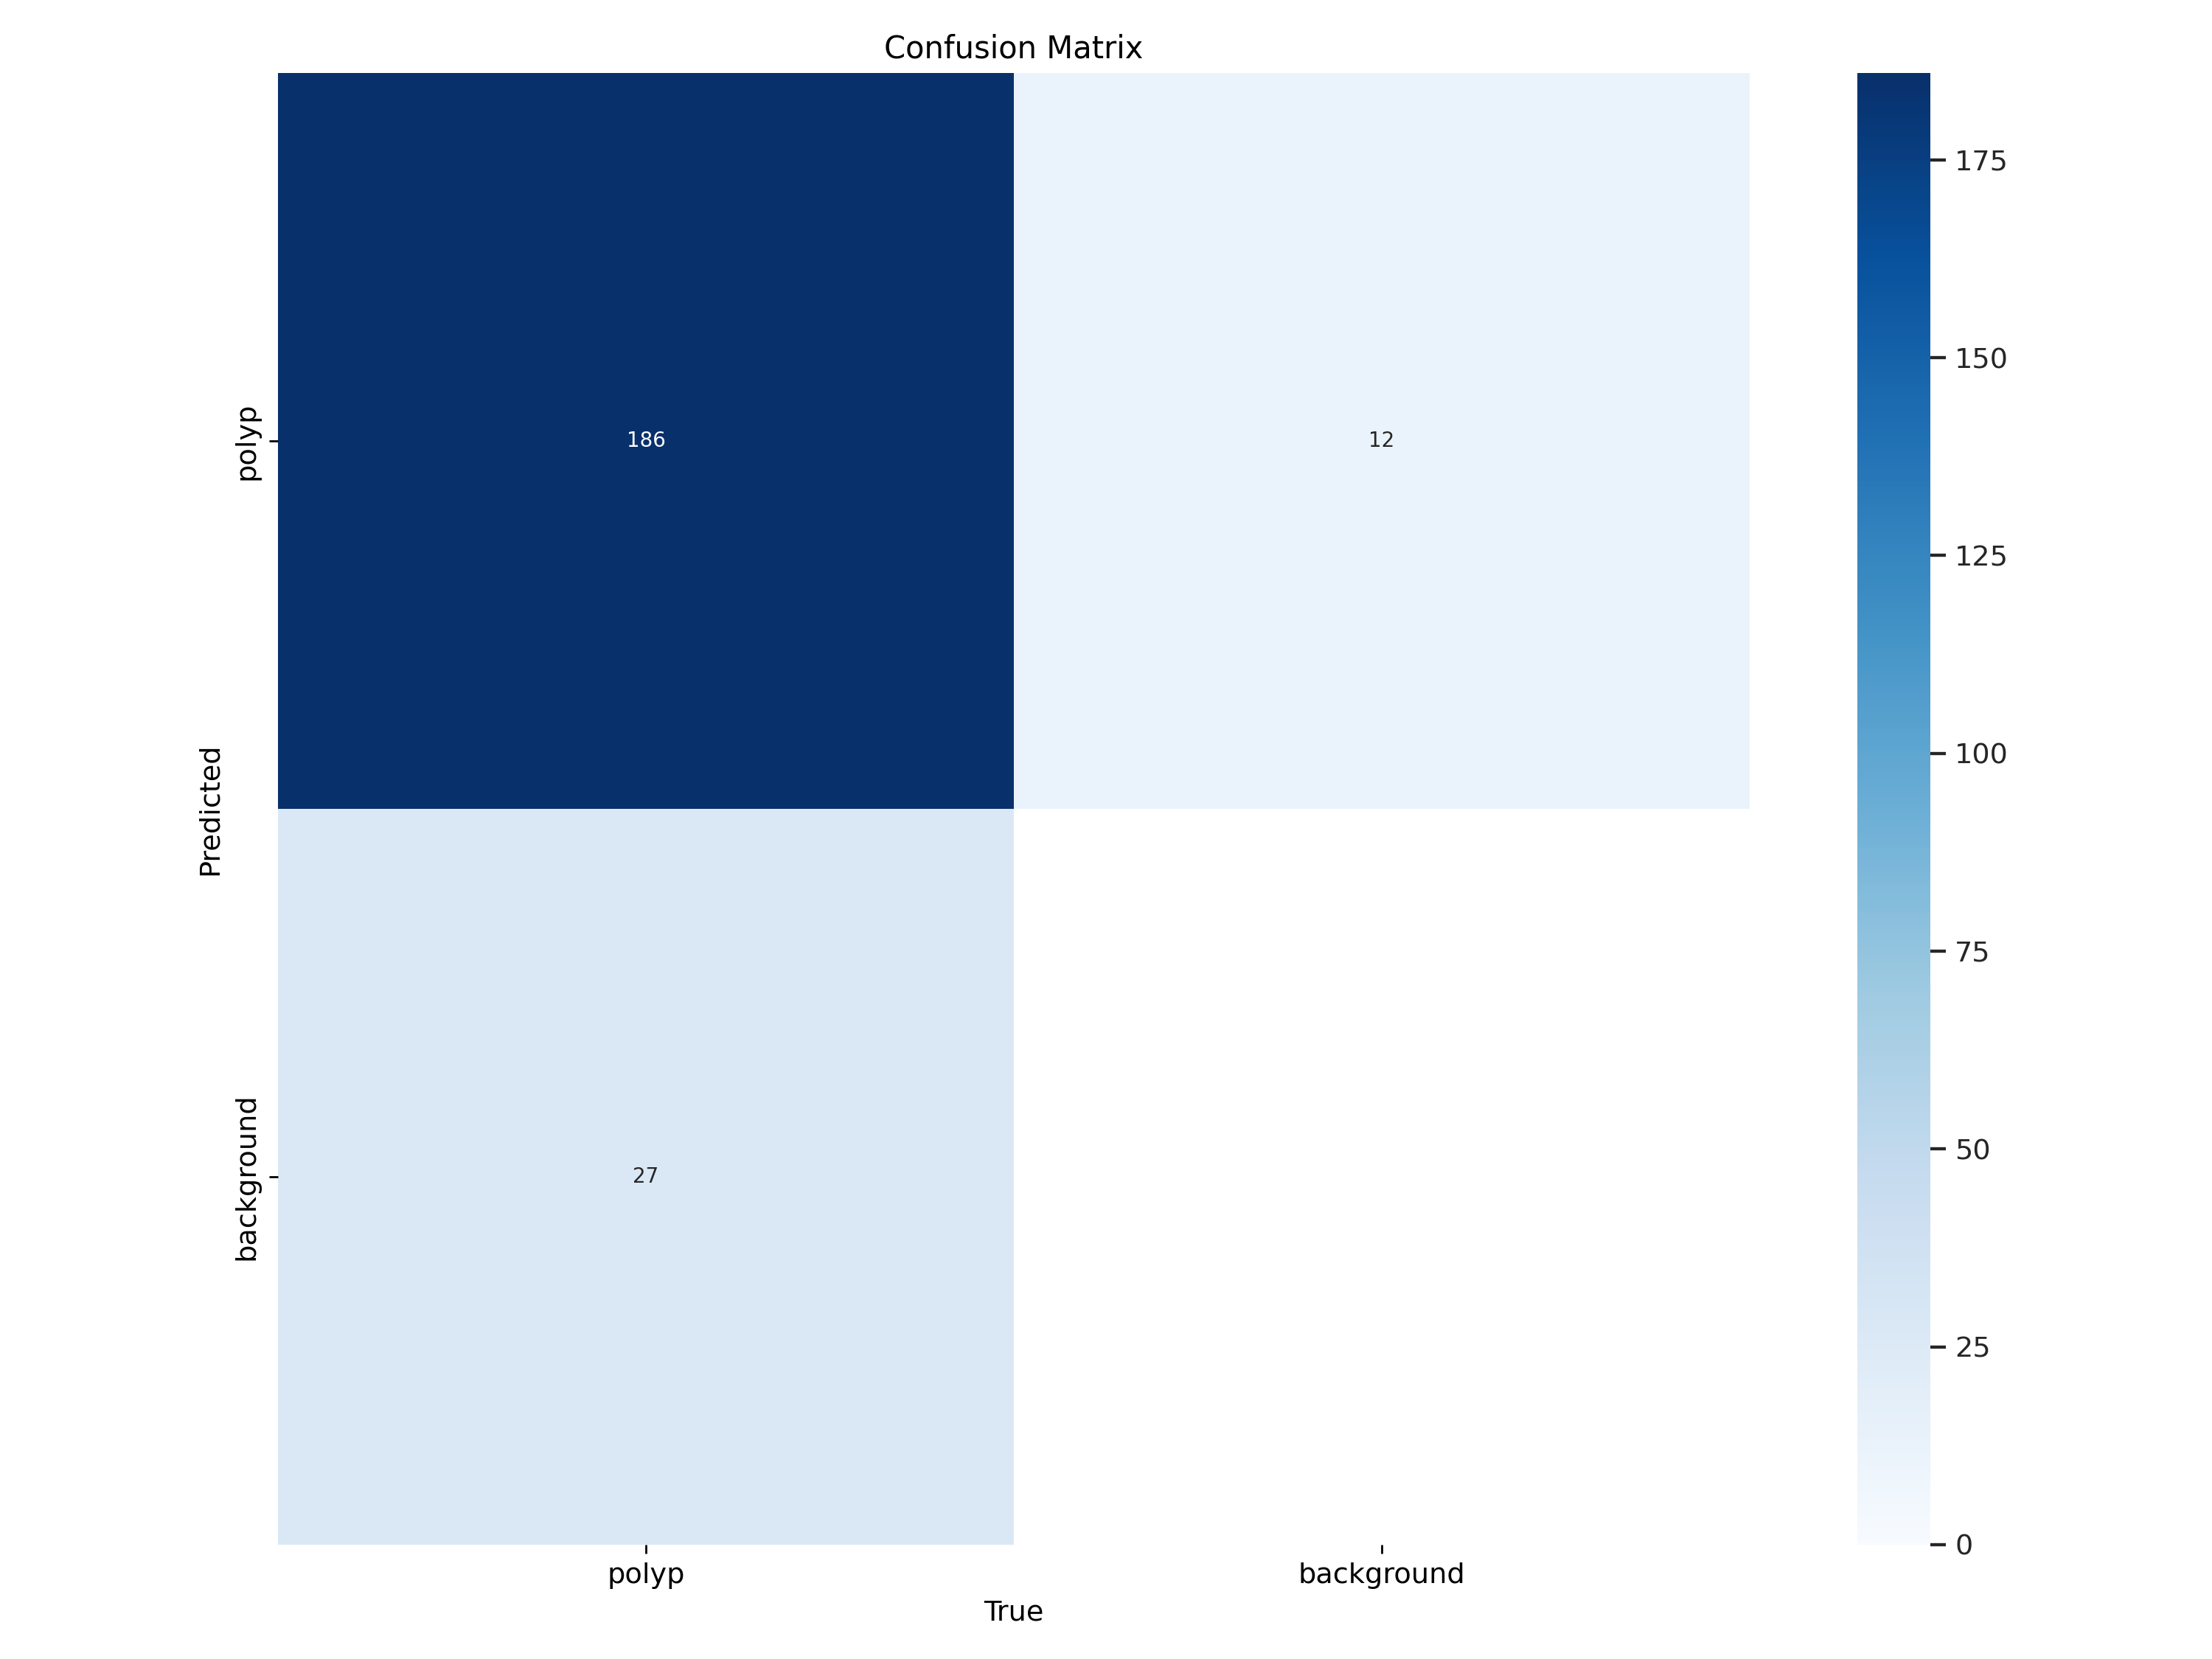

In [ ]:
Image(filename=f'/content/runs/detect/val/confusion_matrix.png', width=600)

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.5 iou=0.5 source=/content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test project=/content/runs/detect name=predict save=True save_txt=True save_conf=True

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/121 /content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test/202212150007C042.jpg: 256x256 (no detections), 11.7ms
image 2/121 /content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test/202302240107C034.jpg: 256x256 (no detections), 7.8ms
image 3/121 /content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test/202303210154C022.jpg: 256x256 (no detections), 7.8ms
image 4/121 /content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test/202304100178C031.jpg: 256x256 (no detections), 7.3ms
image 5/121 /content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test/202305050217C032.jpg: 256x256 (no detections), 7.1ms
image 6/121 /content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test/202306220283C013.jpg: 256x256 (no detections), 7.4ms
image 7/121 /content/dataset_split_HR_AGC_kvrs_1gt_rem/images/test/202310030463C068.jpg: 256x256 (no detections

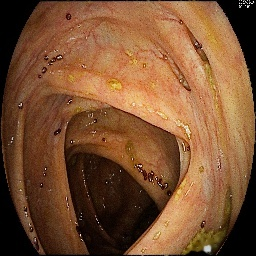

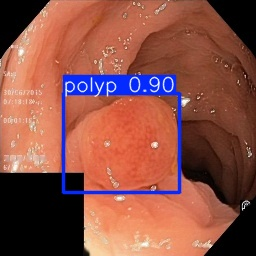

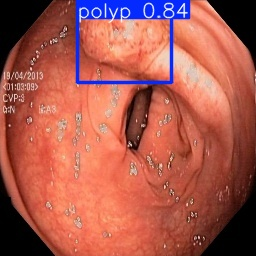

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'/content/runs/detect/predict'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=300))
    print("\n")

####test

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from collections import defaultdict

def compute_iou(box1, box2):
    """Menghitung IoU antara dua bounding box: [x_center, y_center, w, h]"""
    def to_corners(box):
        x, y, w, h = box
        return [x - w/2, y - h/2, x + w/2, y + h/2]

    box1 = to_corners(box1)
    box2 = to_corners(box2)

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append((cls, bbox))
    return labels

def evaluate(pred_dir, gt_dir, iou_threshold=0.5):
    predictions = []
    for pred_file in glob.glob(f"{pred_dir}/*.txt"):
        filename = os.path.basename(pred_file)
        image_id = filename.replace('.txt', '')
        gt_file = os.path.join(gt_dir, filename)

        pred_labels = []
        with open(pred_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                bbox = list(map(float, parts[1:5]))
                conf = float(parts[5]) if len(parts) > 5 else 1.0  # asumsikan confidence = 1.0 jika tidak tersedia
                pred_labels.append((image_id, cls, conf, bbox))
        predictions.extend(pred_labels)

    predictions.sort(key=lambda x: x[2], reverse=True)  # sort by confidence
    class_gt_counts = defaultdict(int)
    gt_boxes = defaultdict(list)

    for gt_file in glob.glob(f"{gt_dir}/*.txt"):
        image_id = os.path.basename(gt_file).replace('.txt', '')
        for cls, bbox in load_labels(gt_file):
            gt_boxes[(image_id, cls)].append({'bbox': bbox, 'used': False})
            class_gt_counts[cls] += 1

    stats = []
    acc_tp = 0
    acc_fp = 0

    for image_id, cls, conf, pred_box in predictions:
        matched = False
        candidates = gt_boxes.get((image_id, cls), [])
        for gt in candidates:
            if not gt['used']:
                iou = compute_iou(pred_box, gt['bbox'])
                if iou >= iou_threshold:
                    gt['used'] = True
                    matched = True
                    break

        tp = 1 if matched else 0
        fp = 0 if matched else 1

        acc_tp += tp
        acc_fp += fp

        precision = acc_tp / (acc_tp + acc_fp) if (acc_tp + acc_fp) > 0 else 0
        recall = acc_tp / sum(class_gt_counts.values()) if sum(class_gt_counts.values()) > 0 else 0

        stats.append([image_id, cls, conf, tp, fp, acc_tp, acc_fp, precision, recall])

    df = pd.DataFrame(stats, columns=["Image", "Class", "Confidence", "TP", "FP", "Acc TP", "Acc FP", "Precision", "Recall"])
    return df

# Contoh pemanggilan:
pred_dir = '/content/runs/detect/predict/labels'
gt_dir = '/content/dataset_split_HR_AGC_kvrs_1gt_rem/labels/test'
df_metrics = evaluate(pred_dir, gt_dir)
df_metrics.to_csv("/content/detection_metrics_HR_AGC_1gt_rem.csv", index=False)


Total Ground Truth: 108
Final Precision: 0.9479
Final Recall: 0.8426
Final F1-Score: 0.8922


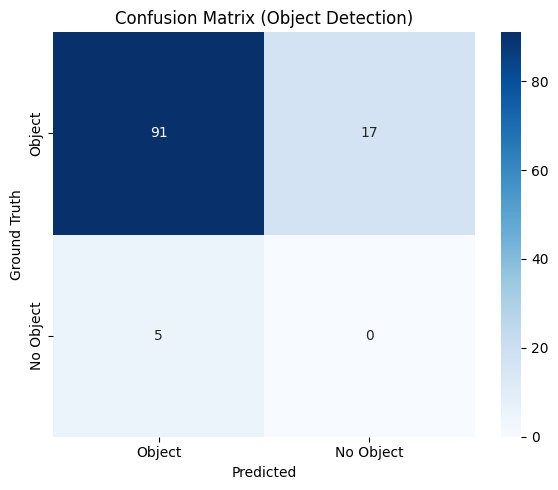

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def count_total_groundtruth(gt_dir):
    """
    Menghitung total jumlah bounding box (ground truth) dari folder label YOLO.

    Args:
        gt_dir (str): Path ke folder label ground truth (YOLO format)

    Returns:
        int: Total jumlah ground truth bounding box
    """
    total_gt = 0
    for file_name in os.listdir(gt_dir):
        if file_name.endswith('.txt'):
            file_path = os.path.join(gt_dir, file_name)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_gt += len(lines)
    return total_gt
gt_dir = '/content/dataset_split_HR_AGC_kvrs_1gt_rem/labels/test'
total_gt = count_total_groundtruth(gt_dir)
print(f"Total Ground Truth: {total_gt}")

def compute_final_metrics(df: pd.DataFrame, total_gt: int):
    """
    Menghitung TP, FP, FN, Precision, Recall, dan F1-score dari DataFrame hasil evaluasi.

    Args:
        df (pd.DataFrame): DataFrame berisi kolom ['TP', 'FP'] untuk masing-masing prediksi
        total_gt (int): Jumlah total ground truth (box sebenarnya)

    Returns:
        dict: Confusion matrix dan metrik evaluasi
    """
    tp = df['TP'].sum()
    fp = df['FP'].sum()
    fn = total_gt - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }
# Misalnya 'eval_df' adalah DataFrame berisi kolom ['TP', 'FP']
final_result = compute_final_metrics(df_metrics, total_gt)

print(f"Final Precision: {final_result['Precision']}")
print(f"Final Recall: {final_result['Recall']}")
print(f"Final F1-Score: {final_result['F1 Score']}")

tp = final_result['True Positive (TP)']
fp = final_result['False Positive (FP)']
fn = final_result['False Negative (FN)']
tn = 0  # TN tidak dihitung dalam object detection
# Plot confusion matrix
conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

labels = ['Object', 'No Object']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix (Object Detection)')
plt.tight_layout()
plt.show()

##AGC

####kvasir

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_AGC_kvasir_seg_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_AGC_kvasir_seg_1gt_removed.zip -d /content/output_AGC_kvasir_seg_1gt_removed/


Archive:  /content/output_AGC_kvasir_seg_1gt_removed.zip
   creating: /content/output_AGC_kvasir_seg_1gt_removed/bboxes/
   creating: /content/output_AGC_kvasir_seg_1gt_removed/images/
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-347.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-204.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-911.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-79.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-709.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-870.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-919.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-646.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-812.jpg  
  inflating: /content/output_AGC_kvasir_seg_1gt_removed/images/kv-seg-692.jpg  
  inflating: /co

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_AGC_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_AGC_RSUA_1gt_removed.zip -d /content/output_AGC_RSUA_1gt_removed/


Archive:  /content/output_AGC_RSUA_1gt_removed.zip
   creating: /content/output_AGC_RSUA_1gt_removed/bboxes/
   creating: /content/output_AGC_RSUA_1gt_removed/images/
  inflating: /content/output_AGC_RSUA_1gt_removed/images/2_polyp-1-_202301260065C071.jpg  
  inflating: /content/output_AGC_RSUA_1gt_removed/images/4_polyp-1-_202307170329C049.jpg  
  inflating: /content/output_AGC_RSUA_1gt_removed/images/3_polyp-1-_asli_202405160871C094.jpg  
  inflating: /content/output_AGC_RSUA_1gt_removed/images/4_polyp-1-_202406050908C006.jpg  
  inflating: /content/output_AGC_RSUA_1gt_removed/images/4_polyp-1-_202409191126C010.jpg  
  inflating: /content/output_AGC_RSUA_1gt_removed/images/3_polyp-1-_202306270295C062.jpg  
  inflating: /content/output_AGC_RSUA_1gt_removed/images/polyp-1-_202305050217C020.jpg  
  inflating: /content/output_AGC_RSUA_1gt_removed/images/6_polyp-1-_asli_202402190736C019.jpg  
  inflating: /content/output_AGC_RSUA_1gt_removed/images/6_polyp-1-_202306270295C049.jpg  
  infl

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_AGC_normal_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_AGC_normal_RSUA_1gt_removed.zip -d /content/output_AGC_normal_RSUA_1gt_removed/


Archive:  /content/output_AGC_normal_RSUA_1gt_removed.zip
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202405200875C070.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202409051095C040.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202412311348C043.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202405130861C015.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202402020707C059.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202306270295C027.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202310030465C060.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202306270295C045.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202305090219C035.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202407291035C086.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/202409191126C006.jpg  
  inflating: /content/output_AGC_normal_RSUA_1gt_removed/20230

In [ ]:
# Path ke folder output (misalnya, 'dataset_split' di direktori saat ini)
output_path = 'dataset_split_AGC_kvrs_1gt_rem'

# Membuat folder output
os.makedirs(output_path, exist_ok=True)

In [ ]:
import pandas as pd
import os
import random
from glob import glob
import shutil


def split_dataset1(images_path, labels_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Memastikan rasio pembagian data totalnya 1.0
    # assert train_ratio + val_ratio + test_ratio == 1.0, "Total rasio train, val, dan test harus 1.0"

    # Membuat folder output untuk train, val, dan test
    os.makedirs(os.path.join(output_path, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'test'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'test'), exist_ok=True)

    # Dapatkan semua file gambar
    image_files = glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png"))

    # Pastikan ada file gambar
    assert len(image_files) > 0, "Tidak ada file gambar yang ditemukan."

    # Mengacak urutan file
    random.shuffle(image_files)

    # Hitung jumlah file untuk setiap set
    total_images = len(image_files)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)

    # Bagi dataset menjadi train, val, dan test
    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + val_count]
    test_images = image_files[train_count + val_count:]

    # Fungsi untuk menyalin file ke direktori tujuan dan mengonversi label
    def copy_files(image_set, subset):
        for img_file in image_set:
            # Salin file gambar
            shutil.copy(img_file, os.path.join(output_path, 'images', subset, os.path.basename(img_file)))

            # Salin file label dengan ekstensi CSV jika ada
            label_file_path = os.path.join(labels_path, os.path.splitext(os.path.basename(img_file))[0] + '.txt')
            if os.path.exists(label_file_path):
                #convert_csv_to_yolo(label_file_path, img_file, os.path.join(output_path, 'labels', subset))
                shutil.copy(label_file_path, os.path.join(output_path, 'labels', subset, os.path.basename(label_file_path)))
            else:
                print(f"Warning: Label tidak ditemukan untuk {img_file}")

    # Menyalin file ke direktori train, val, dan test
    copy_files(train_images, 'train')
    copy_files(val_images, 'val')
    copy_files(test_images, 'test')

    print(f"Dataset dibagi menjadi train ({len(train_images)}), val ({len(val_images)}), dan test ({len(test_images)})")


In [ ]:
# Contoh penggunaan
images_path = '/content/output_AGC_normal_RSUA_1gt_removed'
images_path1 = '/content/output_AGC_kvasir_seg_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path1 = '/content/output_AGC_kvasir_seg_1gt_removed/bboxes'  # Path ke folder yang berisi semua file anotasi
images_path11 = '/content/output_AGC_RSUA_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path11 = '/content/output_AGC_RSUA_1gt_removed/bboxes'
output_path = '/content/dataset_split_AGC_kvrs_1gt_rem'  # Path ke folder tujuan untuk dataset yang telah dipisah

split_dataset1(images_path1, labels_path1, output_path)
split_dataset1(images_path11, labels_path11, output_path)
split_normal_dataset (images_path, output_path)

Dataset dibagi menjadi train (665), val (190), dan test (95)
Dataset dibagi menjadi train (83), val (23), dan test (13)
Dataset normal berhasil dibagi ke folder yang sudah ada: train (83), val (23), test (13)


In [ ]:
# Inisialisasi counter
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_AGC_kvrs_1gt_rem/images/train'):
    if file_name.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_AGC_kvrs_1gt_rem/labels/train'):
    if file_name.endswith(('.txt')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")

Jumlah file gambar dalam folder: 831
Jumlah file gambar dalam folder: 748


In [ ]:
import yaml

# Data untuk file YAML
dataset = {
    'train': '/content/dataset_split_AGC_kvrs_1gt_rem/images/train',  # Ubah sesuai path ke folder gambar train Anda
    'val': '/content/dataset_split_AGC_kvrs_1gt_rem/images/val',      # Ubah sesuai path
    'test': '/content/dataset_split_AGC_kvrs_1gt_rem/images/test',
    'nc': 1,  # Jumlah kelas
    'names': ['polyp']  # Nama-nama kelas
}

# Path untuk menyimpan file YAML
yaml_file = '/content/dataset4.yaml'

# Menulis file YAML
with open(yaml_file, 'w') as file:
    yaml.dump(dataset, file)

print(f"File YAML dataset berhasil dibuat: {yaml_file}")


File YAML dataset berhasil dibuat: /content/dataset4.yaml


###model

In [ ]:
# Load a model
model2 = YOLO("yolo11s.pt")

# Train the model
train_results = model2.train(
    data="/content/dataset4.yaml",  # path to dataset YAML
    epochs=100,             # max epoch
    imgsz=256,
    batch=8,
    device=0,
    project="/content/runs/detect",  # direktori utama penyimpanan
    name="train",                   # subfolder hasil training
    exist_ok=True                    # tidak error jika folder sudah ada
    #patience=10,            # Early stopping if no improvement in 10 epochs
    #verbose=True
)

# Evaluate model performance on the validation set
#metrics = model.val()

100%|██████████| 18.4M/18.4M [00:00<00:00, 84.4MB/s]


Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset4.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

100%|██████████| 755k/755k [00:00<00:00, 24.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           


  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 843.0±332.6 MB/s, size: 30.0 KB)


train: Scanning /content/dataset_split_AGC_kvrs_1gt_rem/labels/train... 748 images, 83 backgrounds, 0 corrupt: 100%|██████████| 831/831 [00:00<00:00, 1858.88it/s]

train: New cache created: /content/dataset_split_AGC_kvrs_1gt_rem/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 589.2±325.9 MB/s, size: 23.6 KB)


val: Scanning /content/dataset_split_AGC_kvrs_1gt_rem/labels/val... 213 images, 23 backgrounds, 0 corrupt: 100%|██████████| 236/236 [00:00<00:00, 943.43it/s] 

val: New cache created: /content/dataset_split_AGC_kvrs_1gt_rem/labels/val.cache


Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.568G      1.288       1.93      1.473         11        256: 100%|██████████| 104/104 [00:13<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]

                   all        236        214     0.0123      0.776     0.0119      0.007



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.641G      1.413      1.638      1.499         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.43it/s]

                   all        236        214      0.531      0.597      0.591      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.682G      1.451       1.62      1.523         19        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.81it/s]

                   all        236        214      0.624      0.467      0.515      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      0.75G      1.467      1.616      1.529         12        256: 100%|██████████| 104/104 [00:12<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.74it/s]

                   all        236        214      0.466      0.453      0.406       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.791G      1.491      1.674      1.581         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.79it/s]

                   all        236        214      0.155     0.0627     0.0339      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.861G      1.418      1.625      1.522         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.55it/s]

                   all        236        214      0.739      0.556      0.649      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.902G      1.358      1.534      1.482         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.09it/s]

                   all        236        214      0.787      0.622      0.747      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.941G      1.334      1.457      1.475         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.94it/s]

                   all        236        214      0.733      0.696      0.741      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         1G      1.309      1.383      1.433         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.67it/s]

                   all        236        214      0.811      0.642      0.755      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.09G      1.312      1.414      1.465         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.83it/s]

                   all        236        214      0.681      0.598      0.661      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.13G      1.287      1.404      1.451         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.87it/s]

                   all        236        214       0.82      0.661      0.759      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.17G      1.291      1.363      1.448          8        256: 100%|██████████| 104/104 [00:11<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.80it/s]

                   all        236        214      0.756      0.738        0.8      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.24G       1.24      1.322      1.414          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.11it/s]

                   all        236        214      0.797      0.567       0.71      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.28G      1.207      1.232      1.365         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.48it/s]

                   all        236        214      0.783      0.673      0.742      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.34G      1.191       1.24      1.375          8        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.75it/s]

                   all        236        214      0.875      0.715      0.838      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.38G      1.208      1.276      1.378          8        256: 100%|██████████| 104/104 [00:11<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.08it/s]

                   all        236        214       0.79      0.743      0.797      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.44G      1.209      1.249      1.375         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.98it/s]

                   all        236        214      0.809      0.762      0.821      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.49G       1.18       1.22      1.387          7        256: 100%|██████████| 104/104 [00:11<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.19it/s]

                   all        236        214       0.81      0.757      0.845      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.55G      1.182      1.263      1.367         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.31it/s]

                   all        236        214      0.873      0.762      0.851       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.61G      1.108      1.131       1.32         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.94it/s]

                   all        236        214      0.719      0.771      0.811      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.65G      1.145      1.153      1.363          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.97it/s]

                   all        236        214      0.864      0.743      0.847      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.71G      1.145      1.186      1.363          8        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.82it/s]

                   all        236        214      0.846      0.762      0.845      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       1.8G      1.117      1.187       1.34         17        256: 100%|██████████| 104/104 [00:11<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

                   all        236        214      0.763      0.827      0.849      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.84G      1.111      1.147      1.321         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.33it/s]

                   all        236        214      0.729      0.792      0.816      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.88G      1.112       1.13      1.327         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.12it/s]

                   all        236        214       0.79      0.776      0.842      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.94G      1.079       1.09      1.301         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.12it/s]

                   all        236        214      0.829      0.827      0.867       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.98G      1.098      1.044      1.308         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.19it/s]

                   all        236        214      0.858       0.79      0.862      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.05G      1.075      1.107      1.303         10        256: 100%|██████████| 104/104 [00:12<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.31it/s]

                   all        236        214      0.877      0.776       0.87      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.09G       1.08      1.051      1.284         16        256: 100%|██████████| 104/104 [00:10<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]

                   all        236        214      0.871      0.757      0.848      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.16G      1.065      1.048      1.313         14        256: 100%|██████████| 104/104 [00:10<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.30it/s]

                   all        236        214      0.884      0.771      0.854      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.2G      1.065      1.014      1.282         13        256: 100%|██████████| 104/104 [00:10<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.18it/s]

                   all        236        214      0.847       0.78      0.858      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.27G      1.059      1.019      1.268         14        256: 100%|██████████| 104/104 [00:10<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]

                   all        236        214      0.817      0.799      0.867      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.31G      1.055      1.045      1.289         12        256: 100%|██████████| 104/104 [00:10<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.64it/s]

                   all        236        214      0.852      0.762      0.862      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.37G      1.061      1.059      1.304         17        256: 100%|██████████| 104/104 [00:10<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]

                   all        236        214      0.875      0.788      0.881      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.44G      1.009      1.002      1.273         17        256: 100%|██████████| 104/104 [00:10<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.59it/s]

                   all        236        214      0.893      0.783      0.857      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.48G      1.012     0.9767       1.26         16        256: 100%|██████████| 104/104 [00:10<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.58it/s]

                   all        236        214       0.87      0.812      0.873      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.55G      1.034      1.011      1.277         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.43it/s]

                   all        236        214      0.864      0.799      0.876      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.59G      1.032     0.9671      1.263         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.19it/s]

                   all        236        214      0.859       0.85      0.896      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.63G      1.016     0.9629      1.268         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.45it/s]

                   all        236        214      0.874      0.827      0.885      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.69G      1.002     0.9716      1.256         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.32it/s]

                   all        236        214      0.834      0.845      0.877      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.78G     0.9505     0.9055       1.24          8        256: 100%|██████████| 104/104 [00:11<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.40it/s]

                   all        236        214      0.879      0.785       0.87       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.81G     0.9577     0.9235      1.227         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.38it/s]

                   all        236        214      0.879      0.817      0.871      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.86G     0.9859     0.9137      1.252         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.27it/s]

                   all        236        214      0.877       0.83      0.883      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.93G     0.9907     0.9054      1.272         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.79it/s]

                   all        236        214      0.877      0.855      0.901      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.96G     0.9979     0.8927      1.254         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.47it/s]

                   all        236        214      0.869      0.841        0.9      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.04G       0.98     0.9606      1.237         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.47it/s]

                   all        236        214       0.84       0.81       0.87       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.08G     0.9347     0.8969      1.217         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

                   all        236        214       0.81      0.841      0.869      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.14G     0.9614      0.914      1.232         18        256: 100%|██████████| 104/104 [00:11<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.56it/s]

                   all        236        214      0.855      0.824      0.875      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.2G      0.946     0.9152      1.216         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.53it/s]

                   all        236        214      0.888      0.817      0.883      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.28G     0.9248     0.8549      1.217         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.51it/s]

                   all        236        214      0.879      0.832       0.89      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.35G     0.9386     0.8817      1.224         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.05it/s]

                   all        236        214      0.904      0.827      0.895      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.39G     0.9218     0.8533      1.219          7        256: 100%|██████████| 104/104 [00:10<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]

                   all        236        214      0.873      0.846      0.897      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.43G     0.8926     0.8409      1.197         12        256: 100%|██████████| 104/104 [00:10<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]

                   all        236        214      0.937      0.836      0.912      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.47G     0.9379     0.8687      1.235         13        256: 100%|██████████| 104/104 [00:10<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.12it/s]

                   all        236        214      0.898      0.822      0.894      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.56G      0.934     0.8519      1.214          6        256: 100%|██████████| 104/104 [00:10<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]

                   all        236        214      0.867      0.827      0.891      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       3.6G     0.9326     0.8291      1.219         15        256: 100%|██████████| 104/104 [00:10<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.63it/s]

                   all        236        214      0.856      0.834      0.908      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.64G     0.9138      0.801      1.202         14        256: 100%|██████████| 104/104 [00:12<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.66it/s]

                   all        236        214      0.907      0.841      0.905      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.68G      0.888     0.7959      1.193         17        256: 100%|██████████| 104/104 [00:10<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.56it/s]

                   all        236        214      0.852      0.806      0.867       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.75G     0.9063      0.786      1.185         12        256: 100%|██████████| 104/104 [00:10<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]

                   all        236        214      0.876      0.827      0.894      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.79G     0.8928     0.7848      1.197          9        256: 100%|██████████| 104/104 [00:10<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.16it/s]

                   all        236        214      0.893      0.846      0.895      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.85G     0.8999     0.8197      1.195         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.10it/s]

                   all        236        214       0.89      0.818      0.896      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.89G     0.8621     0.7724      1.173         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

                   all        236        214      0.868      0.836      0.892      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.96G     0.9035        0.8      1.203         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.44it/s]

                   all        236        214      0.848      0.888      0.903      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         4G     0.8914     0.8087      1.198         17        256: 100%|██████████| 104/104 [00:11<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.81it/s]

                   all        236        214      0.913      0.813      0.896      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.07G     0.8783     0.7582      1.172         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.43it/s]

                   all        236        214      0.891      0.813      0.888      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.13G     0.8903     0.8043      1.194         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.27it/s]

                   all        236        214      0.897      0.857      0.896      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.21G      0.857     0.7672      1.169         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.27it/s]

                   all        236        214       0.91      0.832      0.895        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.25G     0.8458     0.7638      1.175          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.01it/s]

                   all        236        214        0.9      0.827      0.888      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.29G     0.8464     0.7358      1.165         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.69it/s]

                   all        236        214      0.901      0.848      0.895      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.37G     0.8224     0.7368      1.151         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.30it/s]

                   all        236        214      0.906      0.836      0.903      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.41G     0.8935     0.7688      1.196         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.32it/s]

                   all        236        214      0.864      0.836      0.879      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.45G     0.8693     0.7699      1.186         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.39it/s]

                   all        236        214      0.903      0.841      0.896      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.52G      0.848     0.7447      1.175          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.37it/s]

                   all        236        214      0.895      0.822      0.898      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.56G     0.8306     0.7483      1.157         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.84it/s]

                   all        236        214      0.895       0.85      0.918      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.62G     0.8386     0.7393      1.152         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.41it/s]

                   all        236        214      0.918      0.838      0.903      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.65G     0.8163     0.7187      1.145          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.42it/s]

                   all        236        214      0.908      0.818      0.899      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.73G     0.8103     0.6889       1.15          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.44it/s]

                   all        236        214       0.88      0.855      0.911      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.81G     0.8045     0.6826      1.131         18        256: 100%|██████████| 104/104 [00:11<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.43it/s]

                   all        236        214      0.923      0.879      0.918      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.85G     0.7952     0.6981      1.146         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.25it/s]

                   all        236        214      0.932       0.85      0.908      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.89G     0.7882     0.6818      1.145         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.50it/s]

                   all        236        214      0.876      0.874      0.913      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.93G     0.8074     0.7117      1.145          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.04it/s]

                   all        236        214      0.912      0.827      0.906      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.99G     0.7925     0.6624      1.134         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.14it/s]

                   all        236        214      0.912      0.874      0.915      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.05G     0.8146     0.6989      1.156         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.39it/s]

                   all        236        214      0.926      0.818      0.896      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.11G     0.7833     0.6859       1.13         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.52it/s]

                   all        236        214      0.906      0.815      0.892      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       5.2G     0.7914     0.6614      1.135         13        256: 100%|██████████| 104/104 [00:12<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]

                   all        236        214      0.914      0.836      0.909      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.24G      0.784     0.6576      1.119         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]

                   all        236        214      0.936       0.79      0.892        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.31G     0.7685     0.6317      1.125         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]

                   all        236        214      0.913      0.833      0.916      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.35G     0.8129     0.6615      1.143         12        256: 100%|██████████| 104/104 [00:10<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.63it/s]

                   all        236        214      0.901      0.847      0.903       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.39G     0.7495     0.6327      1.121          9        256: 100%|██████████| 104/104 [00:10<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]

                   all        236        214      0.907      0.821      0.904      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.47G     0.7539     0.6499      1.116         13        256: 100%|██████████| 104/104 [00:10<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.60it/s]

                   all        236        214      0.901      0.846      0.907      0.716


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.51G     0.6377     0.4967      1.028          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.23it/s]

                   all        236        214      0.892      0.855       0.91      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.55G     0.6427     0.4826      1.026          7        256: 100%|██████████| 104/104 [00:10<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.92it/s]

                   all        236        214      0.899       0.87      0.916      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.59G     0.6144     0.4585      1.004          5        256: 100%|██████████| 104/104 [00:10<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]

                   all        236        214      0.885      0.869       0.91       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.66G     0.5925      0.448     0.9928          7        256: 100%|██████████| 104/104 [00:10<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]

                   all        236        214      0.893      0.874      0.913      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       5.7G      0.621     0.4313       1.02          6        256: 100%|██████████| 104/104 [00:10<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.34it/s]

                   all        236        214      0.904      0.846       0.91      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.76G     0.6028     0.4374      1.007          7        256: 100%|██████████| 104/104 [00:10<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]

                   all        236        214      0.893      0.846       0.91      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.82G     0.5862      0.426     0.9992          6        256: 100%|██████████| 104/104 [00:10<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.04it/s]

                   all        236        214       0.88      0.856      0.911      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.88G     0.5982     0.4168     0.9933          6        256: 100%|██████████| 104/104 [00:10<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.11it/s]

                   all        236        214      0.869      0.867      0.906      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.92G     0.5695     0.4078     0.9777          6        256: 100%|██████████| 104/104 [00:11<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.12it/s]

                   all        236        214      0.885      0.864      0.906       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.01G     0.5724     0.4155      0.977          7        256: 100%|██████████| 104/104 [00:11<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.48it/s]

                   all        236        214      0.887      0.841      0.907      0.733



100 epochs completed in 0.367 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 19.1MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]


                   all        236        214      0.913      0.833      0.916      0.736
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/runs/detect/train


In [ ]:
import pandas as pd

# Path ke file hasil training YOLOv8
results_path = "/content/runs/detect/train/results.csv"

# Baca file hasil training
df = pd.read_csv(results_path)

# Hitung F1-score dari precision dan recall
df['f1_score'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])


# Simpan ke file baru CSV (bisa ditimpa file lama juga jika mau)
f1_output_path = "/content/runs/detect/train/results_with_f1.csv"
df.to_csv(f1_output_path, index=False)

print("F1-score berhasil disimpan ke:", f1_output_path)


F1-score berhasil disimpan ke: /content/runs/detect/train/results_with_f1.csv


/content/runs/detect/train


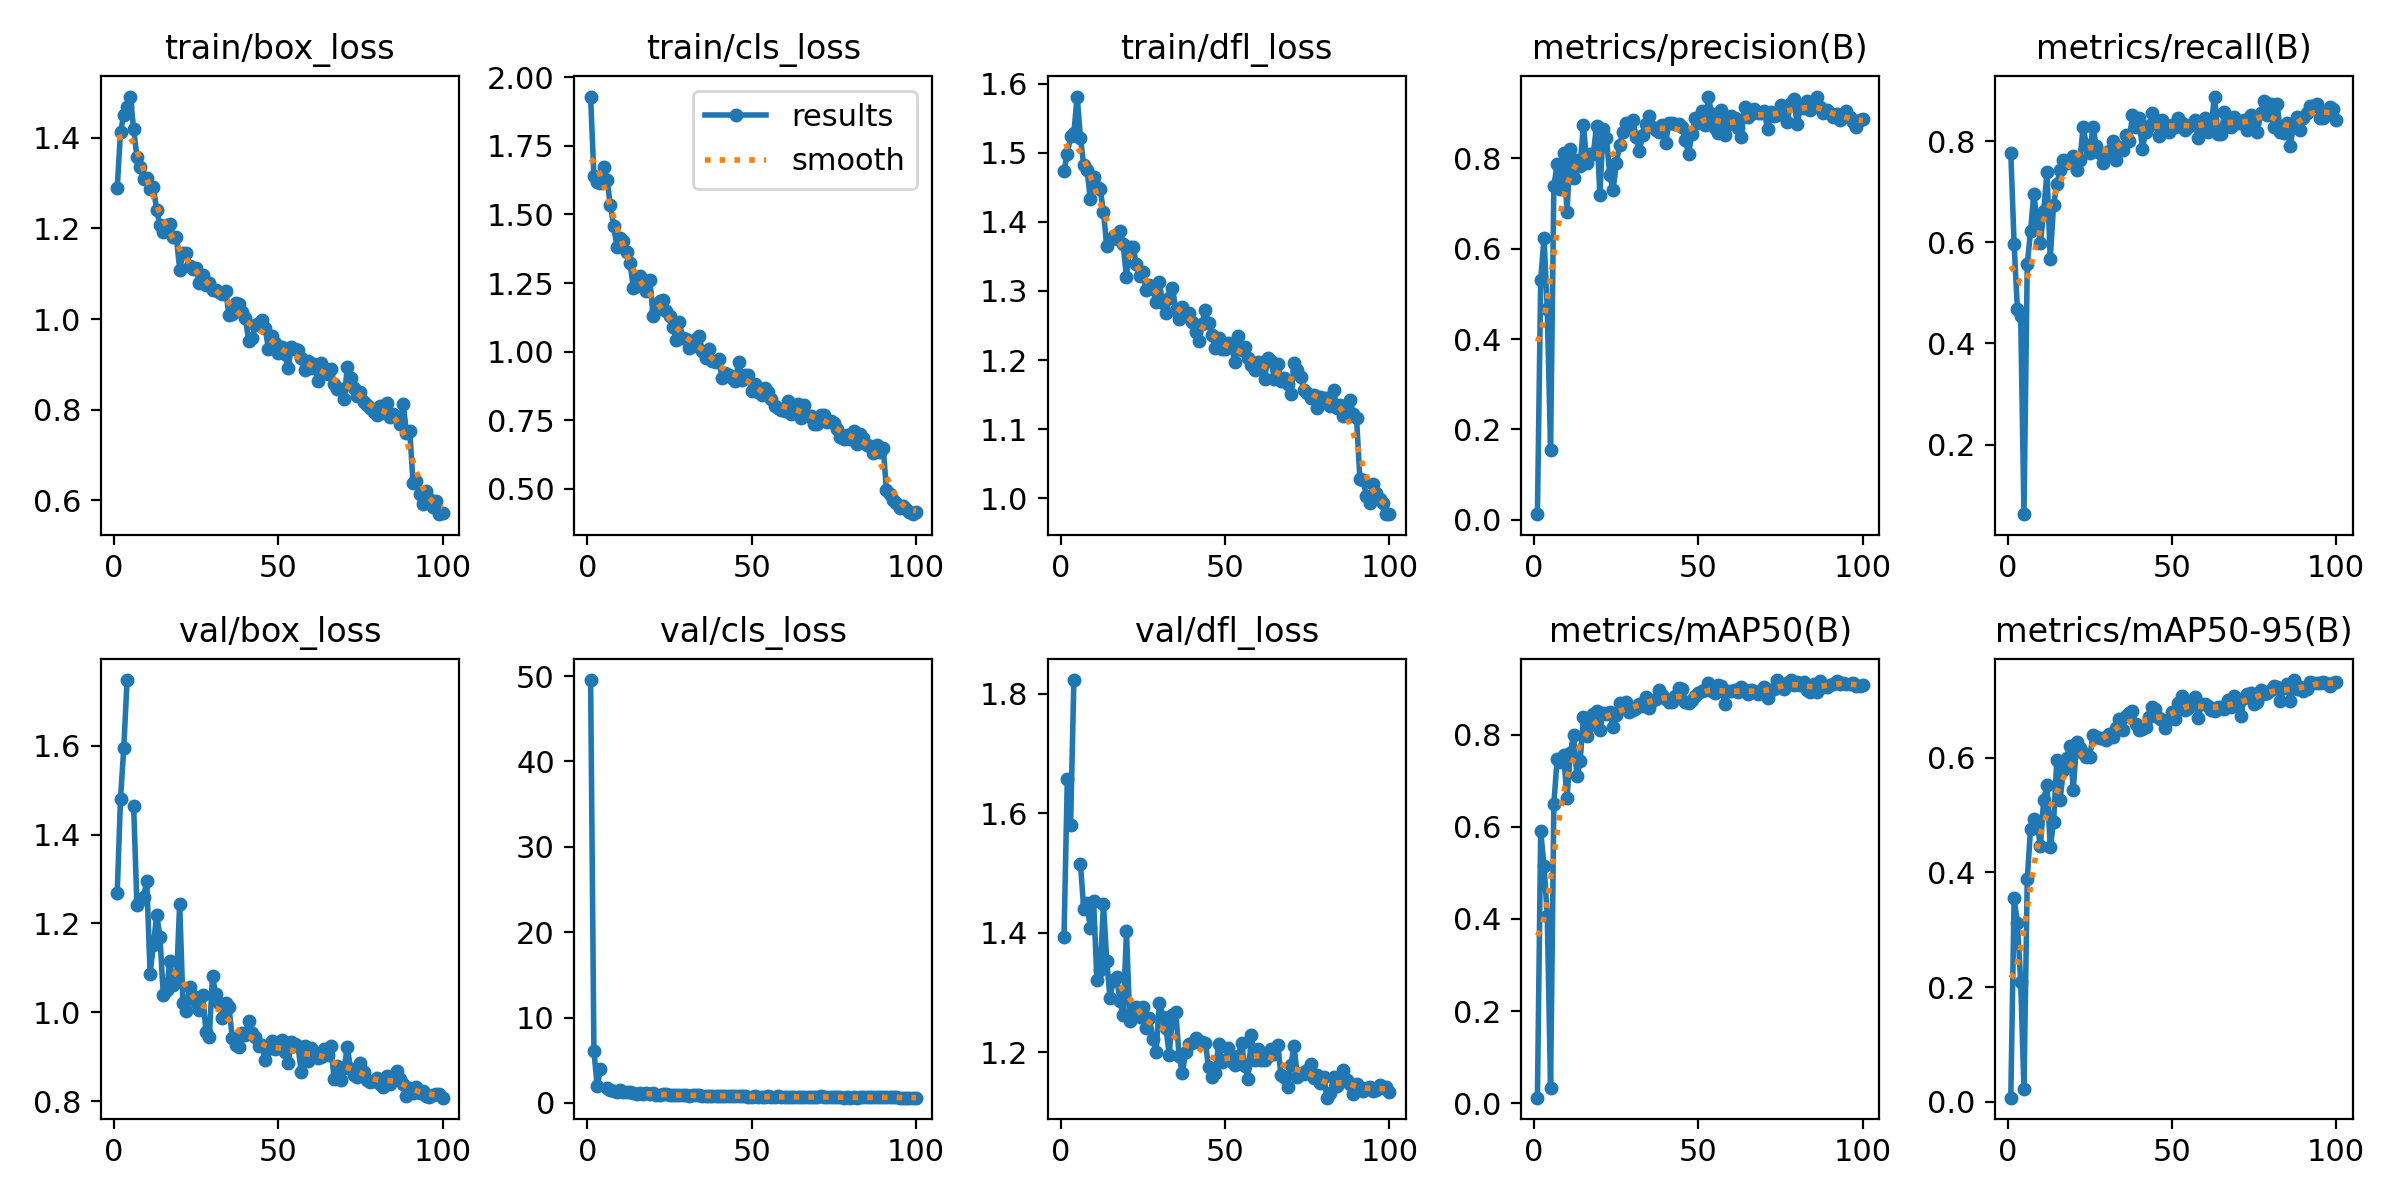

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/results.png', width=600)

/content/runs/detect/train


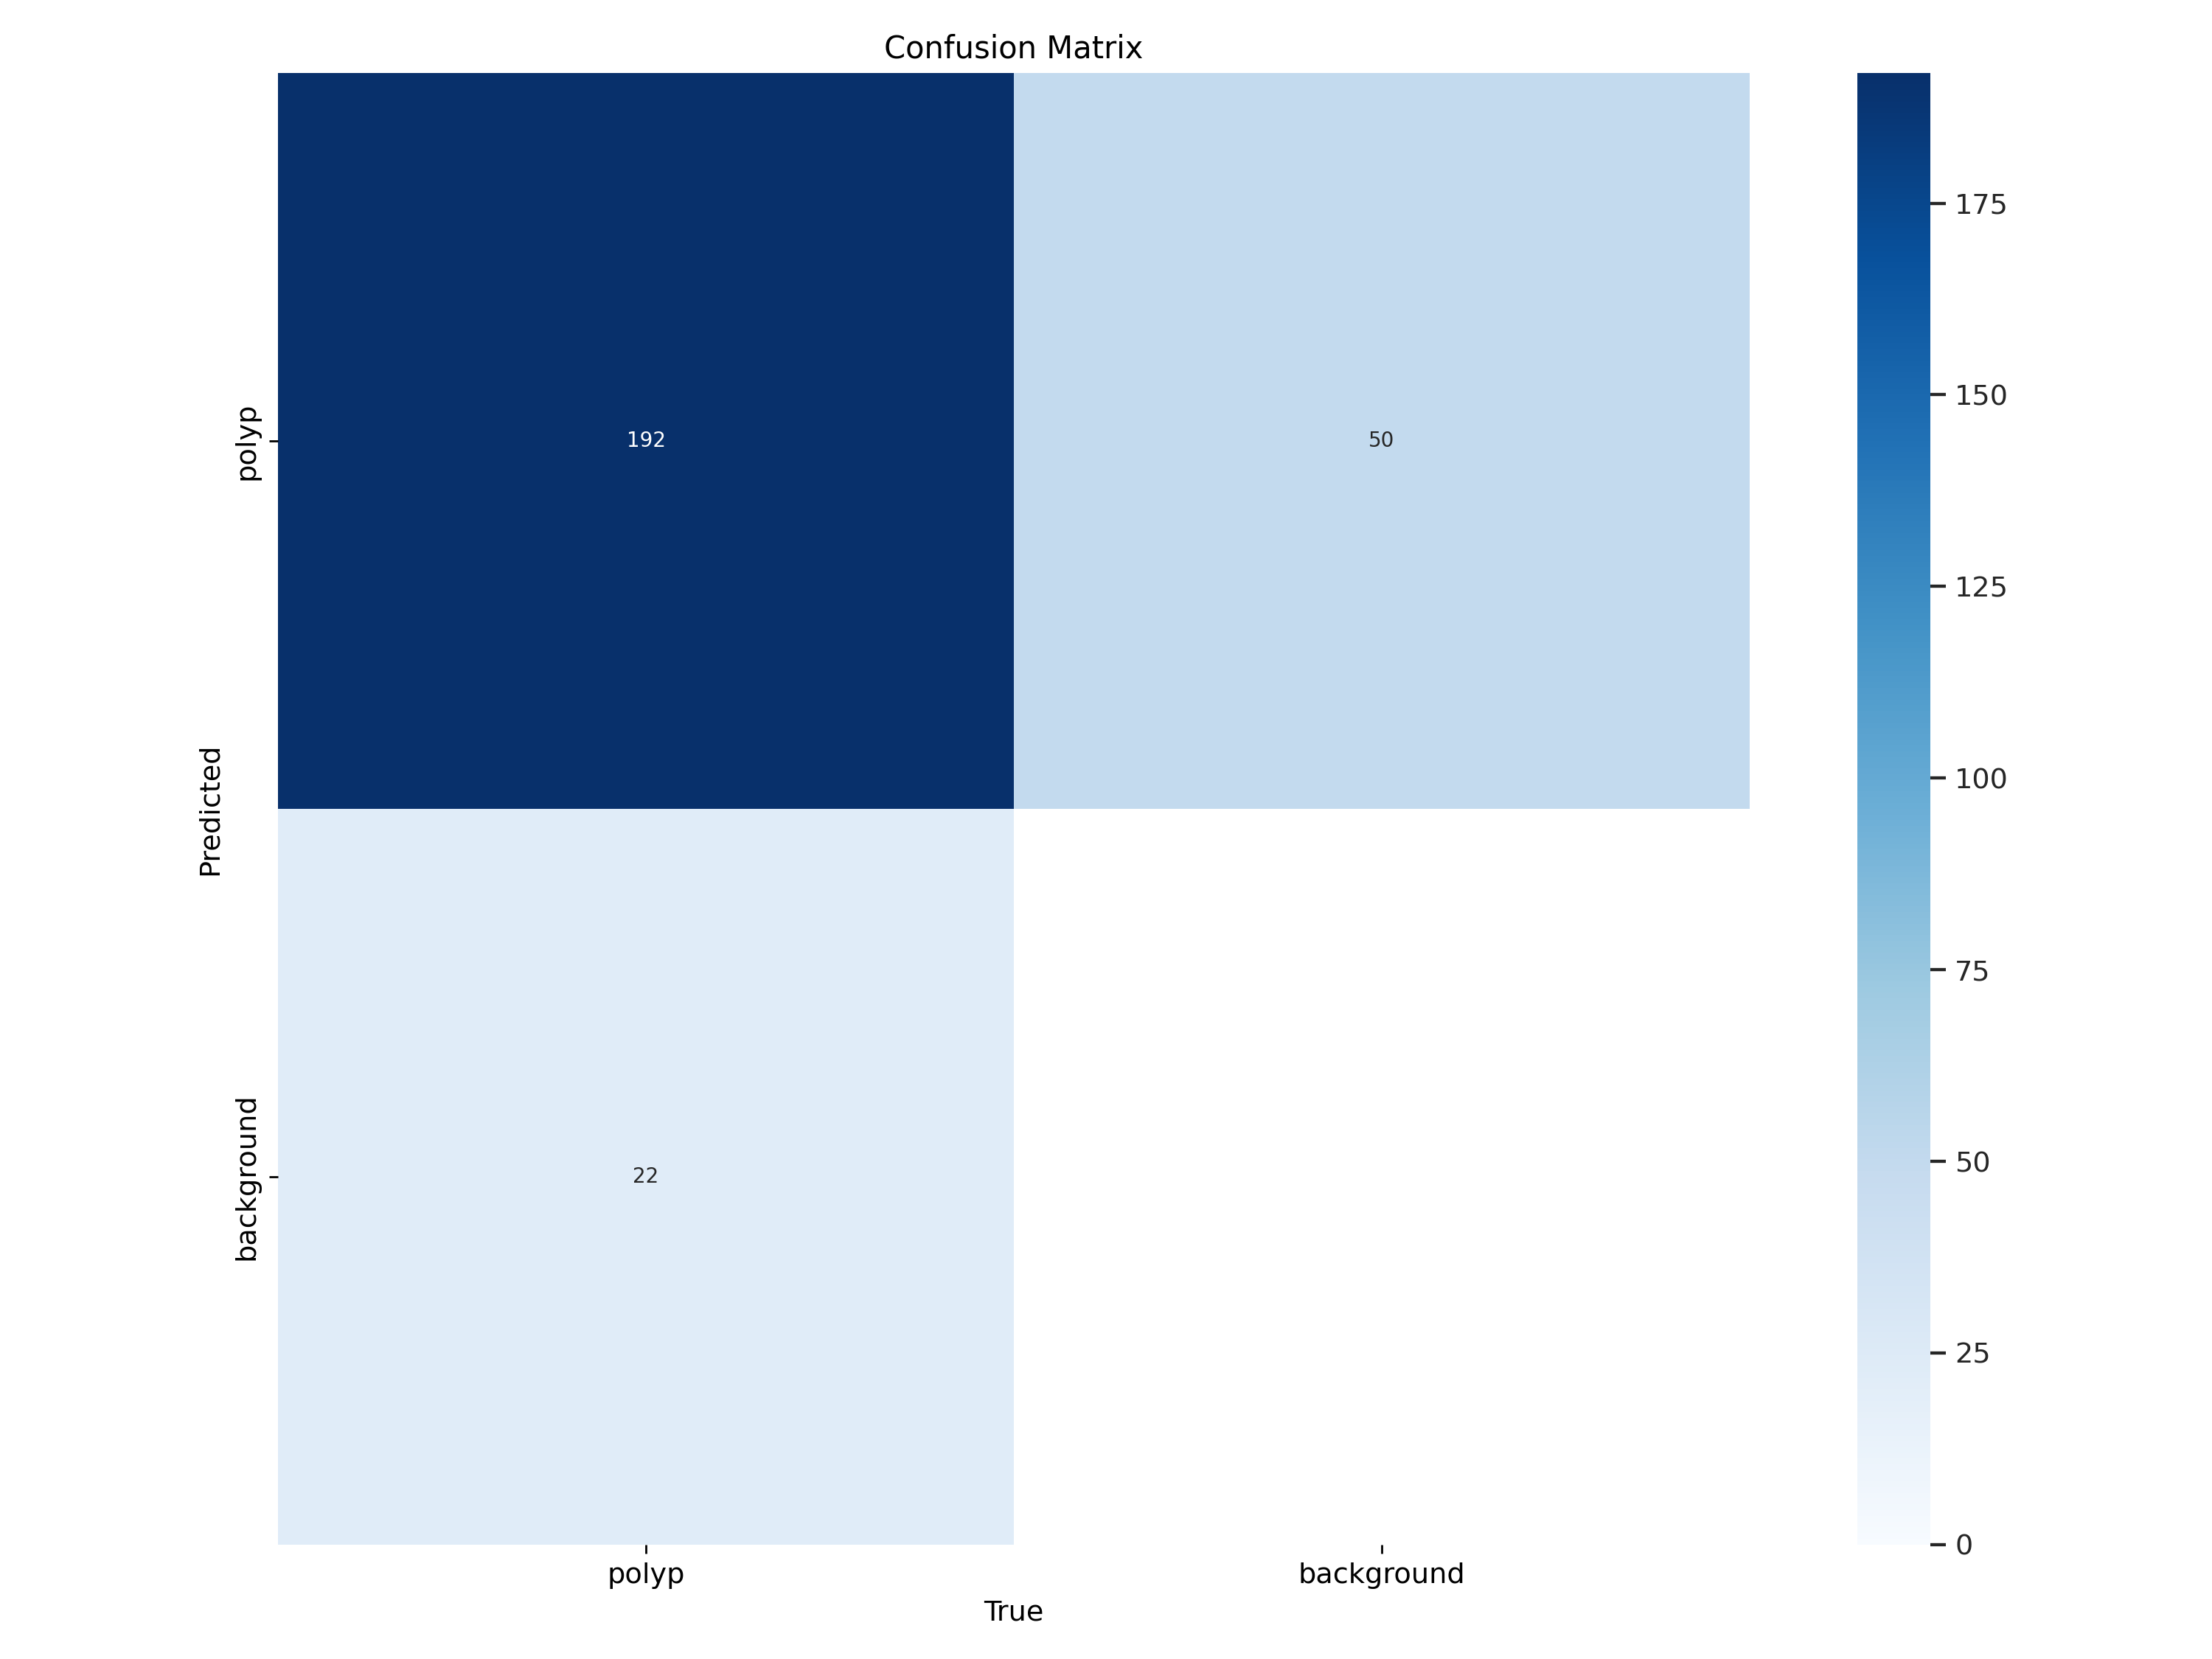

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

/content/runs/detect/train


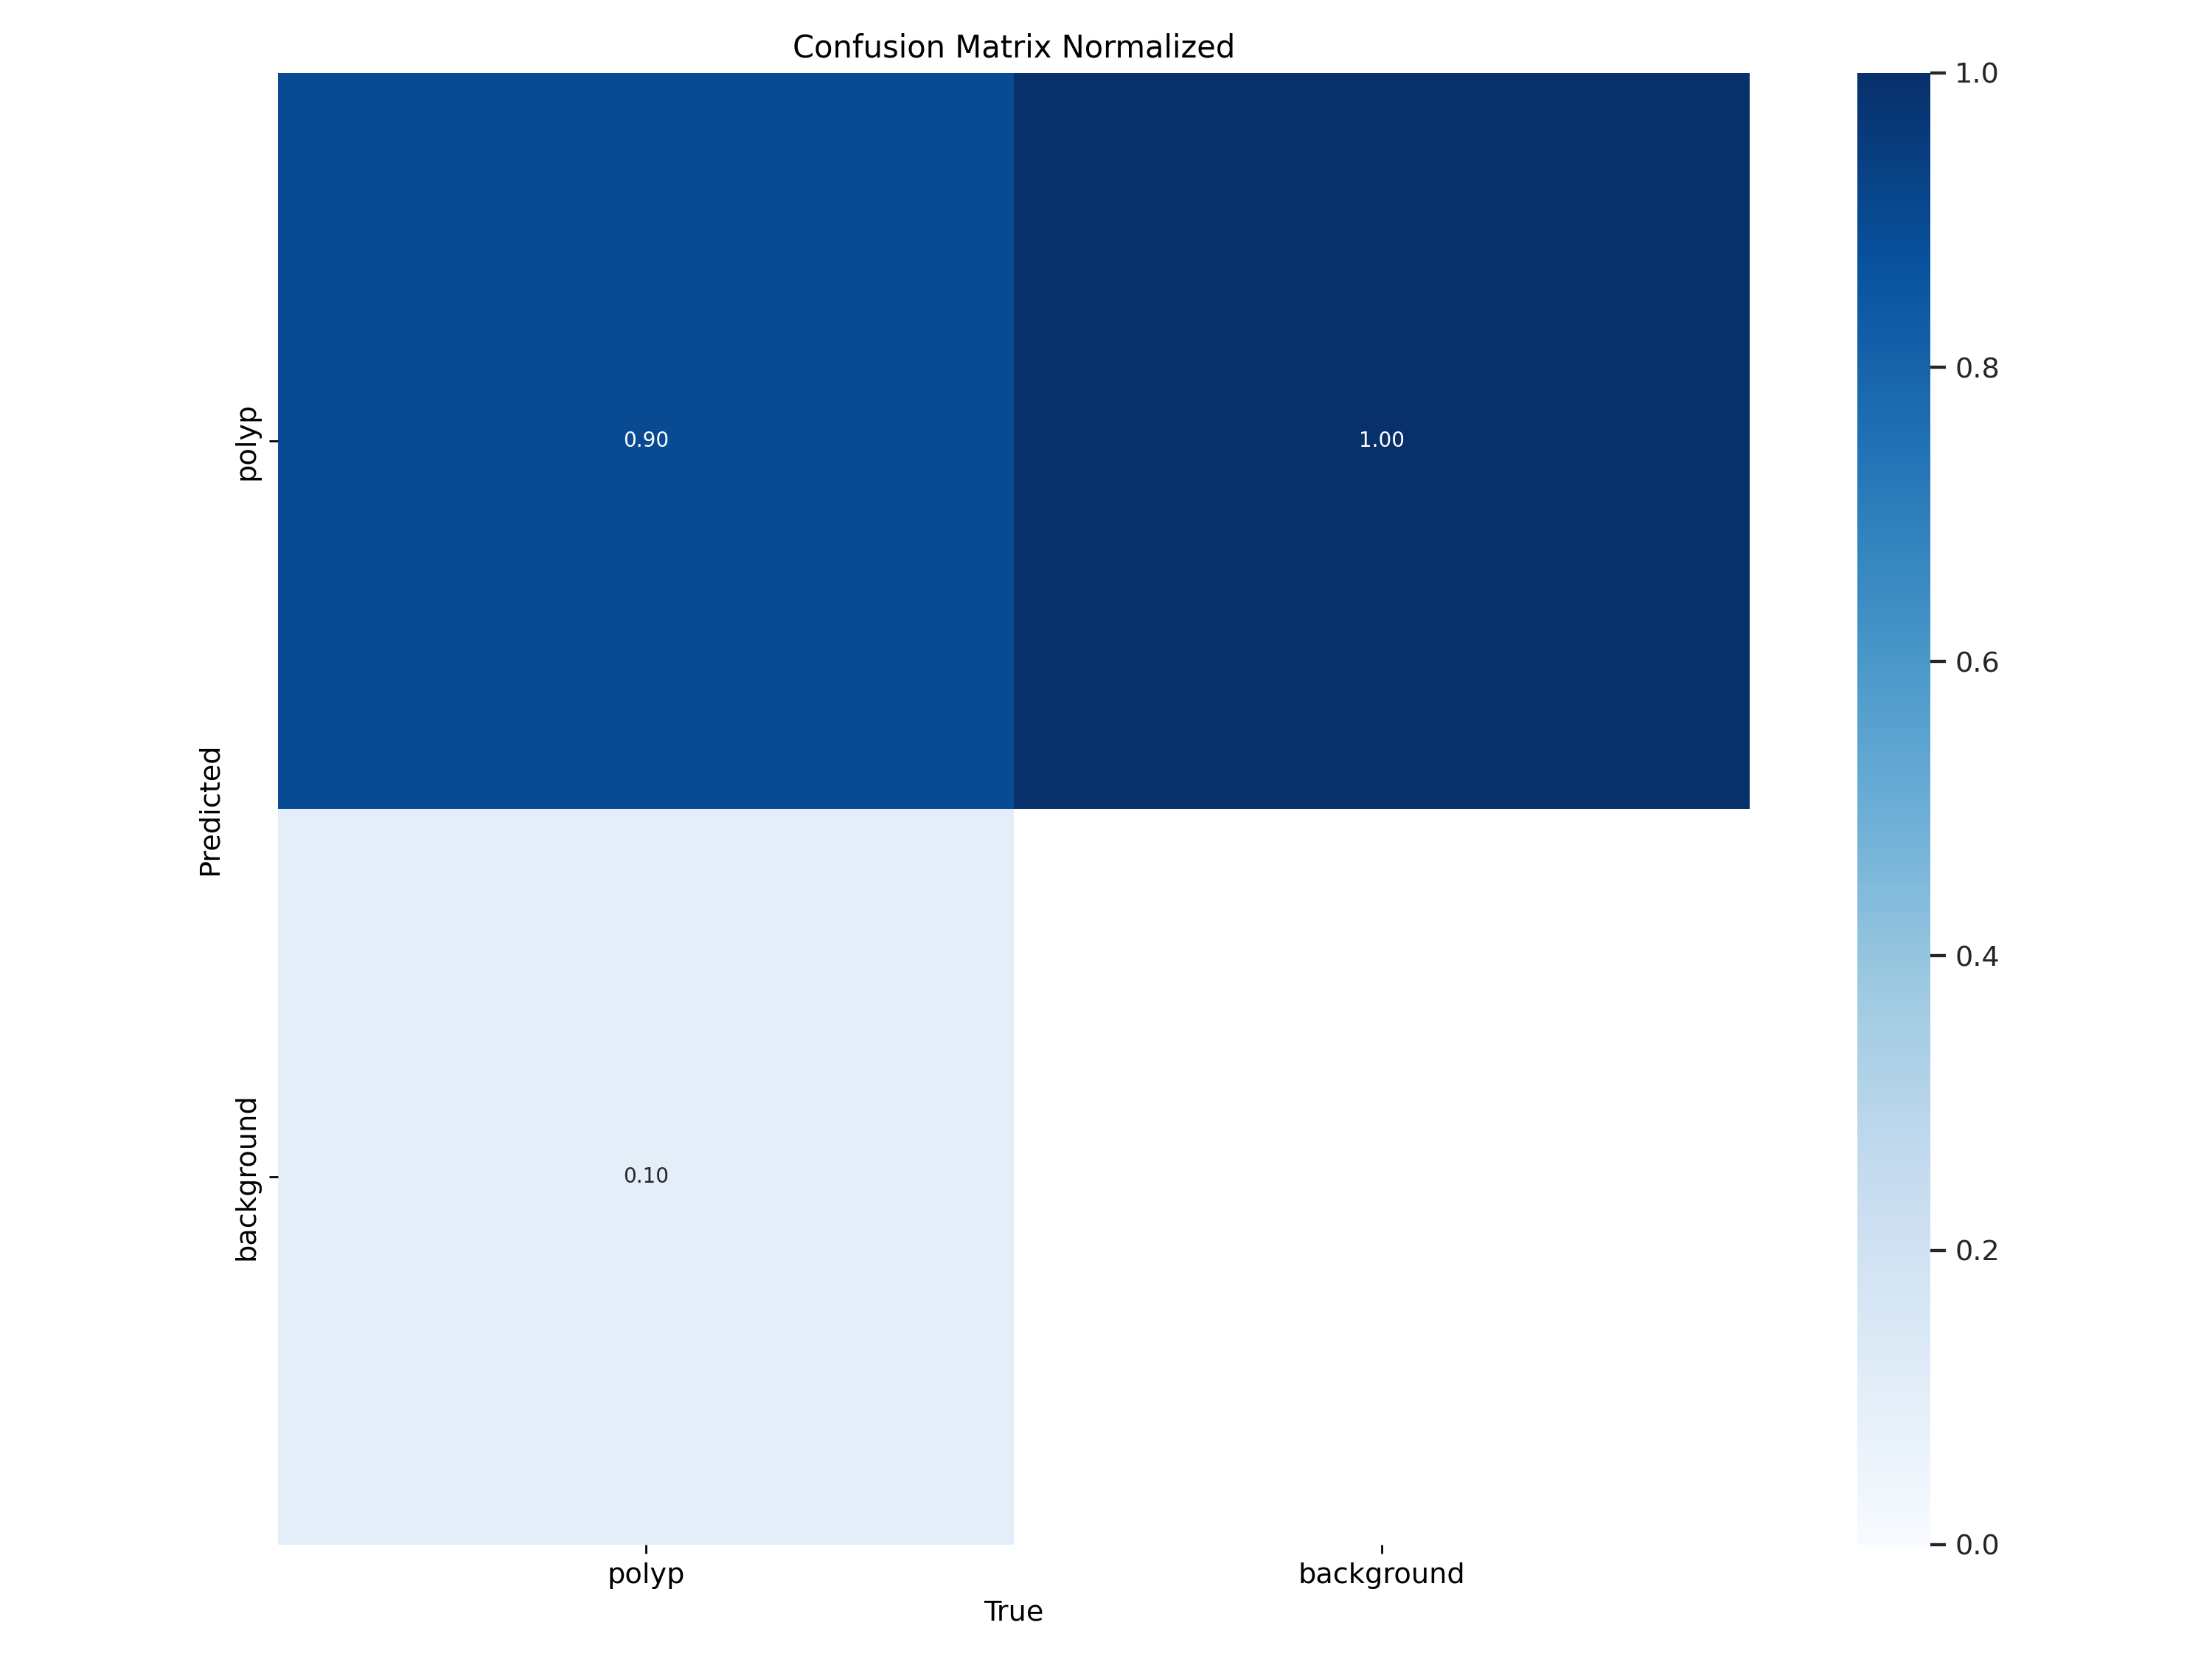

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/confusion_matrix_normalized.png', width=600)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/dataset4.yaml project=/content/runs/detect name=val   conf=0.5 iou=0.5

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1444.8±350.6 MB/s, size: 26.8 KB)
val: Scanning /content/dataset_split_AGC_kvrs_1gt_rem/labels/val.cache... 213 images, 23 backgrounds, 0 corrupt: 100% 236/236 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 15/15 [00:02<00:00,  7.10it/s]
                   all        236        214      0.914      0.845        0.9      0.767
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


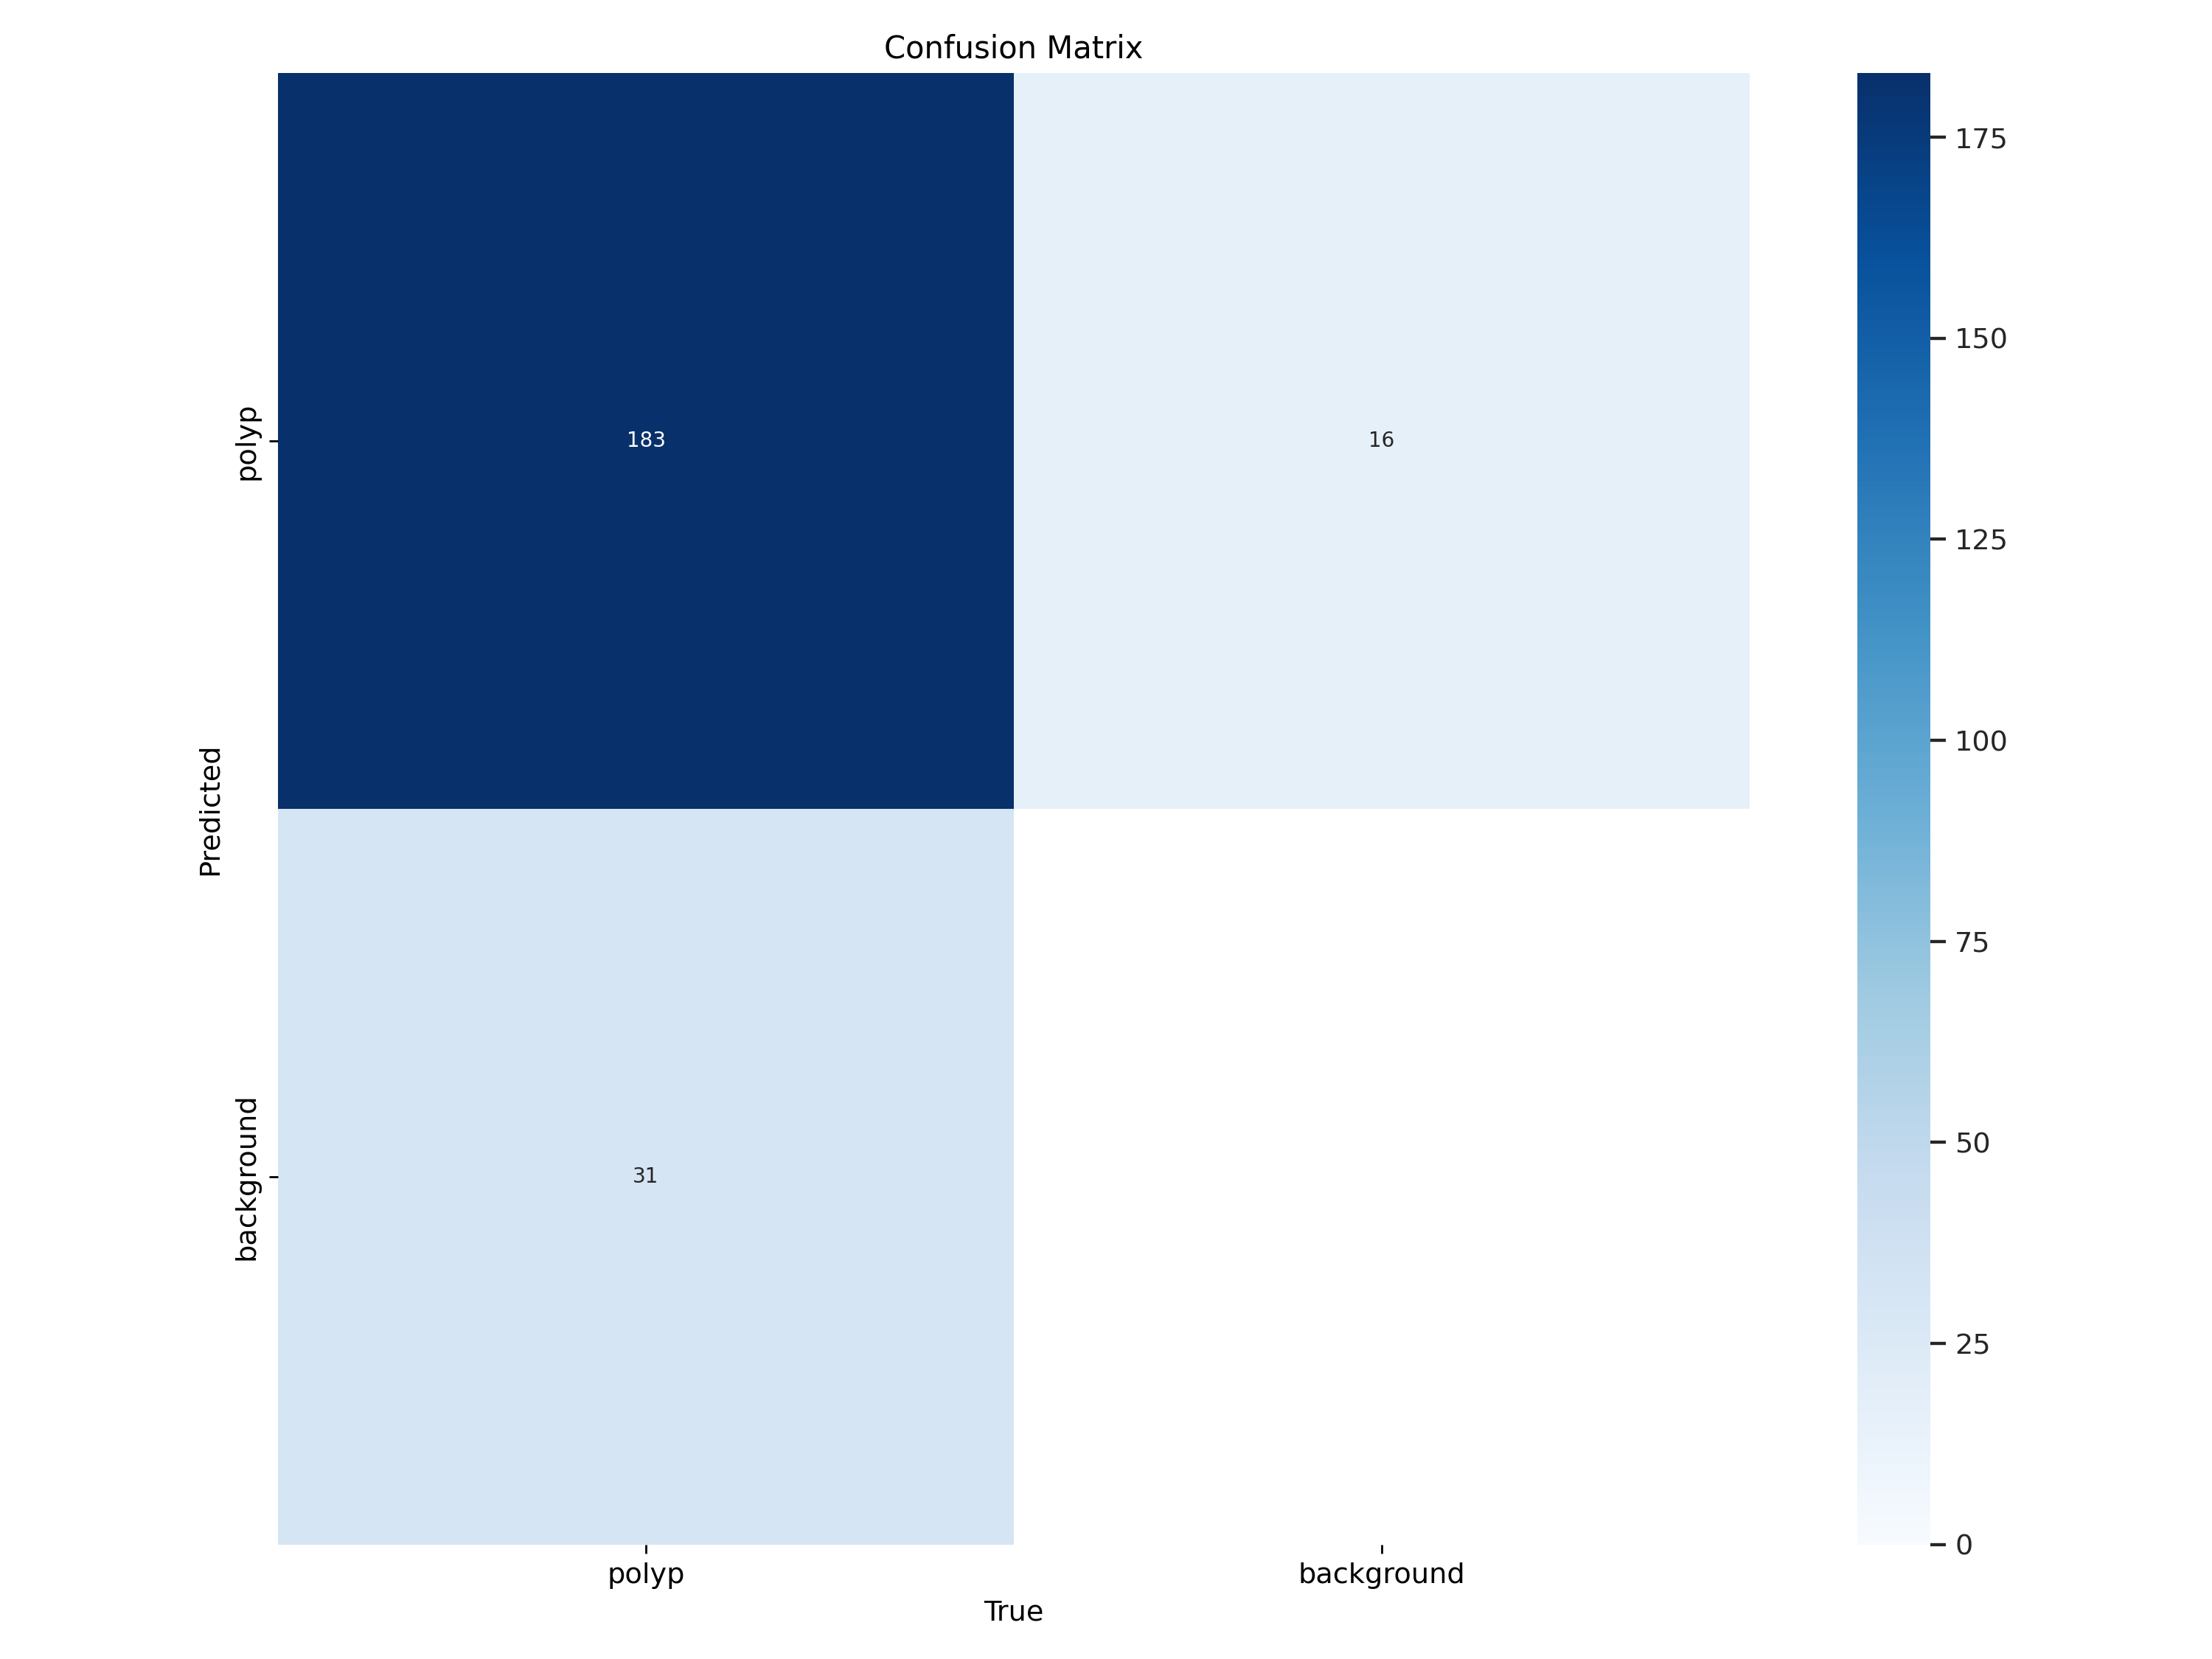

In [ ]:
Image(filename=f'/content/runs/detect/val/confusion_matrix.png', width=600)

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.5 iou=0.5 source=/content/dataset_split_AGC_kvrs_1gt_rem/images/test project=/content/runs/detect name=predict save=True save_txt=True save_conf=True

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/121 /content/dataset_split_AGC_kvrs_1gt_rem/images/test/202212150007C040.jpg: 256x256 (no detections), 11.5ms
image 2/121 /content/dataset_split_AGC_kvrs_1gt_rem/images/test/202301260065C012.jpg: 256x256 (no detections), 8.8ms
image 3/121 /content/dataset_split_AGC_kvrs_1gt_rem/images/test/202303210154C022.jpg: 256x256 (no detections), 9.1ms
image 4/121 /content/dataset_split_AGC_kvrs_1gt_rem/images/test/202306270295C027.jpg: 256x256 (no detections), 7.9ms
image 5/121 /content/dataset_split_AGC_kvrs_1gt_rem/images/test/202310030465C060.jpg: 256x256 (no detections), 7.8ms
image 6/121 /content/dataset_split_AGC_kvrs_1gt_rem/images/test/202405160871C073.jpg: 256x256 (no detections), 7.6ms
image 7/121 /content/dataset_split_AGC_kvrs_1gt_rem/images/test/202405200875C070.jpg: 256x256 (no detections), 7.7ms
image 8/121 

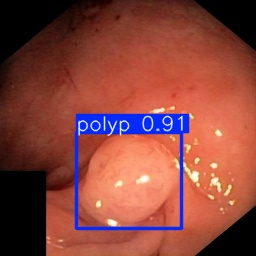

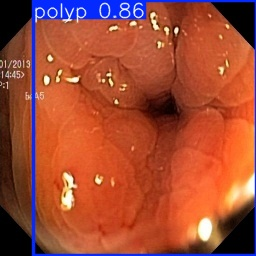

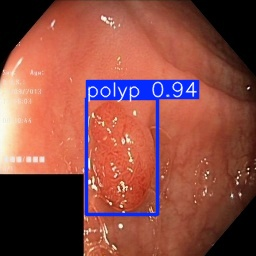

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'/content/runs/detect/predict'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=300))
    print("\n")

####test

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from collections import defaultdict

def compute_iou(box1, box2):
    """Menghitung IoU antara dua bounding box: [x_center, y_center, w, h]"""
    def to_corners(box):
        x, y, w, h = box
        return [x - w/2, y - h/2, x + w/2, y + h/2]

    box1 = to_corners(box1)
    box2 = to_corners(box2)

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append((cls, bbox))
    return labels

def evaluate(pred_dir, gt_dir, iou_threshold=0.5):
    predictions = []
    for pred_file in glob.glob(f"{pred_dir}/*.txt"):
        filename = os.path.basename(pred_file)
        image_id = filename.replace('.txt', '')
        gt_file = os.path.join(gt_dir, filename)

        pred_labels = []
        with open(pred_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                bbox = list(map(float, parts[1:5]))
                conf = float(parts[5]) if len(parts) > 5 else 1.0  # asumsikan confidence = 1.0 jika tidak tersedia
                pred_labels.append((image_id, cls, conf, bbox))
        predictions.extend(pred_labels)

    predictions.sort(key=lambda x: x[2], reverse=True)  # sort by confidence
    class_gt_counts = defaultdict(int)
    gt_boxes = defaultdict(list)

    for gt_file in glob.glob(f"{gt_dir}/*.txt"):
        image_id = os.path.basename(gt_file).replace('.txt', '')
        for cls, bbox in load_labels(gt_file):
            gt_boxes[(image_id, cls)].append({'bbox': bbox, 'used': False})
            class_gt_counts[cls] += 1

    stats = []
    acc_tp = 0
    acc_fp = 0

    for image_id, cls, conf, pred_box in predictions:
        matched = False
        candidates = gt_boxes.get((image_id, cls), [])
        for gt in candidates:
            if not gt['used']:
                iou = compute_iou(pred_box, gt['bbox'])
                if iou >= iou_threshold:
                    gt['used'] = True
                    matched = True
                    break

        tp = 1 if matched else 0
        fp = 0 if matched else 1

        acc_tp += tp
        acc_fp += fp

        precision = acc_tp / (acc_tp + acc_fp) if (acc_tp + acc_fp) > 0 else 0
        recall = acc_tp / sum(class_gt_counts.values()) if sum(class_gt_counts.values()) > 0 else 0

        stats.append([image_id, cls, conf, tp, fp, acc_tp, acc_fp, precision, recall])

    df = pd.DataFrame(stats, columns=["Image", "Class", "Confidence", "TP", "FP", "Acc TP", "Acc FP", "Precision", "Recall"])
    return df

# Contoh pemanggilan:
pred_dir = '/content/runs/detect/predict/labels'
gt_dir = '/content/dataset_split_AGC_kvrs_1gt_rem/labels/test'
df_metrics = evaluate(pred_dir, gt_dir)
df_metrics.to_csv("/content/detection_metrics_AGC_1gt_rem.csv", index=False)


Total Ground Truth: 109
Final Precision: 0.9307
Final Recall: 0.8624
Final F1-Score: 0.8952


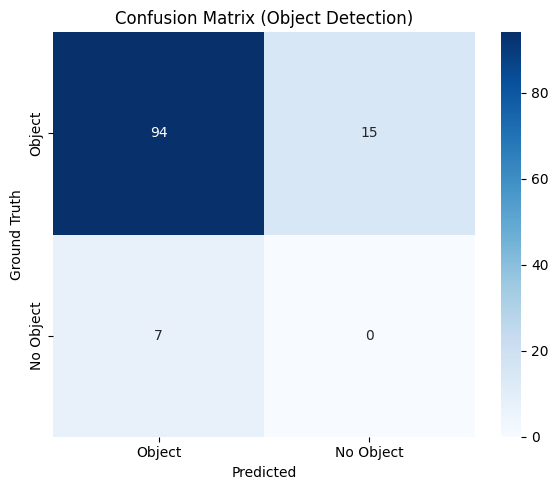

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def count_total_groundtruth(gt_dir):
    """
    Menghitung total jumlah bounding box (ground truth) dari folder label YOLO.

    Args:
        gt_dir (str): Path ke folder label ground truth (YOLO format)

    Returns:
        int: Total jumlah ground truth bounding box
    """
    total_gt = 0
    for file_name in os.listdir(gt_dir):
        if file_name.endswith('.txt'):
            file_path = os.path.join(gt_dir, file_name)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_gt += len(lines)
    return total_gt
gt_dir = '/content/dataset_split_AGC_kvrs_1gt_rem/labels/test'
total_gt = count_total_groundtruth(gt_dir)
print(f"Total Ground Truth: {total_gt}")

def compute_final_metrics(df: pd.DataFrame, total_gt: int):
    """
    Menghitung TP, FP, FN, Precision, Recall, dan F1-score dari DataFrame hasil evaluasi.

    Args:
        df (pd.DataFrame): DataFrame berisi kolom ['TP', 'FP'] untuk masing-masing prediksi
        total_gt (int): Jumlah total ground truth (box sebenarnya)

    Returns:
        dict: Confusion matrix dan metrik evaluasi
    """
    tp = df['TP'].sum()
    fp = df['FP'].sum()
    fn = total_gt - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }
# Misalnya 'eval_df' adalah DataFrame berisi kolom ['TP', 'FP']
final_result = compute_final_metrics(df_metrics, total_gt)

print(f"Final Precision: {final_result['Precision']}")
print(f"Final Recall: {final_result['Recall']}")
print(f"Final F1-Score: {final_result['F1 Score']}")

tp = final_result['True Positive (TP)']
fp = final_result['False Positive (FP)']
fn = final_result['False Negative (FN)']
tn = 0  # TN tidak dihitung dalam object detection
# Plot confusion matrix
conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

labels = ['Object', 'No Object']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix (Object Detection)')
plt.tight_layout()
plt.show()

##HR

####kvasir

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_HR_kvasir_seg_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_HR_kvasir_seg_1gt_removed.zip -d /content/output_HR_kvasir_seg_1gt_removed/


Archive:  /content/output_HR_kvasir_seg_1gt_removed.zip
   creating: /content/output_HR_kvasir_seg_1gt_removed/bboxes/
   creating: /content/output_HR_kvasir_seg_1gt_removed/images/
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-347.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-204.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-911.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-79.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-709.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-870.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-919.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-646.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-812.jpg  
  inflating: /content/output_HR_kvasir_seg_1gt_removed/images/kv-seg-692.jpg  
  inflating: /content/output_

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_HR_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_HR_RSUA_1gt_removed.zip -d /content/output_HR_RSUA_1gt_removed/


Archive:  /content/output_HR_RSUA_1gt_removed.zip
   creating: /content/output_HR_RSUA_1gt_removed/bboxes/
   creating: /content/output_HR_RSUA_1gt_removed/images/
  inflating: /content/output_HR_RSUA_1gt_removed/images/2_polyp-1-_202301260065C071.jpg  
  inflating: /content/output_HR_RSUA_1gt_removed/images/4_polyp-1-_202307170329C049.jpg  
  inflating: /content/output_HR_RSUA_1gt_removed/images/3_polyp-1-_asli_202405160871C094.jpg  
  inflating: /content/output_HR_RSUA_1gt_removed/images/4_polyp-1-_202406050908C006.jpg  
  inflating: /content/output_HR_RSUA_1gt_removed/images/4_polyp-1-_202409191126C010.jpg  
  inflating: /content/output_HR_RSUA_1gt_removed/images/3_polyp-1-_202306270295C062.jpg  
  inflating: /content/output_HR_RSUA_1gt_removed/images/polyp-1-_202305050217C020.jpg  
  inflating: /content/output_HR_RSUA_1gt_removed/images/6_polyp-1-_asli_202402190736C019.jpg  
  inflating: /content/output_HR_RSUA_1gt_removed/images/6_polyp-1-_202306270295C049.jpg  
  inflating: /cont

In [ ]:
!cp /content/drive/MyDrive/scrypt/data/output_HR_normal_RSUA_1gt_removed.zip /content/

In [ ]:
!unzip /content/output_HR_normal_RSUA_1gt_removed.zip -d /content/output_HR_normal_RSUA_1gt_removed/


Archive:  /content/output_HR_normal_RSUA_1gt_removed.zip
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202405200875C070.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202409051095C040.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202412311348C043.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202405130861C015.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202402020707C059.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202306270295C027.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202310030465C060.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202306270295C045.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202305090219C035.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202407291035C086.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202409191126C006.jpg  
  inflating: /content/output_HR_normal_RSUA_1gt_removed/202303160145C057.j

In [ ]:
# Path ke folder output (misalnya, 'dataset_split' di direktori saat ini)
output_path = 'dataset_split_HR_kvrs_1gt_rem'

# Membuat folder output
os.makedirs(output_path, exist_ok=True)

In [ ]:
import pandas as pd
import os
import random
from glob import glob
import shutil


def split_dataset1(images_path, labels_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Memastikan rasio pembagian data totalnya 1.0
    # assert train_ratio + val_ratio + test_ratio == 1.0, "Total rasio train, val, dan test harus 1.0"

    # Membuat folder output untuk train, val, dan test
    os.makedirs(os.path.join(output_path, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'images', 'test'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'labels', 'test'), exist_ok=True)

    # Dapatkan semua file gambar
    image_files = glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png"))

    # Pastikan ada file gambar
    assert len(image_files) > 0, "Tidak ada file gambar yang ditemukan."

    # Mengacak urutan file
    random.shuffle(image_files)

    # Hitung jumlah file untuk setiap set
    total_images = len(image_files)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)

    # Bagi dataset menjadi train, val, dan test
    train_images = image_files[:train_count]
    val_images = image_files[train_count:train_count + val_count]
    test_images = image_files[train_count + val_count:]

    # Fungsi untuk menyalin file ke direktori tujuan dan mengonversi label
    def copy_files(image_set, subset):
        for img_file in image_set:
            # Salin file gambar
            shutil.copy(img_file, os.path.join(output_path, 'images', subset, os.path.basename(img_file)))

            # Salin file label dengan ekstensi CSV jika ada
            label_file_path = os.path.join(labels_path, os.path.splitext(os.path.basename(img_file))[0] + '.txt')
            if os.path.exists(label_file_path):
                #convert_csv_to_yolo(label_file_path, img_file, os.path.join(output_path, 'labels', subset))
                shutil.copy(label_file_path, os.path.join(output_path, 'labels', subset, os.path.basename(label_file_path)))
            else:
                print(f"Warning: Label tidak ditemukan untuk {img_file}")

    # Menyalin file ke direktori train, val, dan test
    copy_files(train_images, 'train')
    copy_files(val_images, 'val')
    copy_files(test_images, 'test')

    print(f"Dataset dibagi menjadi train ({len(train_images)}), val ({len(val_images)}), dan test ({len(test_images)})")


In [ ]:
# Contoh penggunaan
images_path = '/content/output_HR_normal_RSUA_1gt_removed'
images_path1 = '/content/output_HR_kvasir_seg_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path1 = '/content/output_HR_kvasir_seg_1gt_removed/bboxes'  # Path ke folder yang berisi semua file anotasi
images_path11 = '/content/output_HR_RSUA_1gt_removed/images'  # Path ke folder yang berisi semua file gambar
labels_path11 = '/content/output_HR_RSUA_1gt_removed/bboxes'
output_path = '/content/dataset_split_HR_kvrs_1gt_rem'  # Path ke folder tujuan untuk dataset yang telah dipisah

split_dataset1(images_path1, labels_path1, output_path)
split_dataset1(images_path11, labels_path11, output_path)
split_normal_dataset (images_path, output_path)

Dataset dibagi menjadi train (665), val (190), dan test (95)
Dataset dibagi menjadi train (83), val (23), dan test (13)
Dataset normal berhasil dibagi ke folder yang sudah ada: train (83), val (23), test (13)


In [ ]:
# Inisialisasi counter
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_HR_kvrs_1gt_rem/images/train'):
    if file_name.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")
count = 0

# Iterasi melalui file di folder
for file_name in os.listdir('/content/dataset_split_HR_kvrs_1gt_rem/labels/train'):
    if file_name.endswith(('.txt')):
        count += 1

print(f"Jumlah file gambar dalam folder: {count}")

Jumlah file gambar dalam folder: 831
Jumlah file gambar dalam folder: 748


In [ ]:
import yaml

# Data untuk file YAML
dataset = {
    'train': '/content/dataset_split_HR_kvrs_1gt_rem/images/train',  # Ubah sesuai path ke folder gambar train Anda
    'val': '/content/dataset_split_HR_kvrs_1gt_rem/images/val',      # Ubah sesuai path
    'test': '/content/dataset_split_HR_kvrs_1gt_rem/images/test',
    'nc': 1,  # Jumlah kelas
    'names': ['polyp']  # Nama-nama kelas
}

# Path untuk menyimpan file YAML
yaml_file = '/content/dataset5.yaml'

# Menulis file YAML
with open(yaml_file, 'w') as file:
    yaml.dump(dataset, file)

print(f"File YAML dataset berhasil dibuat: {yaml_file}")


File YAML dataset berhasil dibuat: /content/dataset5.yaml


###model

In [ ]:
# Load a model
model2 = YOLO("yolo11s.pt")

# Train the model
train_results = model2.train(
    data="/content/dataset5.yaml",  # path to dataset YAML
    epochs=100,             # max epoch
    imgsz=256,
    batch=8,
    device=0,
    project="/content/runs/detect",  # direktori utama penyimpanan
    name="train",                   # subfolder hasil training
    exist_ok=True                    # tidak error jika folder sudah ada
    #patience=10,            # Early stopping if no improvement in 10 epochs
    #verbose=True
)

# Evaluate model performance on the validation set
#metrics = model.val()

100%|██████████| 18.4M/18.4M [00:00<00:00, 136MB/s]


Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset5.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

100%|██████████| 755k/755k [00:00<00:00, 108MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 23        [16, 19, 22]  1    819795  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
YOLO11s summary: 181 layers, 9,428,179 parameters, 9,428,163 gradients, 21.5 GFLOPs

Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 56.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 996.2±383.2 MB/s, size: 22.2 KB)


train: Scanning /content/dataset_split_HR_kvrs_1gt_rem/labels/train... 748 images, 83 backgrounds, 0 corrupt: 100%|██████████| 831/831 [00:00<00:00, 2610.45it/s]

train: New cache created: /content/dataset_split_HR_kvrs_1gt_rem/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 425.0±151.0 MB/s, size: 21.6 KB)


val: Scanning /content/dataset_split_HR_kvrs_1gt_rem/labels/val... 213 images, 23 backgrounds, 0 corrupt: 100%|██████████| 236/236 [00:00<00:00, 1201.22it/s]

val: New cache created: /content/dataset_split_HR_kvrs_1gt_rem/labels/val.cache


Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.568G       1.26      1.831      1.426         12        256: 100%|██████████| 104/104 [00:13<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        236        215        0.6      0.489      0.548      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.641G      1.423      1.678      1.511         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]

                   all        236        215      0.582      0.535      0.504      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.682G      1.454      1.565      1.545         18        256: 100%|██████████| 104/104 [00:11<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]

                   all        236        215      0.374      0.284      0.234      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.752G      1.457       1.62      1.521         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.18it/s]

                   all        236        215      0.528      0.423      0.402      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.791G       1.42      1.581      1.542         11        256: 100%|██████████| 104/104 [00:10<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.99it/s]

                   all        236        215      0.602      0.642      0.674      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.861G      1.352      1.526       1.49         18        256: 100%|██████████| 104/104 [00:10<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.14it/s]

                   all        236        215      0.666      0.647       0.74      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.902G      1.338      1.465      1.446          9        256: 100%|██████████| 104/104 [00:10<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.32it/s]

                   all        236        215       0.71       0.53      0.625      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.941G      1.306      1.428      1.435         10        256: 100%|██████████| 104/104 [00:10<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.59it/s]

                   all        236        215       0.75      0.656      0.724      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         1G      1.288      1.373      1.443         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]

                   all        236        215      0.763      0.674      0.747      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.09G      1.262      1.344       1.43          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.80it/s]

                   all        236        215      0.803      0.664      0.775      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.13G      1.237      1.271      1.412         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.56it/s]

                   all        236        215       0.68      0.722      0.765      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.17G      1.256        1.3      1.412          7        256: 100%|██████████| 104/104 [00:11<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.68it/s]

                   all        236        215      0.818       0.74      0.813      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.24G      1.228        1.3      1.401          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.69it/s]

                   all        236        215      0.864      0.707      0.825      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.28G      1.175      1.223      1.349         15        256: 100%|██████████| 104/104 [00:10<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.33it/s]

                   all        236        215      0.833       0.72      0.808      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.34G      1.206      1.271       1.39         11        256: 100%|██████████| 104/104 [00:10<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.12it/s]

                   all        236        215      0.803      0.701      0.776      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.38G      1.207      1.248      1.372         10        256: 100%|██████████| 104/104 [00:10<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]

                   all        236        215      0.802      0.736      0.822      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.44G      1.175      1.254      1.353         11        256: 100%|██████████| 104/104 [00:10<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.64it/s]

                   all        236        215      0.763      0.749      0.831      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.49G      1.158      1.143      1.346          5        256: 100%|██████████| 104/104 [00:10<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.97it/s]

                   all        236        215      0.866      0.719      0.858      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.55G      1.169      1.184      1.356         12        256: 100%|██████████| 104/104 [00:10<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]

                   all        236        215      0.844      0.755       0.86      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.61G      1.144      1.149      1.361         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]

                   all        236        215       0.81      0.716      0.802      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.65G      1.159      1.216      1.354         14        256: 100%|██████████| 104/104 [00:10<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]

                   all        236        215      0.818      0.758      0.852      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.71G      1.089      1.094      1.304         11        256: 100%|██████████| 104/104 [00:10<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.71it/s]

                   all        236        215      0.891      0.761      0.884       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       1.8G      1.084      1.085      1.318         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.40it/s]

                   all        236        215      0.892      0.795      0.876      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.84G      1.062      1.087        1.3         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.06it/s]

                   all        236        215      0.886      0.795      0.882      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.88G      1.111      1.095      1.316         11        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.13it/s]

                   all        236        215      0.861      0.772      0.866      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.94G      1.058      1.068       1.28         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.49it/s]

                   all        236        215      0.825       0.81      0.866      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.98G      1.049      1.041      1.294         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

                   all        236        215       0.89        0.8      0.885      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.05G       1.07      1.063       1.29         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.09it/s]

                   all        236        215      0.801       0.74       0.83      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.09G      1.037      1.058      1.275         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.39it/s]

                   all        236        215      0.833      0.745      0.842      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.16G      1.048      1.005      1.289         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.20it/s]

                   all        236        215      0.826       0.74      0.843      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.2G      1.057      1.035      1.285         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.32it/s]

                   all        236        215      0.867       0.74      0.861      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.27G      1.032      1.003      1.271         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.55it/s]

                   all        236        215      0.897      0.781      0.864      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.31G      1.023      1.018       1.27         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.01it/s]

                   all        236        215      0.795      0.805      0.879      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.37G      1.027       1.02      1.273         18        256: 100%|██████████| 104/104 [00:11<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.23it/s]

                   all        236        215      0.887      0.804      0.891      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.44G      1.028      1.004      1.281         16        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

                   all        236        215      0.922      0.775      0.896       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.48G      1.012     0.9807      1.286         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.97it/s]

                   all        236        215      0.895      0.828      0.908      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.55G      1.026       0.96      1.297         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.11it/s]

                   all        236        215      0.865      0.823      0.905      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.59G      1.003     0.9412      1.262         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all        236        215       0.88      0.837      0.909      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.63G      1.012     0.9549      1.269         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.23it/s]

                   all        236        215      0.913      0.827      0.911      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.69G     0.9961     0.9339      1.266         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.42it/s]

                   all        236        215      0.821      0.842       0.89      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.78G     0.9797     0.9532       1.25         10        256: 100%|██████████| 104/104 [00:11<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.57it/s]

                   all        236        215      0.892      0.795      0.901      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.81G     0.9538     0.8987      1.235         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

                   all        236        215      0.936      0.837      0.928      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.86G     0.9621     0.9044      1.238         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.42it/s]

                   all        236        215      0.924      0.847       0.92      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.93G     0.9397     0.8706      1.235         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.30it/s]

                   all        236        215      0.892      0.842      0.912       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.96G      1.003     0.9365      1.262         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.09it/s]

                   all        236        215      0.868      0.795      0.886      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.04G     0.9661     0.9409      1.234         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.97it/s]

                   all        236        215      0.916      0.833      0.922       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.08G     0.9604     0.8824      1.232         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.00it/s]

                   all        236        215      0.885      0.861      0.918      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.14G     0.9654     0.8927      1.241         17        256: 100%|██████████| 104/104 [00:11<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.05it/s]

                   all        236        215      0.898      0.879      0.922      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.2G     0.9276     0.8623      1.216         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]

                   all        236        215      0.938      0.839      0.921      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.28G     0.9262     0.8738      1.226         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.58it/s]

                   all        236        215      0.858      0.874      0.911      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.35G      0.927     0.8814      1.233         14        256: 100%|██████████| 104/104 [00:11<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.10it/s]

                   all        236        215       0.85      0.851      0.898      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.39G      0.931     0.8752      1.226         12        256: 100%|██████████| 104/104 [00:10<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.60it/s]

                   all        236        215      0.876      0.855      0.909      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.43G     0.8709      0.795      1.183         11        256: 100%|██████████| 104/104 [00:10<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]

                   all        236        215      0.864      0.837      0.904      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.47G     0.9242      0.792       1.21         13        256: 100%|██████████| 104/104 [00:10<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.78it/s]

                   all        236        215      0.879      0.814      0.901      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.56G     0.9335     0.8707      1.226         10        256: 100%|██████████| 104/104 [00:10<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]

                   all        236        215      0.872      0.824      0.902       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       3.6G     0.8907     0.8056      1.192          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]

                   all        236        215      0.903      0.879      0.924      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.64G      0.938     0.8222      1.238         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]

                   all        236        215      0.875      0.813      0.894      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.68G     0.8886     0.8087      1.199         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]

                   all        236        215      0.858       0.84      0.907      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.75G     0.8802     0.8039      1.176         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.09it/s]

                   all        236        215      0.899      0.842      0.914      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.79G     0.8846     0.8021      1.197          9        256: 100%|██████████| 104/104 [00:11<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]

                   all        236        215      0.904      0.791      0.901      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.85G     0.8886     0.7881      1.187         13        256: 100%|██████████| 104/104 [00:11<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.96it/s]

                   all        236        215      0.889      0.855       0.91      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.89G     0.8826     0.7803       1.18         17        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.56it/s]

                   all        236        215      0.886       0.87      0.923      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.96G     0.8982     0.8157      1.191          8        256: 100%|██████████| 104/104 [00:11<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.32it/s]

                   all        236        215      0.864      0.828      0.891      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         4G     0.8956     0.7923      1.193         15        256: 100%|██████████| 104/104 [00:11<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.15it/s]

                   all        236        215      0.875      0.902      0.932      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.07G     0.8672     0.7571      1.167         12        256: 100%|██████████| 104/104 [00:11<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.13it/s]

                   all        236        215      0.884      0.865      0.922      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.13G     0.8665     0.7692      1.181         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.13it/s]

                   all        236        215      0.929      0.833      0.913      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.21G     0.8424     0.7162      1.166         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.15it/s]

                   all        236        215      0.954      0.862      0.926       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.26G     0.8793      0.776      1.201          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.92it/s]

                   all        236        215      0.875      0.878      0.918        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.29G     0.8604     0.7495      1.183         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.21it/s]

                   all        236        215      0.952      0.829      0.926      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.37G     0.8582     0.7155      1.167         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.46it/s]

                   all        236        215      0.871      0.865      0.921      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.41G     0.8325     0.7425      1.164         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.38it/s]

                   all        236        215      0.917      0.869      0.926      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.45G     0.8248     0.6938      1.157         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.19it/s]

                   all        236        215      0.938      0.828      0.919       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.52G     0.8383     0.6796      1.161         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.06it/s]

                   all        236        215      0.928      0.837      0.929      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.56G     0.8403     0.7349      1.168         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

                   all        236        215      0.911      0.874      0.923       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.62G     0.8298     0.7113      1.137          9        256: 100%|██████████| 104/104 [00:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.11it/s]

                   all        236        215      0.884       0.86      0.921      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.65G     0.8352     0.7165      1.163         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.18it/s]

                   all        236        215      0.914      0.886      0.929      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.73G     0.8312     0.7421      1.165         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.04it/s]

                   all        236        215       0.91      0.849      0.918      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.81G     0.7867      0.679      1.125         18        256: 100%|██████████| 104/104 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.29it/s]

                   all        236        215      0.935      0.823      0.919      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.85G     0.7925     0.7092      1.131         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

                   all        236        215      0.853      0.884      0.916      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.89G     0.8103     0.6815      1.157         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

                   all        236        215      0.933      0.843      0.923       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.93G     0.8098     0.7084      1.149          8        256: 100%|██████████| 104/104 [00:11<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.39it/s]

                   all        236        215      0.921      0.874      0.926      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.99G      0.802     0.6664      1.144         13        256: 100%|██████████| 104/104 [00:11<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.52it/s]

                   all        236        215      0.916       0.87      0.922      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.05G     0.7601     0.6402      1.119         10        256: 100%|██████████| 104/104 [00:11<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.54it/s]

                   all        236        215       0.92      0.879      0.926      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.11G     0.8063     0.6863      1.152         15        256: 100%|██████████| 104/104 [00:11<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.14it/s]

                   all        236        215      0.911      0.865       0.92      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       5.2G     0.8043      0.678      1.149         16        256: 100%|██████████| 104/104 [00:11<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.53it/s]

                   all        236        215      0.924      0.846      0.922      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.24G      0.763     0.6472      1.106         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.14it/s]

                   all        236        215       0.88       0.87      0.917      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.31G     0.7584     0.6241      1.118         12        256: 100%|██████████| 104/104 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.41it/s]

                   all        236        215      0.917      0.869      0.921      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.35G     0.7704     0.6507      1.117         14        256: 100%|██████████| 104/104 [00:11<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]

                   all        236        215      0.869      0.895       0.92      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.39G     0.7911      0.658      1.145         11        256: 100%|██████████| 104/104 [00:11<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.23it/s]

                   all        236        215      0.914      0.884      0.929      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.47G     0.7682     0.6353      1.129         19        256: 100%|██████████| 104/104 [00:11<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.39it/s]

                   all        236        215      0.912       0.86       0.92      0.719


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.51G     0.6535     0.5193      1.055          6        256: 100%|██████████| 104/104 [00:12<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.96it/s]

                   all        236        215      0.924      0.853      0.918      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.55G     0.6027     0.4661      1.015          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.85it/s]

                   all        236        215      0.904       0.86      0.922      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.59G     0.6017     0.4516      1.012          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.18it/s]

                   all        236        215      0.892      0.874      0.921      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.66G     0.6276     0.4543      1.039          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

                   all        236        215      0.909      0.851      0.919      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       5.7G     0.6141     0.4441      1.016          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.27it/s]

                   all        236        215      0.855      0.881      0.914      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.76G      0.626     0.4386      1.029          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.45it/s]

                   all        236        215      0.894      0.867      0.924      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.82G     0.5907     0.4189      1.016          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.61it/s]

                   all        236        215      0.909      0.856      0.917      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.88G      0.579     0.4132      1.002          6        256: 100%|██████████| 104/104 [00:11<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.72it/s]

                   all        236        215      0.895      0.879      0.922      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.92G     0.5982     0.4198      1.007          5        256: 100%|██████████| 104/104 [00:11<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.43it/s]

                   all        236        215      0.882      0.867       0.92      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.01G     0.5695      0.418     0.9963          7        256: 100%|██████████| 104/104 [00:11<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.37it/s]

                   all        236        215       0.91      0.865      0.922       0.73



100 epochs completed in 0.373 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 19.1MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


                   all        236        215      0.909      0.851      0.919      0.736
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/runs/detect/train


In [ ]:
import pandas as pd

# Path ke file hasil training YOLOv8
results_path = "/content/runs/detect/train/results.csv"

# Baca file hasil training
df = pd.read_csv(results_path)

# Hitung F1-score dari precision dan recall
df['f1_score'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])


# Simpan ke file baru CSV (bisa ditimpa file lama juga jika mau)
f1_output_path = "/content/runs/detect/train/results_with_f1.csv"
df.to_csv(f1_output_path, index=False)

print("F1-score berhasil disimpan ke:", f1_output_path)


F1-score berhasil disimpan ke: /content/runs/detect/train/results_with_f1.csv


[Errno 2] No such file or directory: '/content/runs/detect/train2'
/content


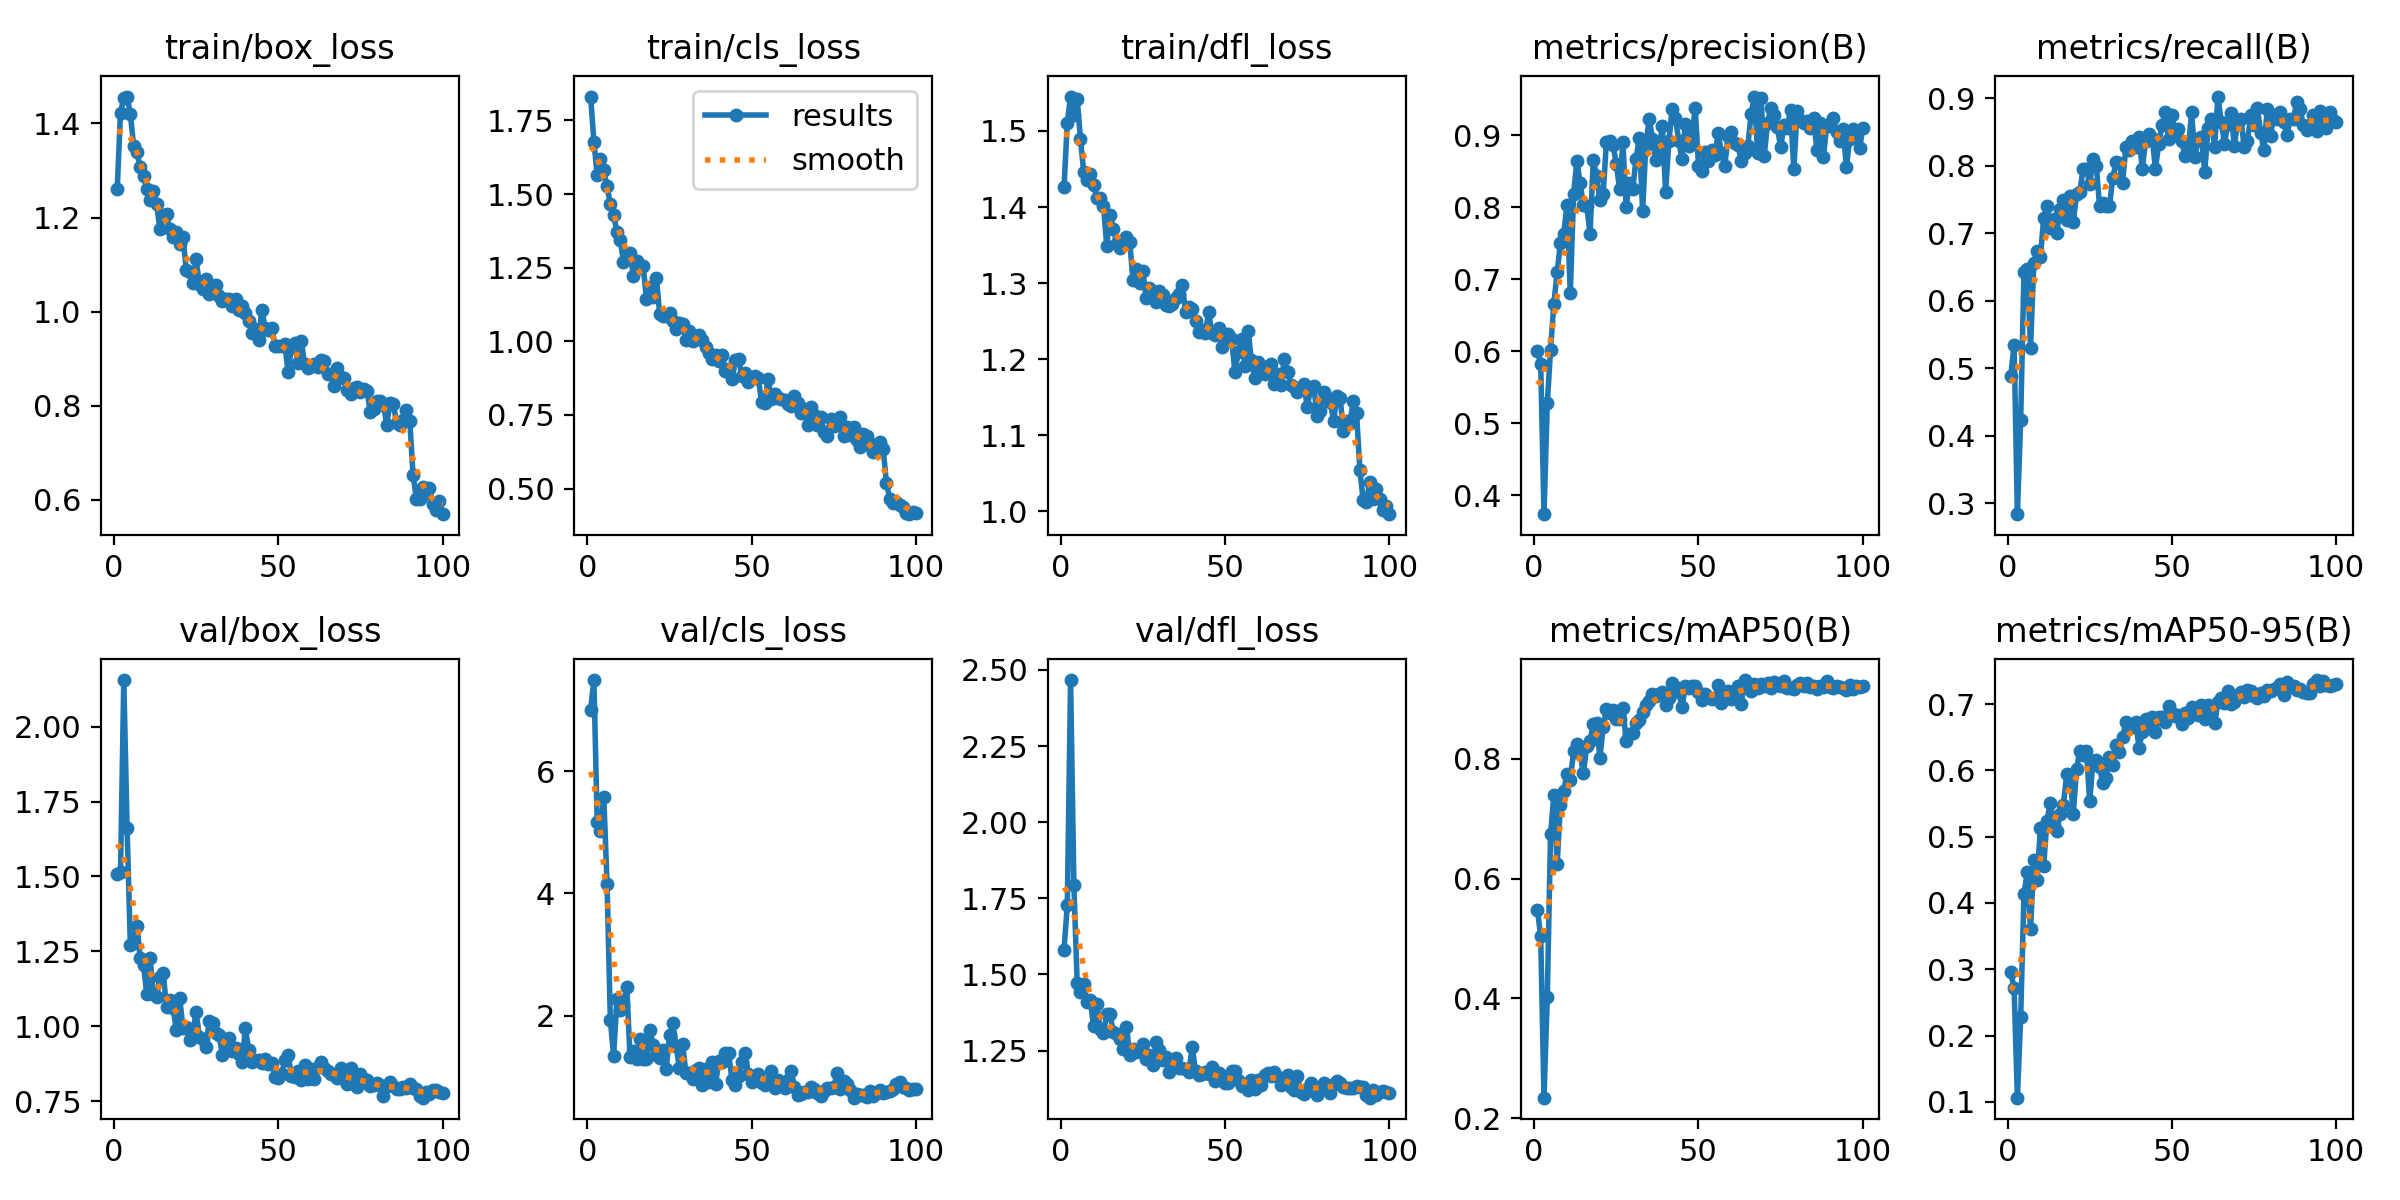

In [ ]:
from IPython.display import Image, clear_output
%cd /content/runs/detect/train2
Image(filename=f'/content/runs/detect/train/results.png', width=600)

[Errno 2] No such file or directory: '/content/runs/detect/train2'
/content


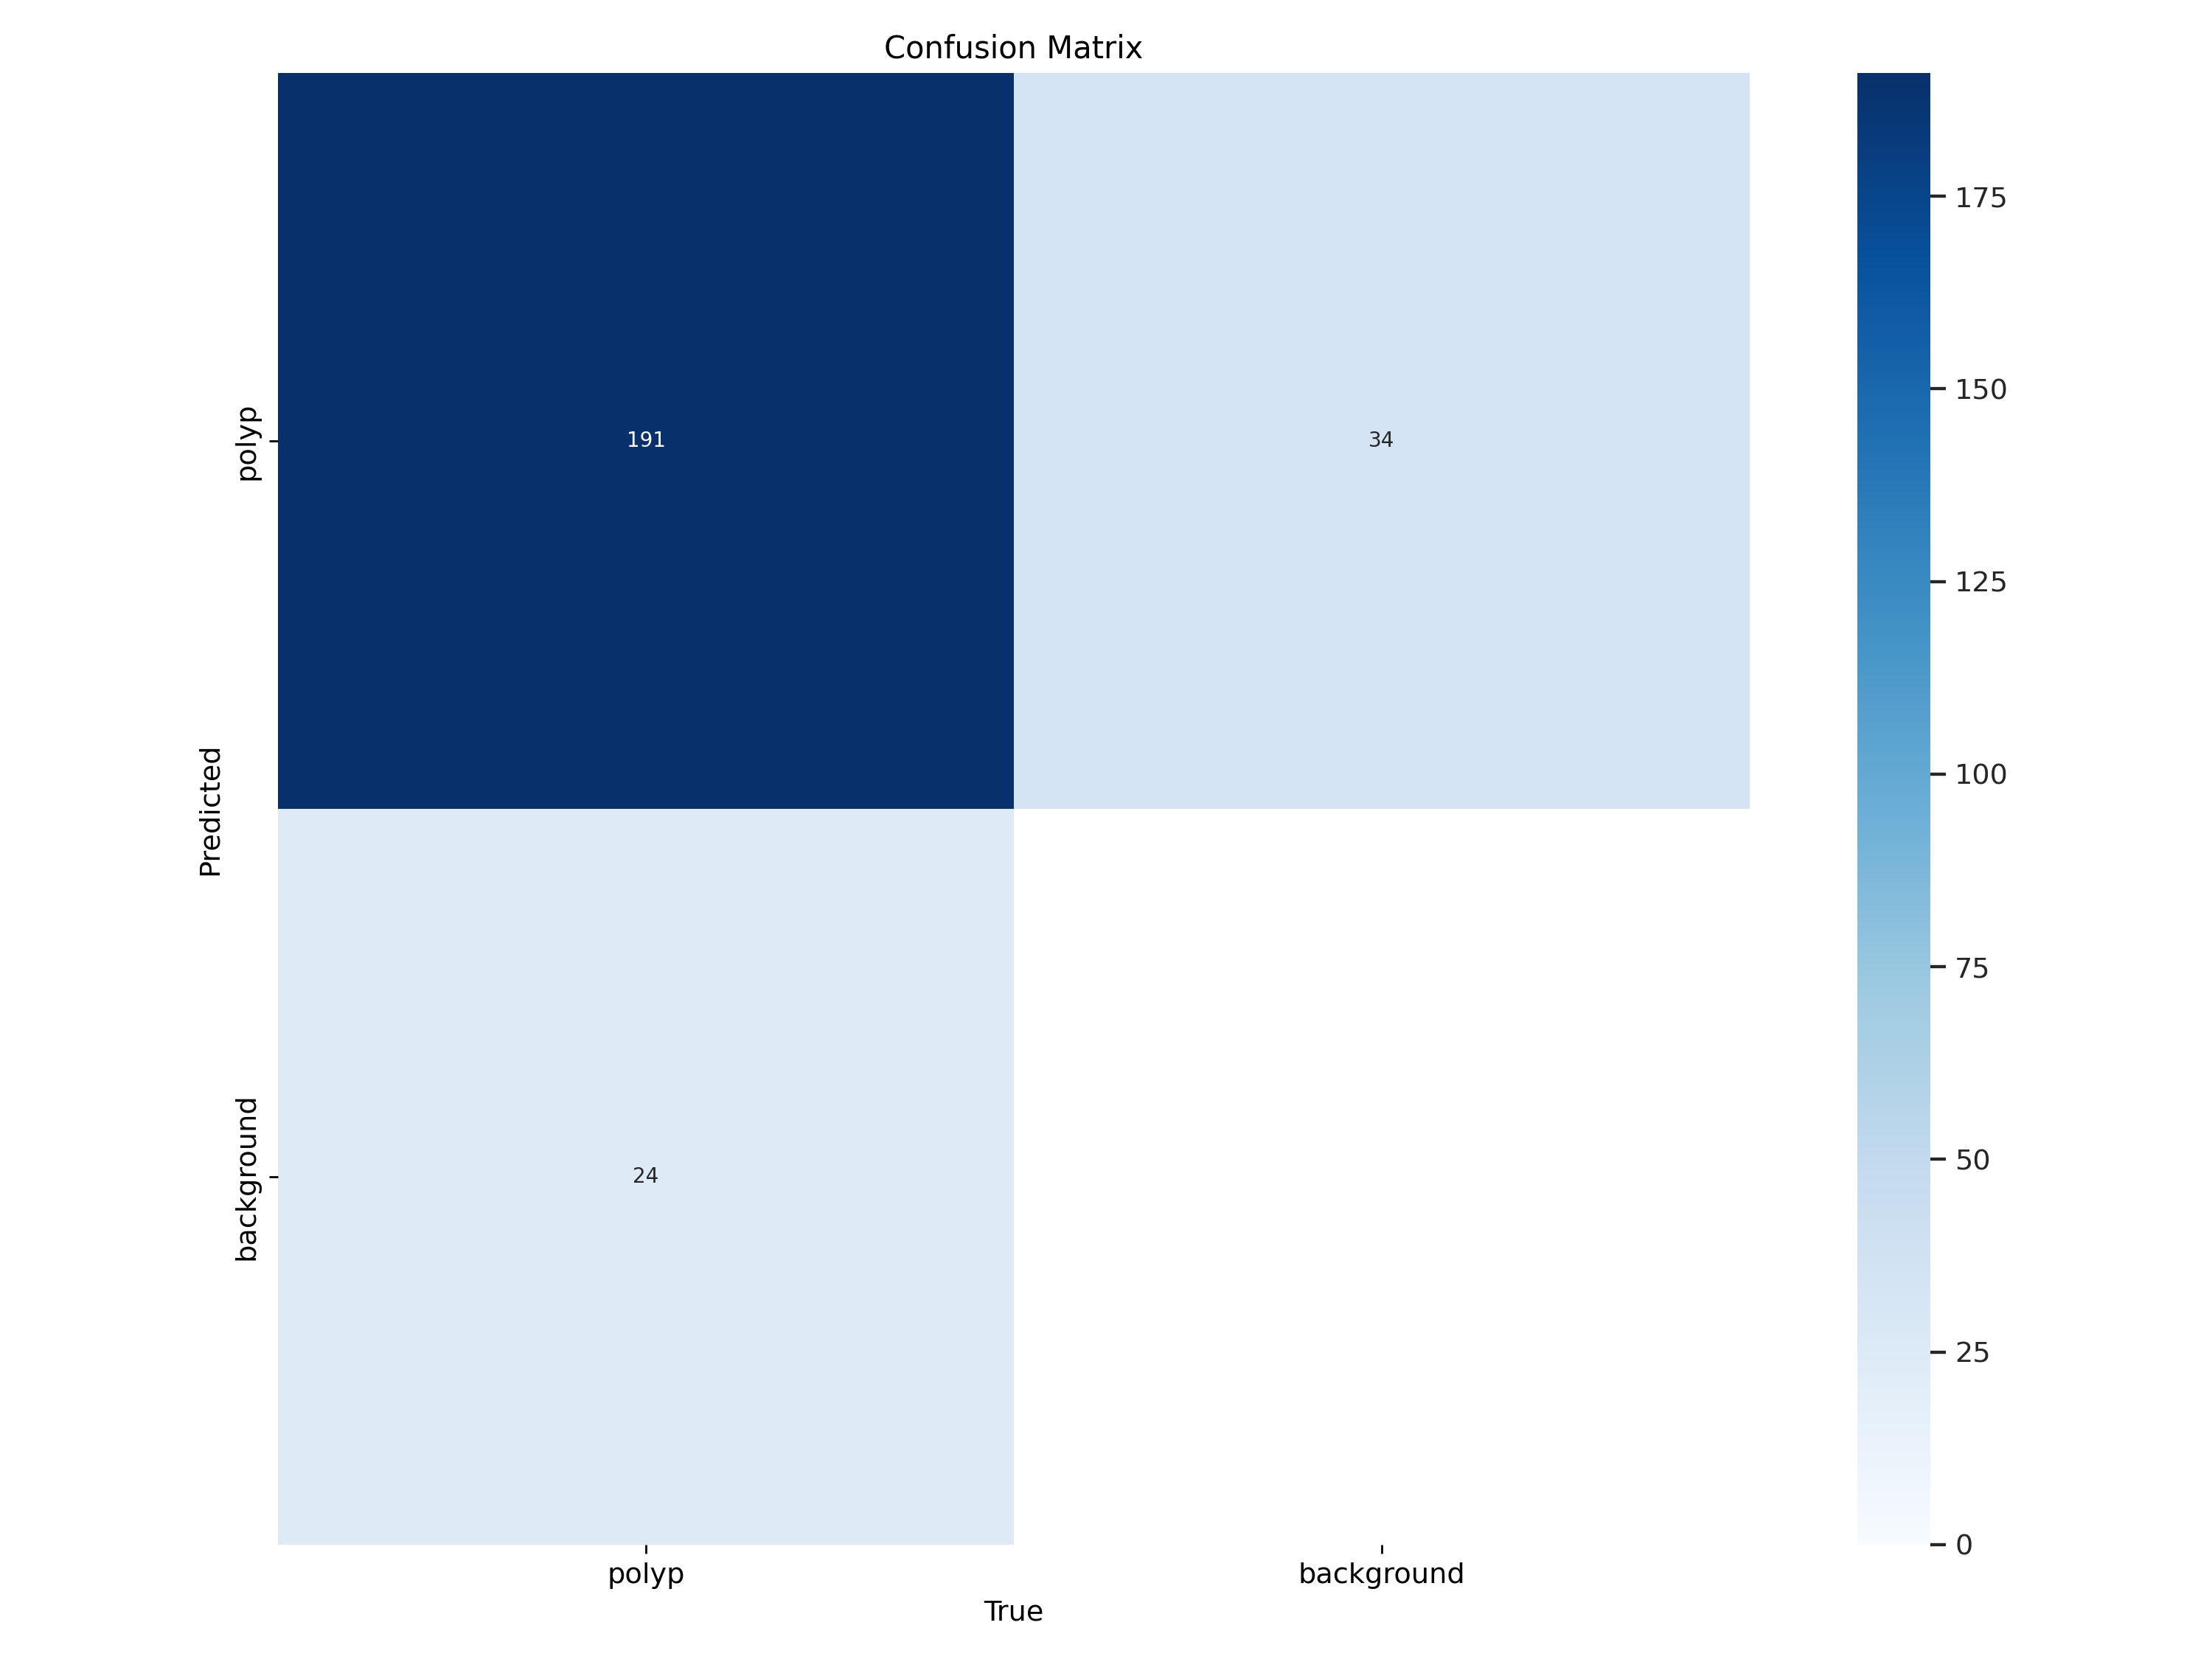

In [ ]:
%cd /content/runs/detect/train2
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

/content/runs/detect/train


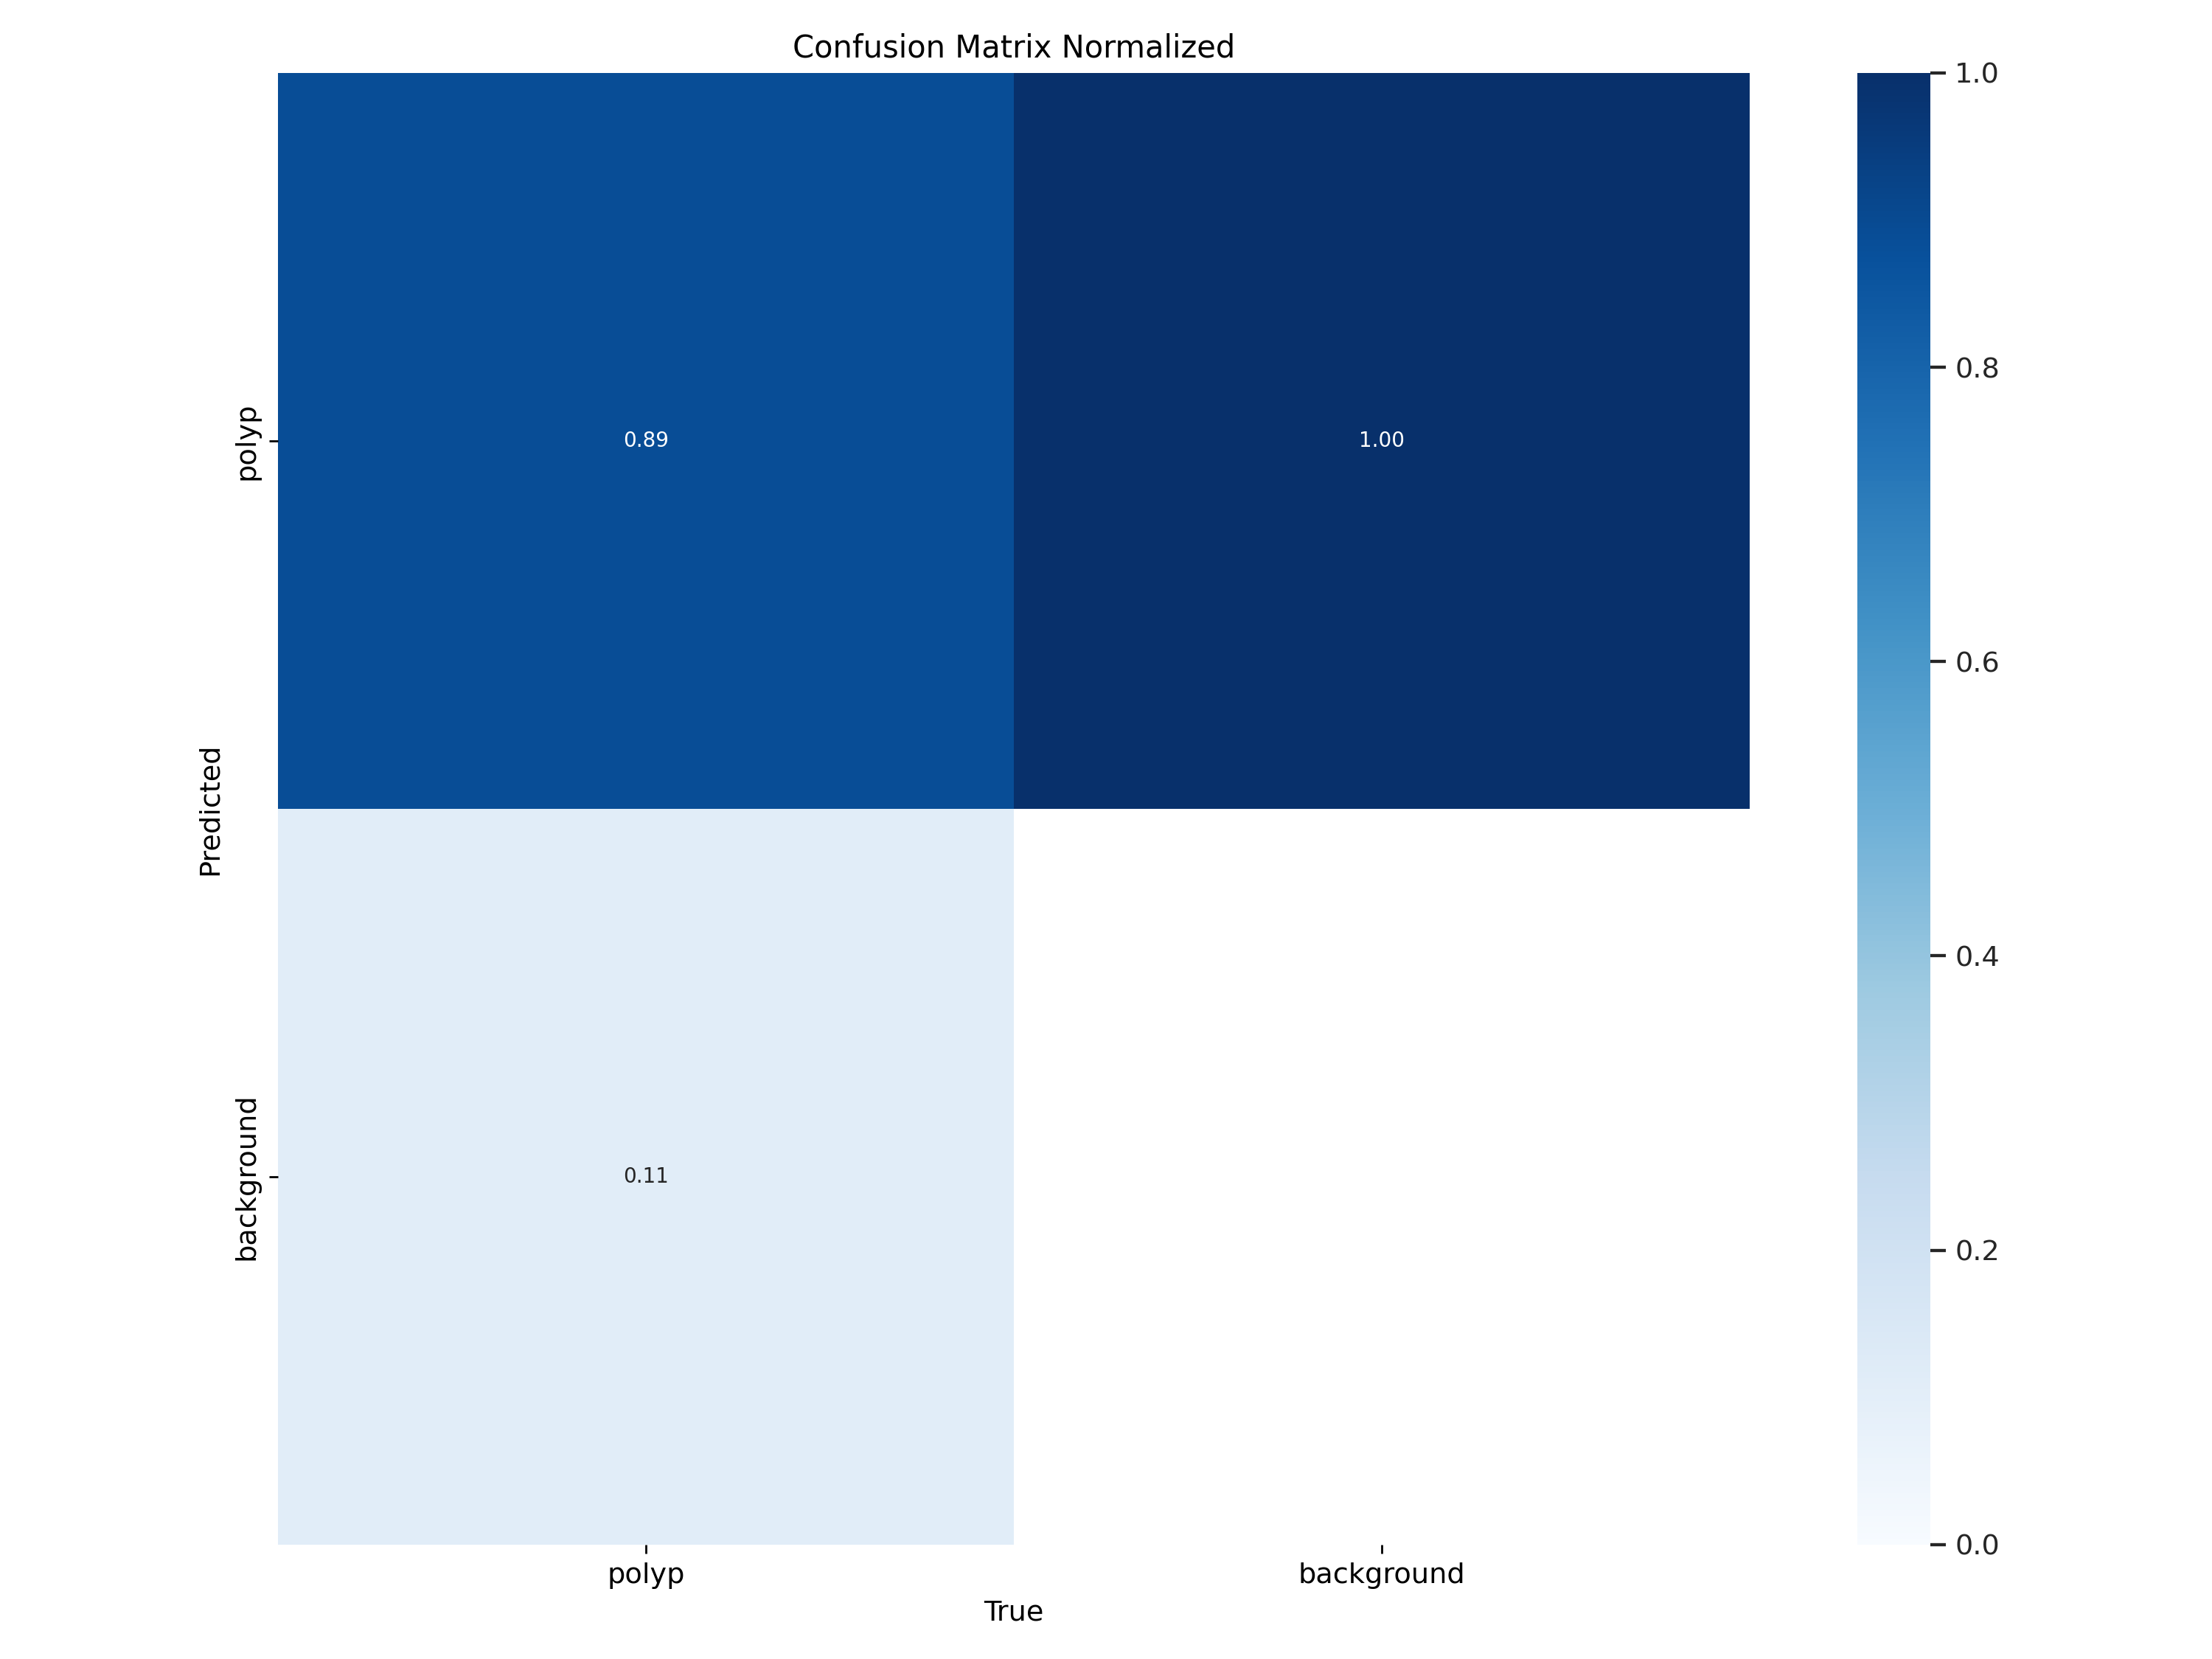

In [ ]:
%cd /content/runs/detect/train
Image(filename=f'/content/runs/detect/train/confusion_matrix_normalized.png', width=600)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/dataset5.yaml project=/content/runs/detect name=val   conf=0.5 iou=0.5

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 960.1±270.9 MB/s, size: 22.8 KB)
val: Scanning /content/dataset_split_HR_kvrs_1gt_rem/labels/val.cache... 213 images, 23 backgrounds, 0 corrupt: 100% 236/236 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 15/15 [00:01<00:00,  8.40it/s]
                   all        236        215      0.926      0.819      0.891      0.761
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


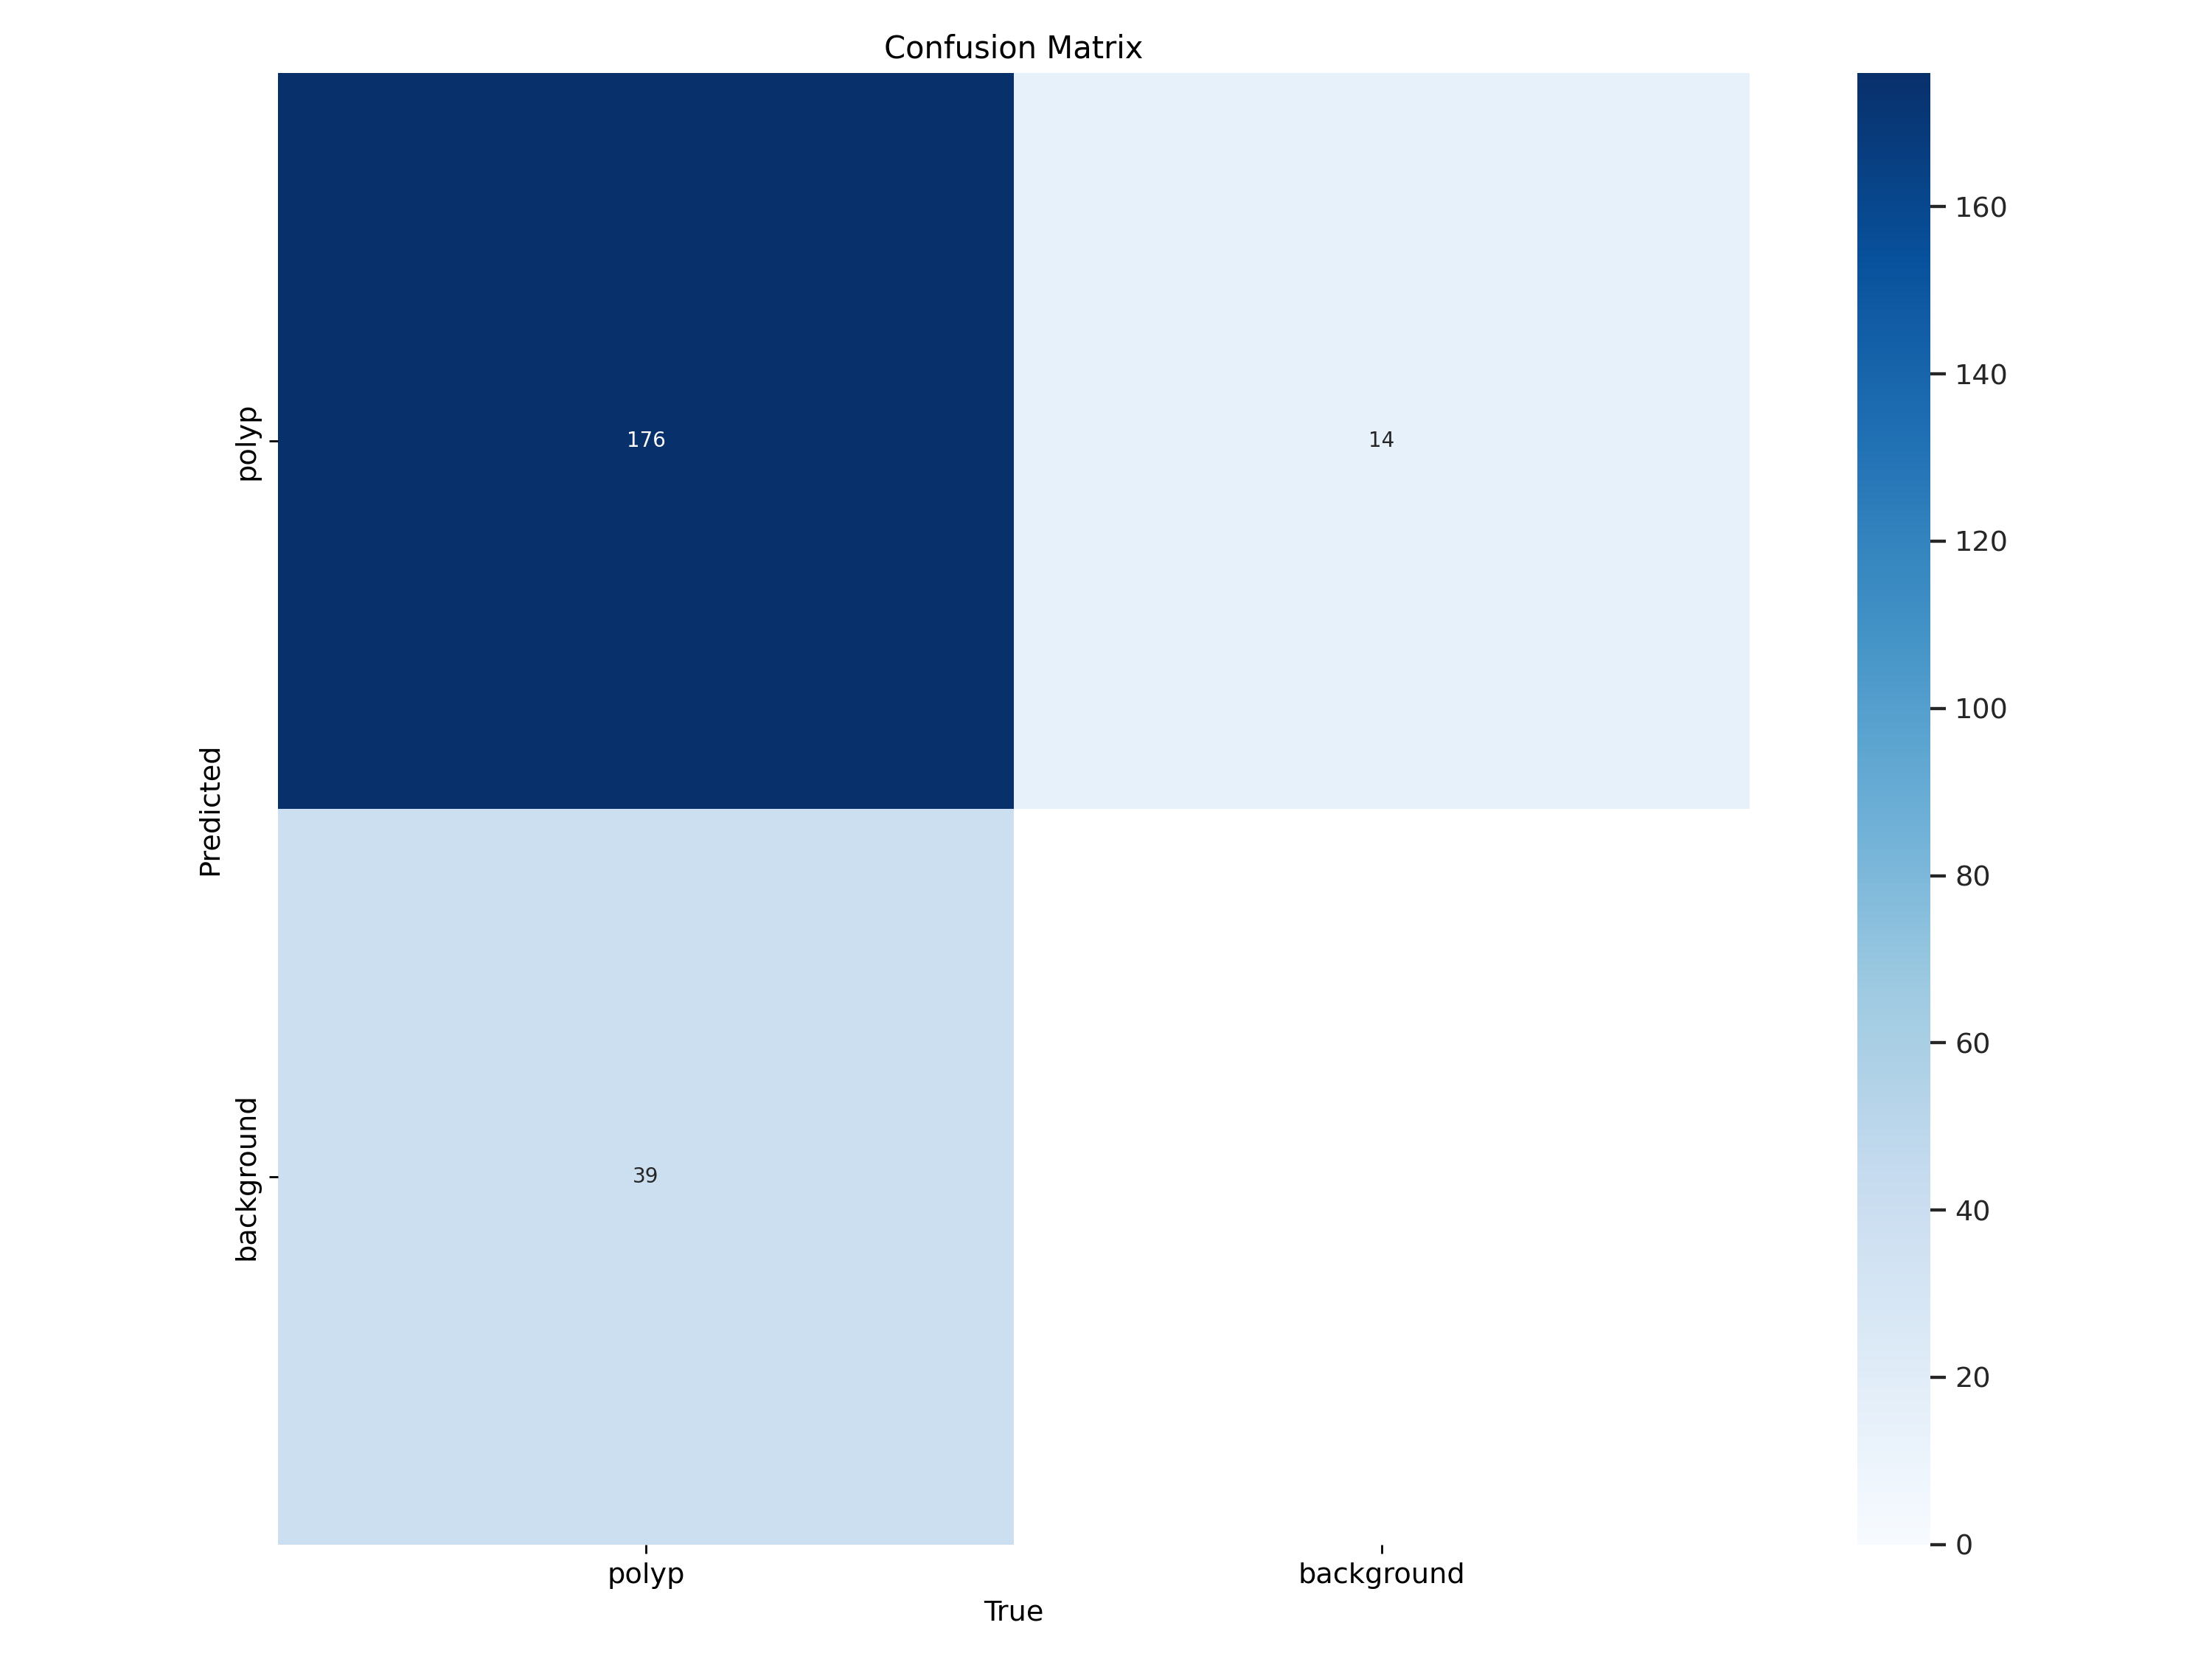

In [ ]:
Image(filename=f'/content/runs/detect/val/confusion_matrix.png', width=600)

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.5 iou=0.5 source=/content/dataset_split_HR_kvrs_1gt_rem/images/test project=/content/runs/detect name=predict save=True save_txt=True save_conf=True

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/121 /content/dataset_split_HR_kvrs_1gt_rem/images/test/1_polyp-1-_202301260065C006.jpg: 256x256 1 polyp, 17.6ms
image 2/121 /content/dataset_split_HR_kvrs_1gt_rem/images/test/1_polyp-2-_202401220684C003.jpg: 256x256 (no detections), 15.4ms
image 3/121 /content/dataset_split_HR_kvrs_1gt_rem/images/test/202303210154C022.jpg: 256x256 (no detections), 10.7ms
image 4/121 /content/dataset_split_HR_kvrs_1gt_rem/images/test/202305290249C031.jpg: 256x256 (no detections), 14.4ms
image 5/121 /content/dataset_split_HR_kvrs_1gt_rem/images/test/202309190441C039.jpg: 256x256 (no detections), 11.9ms
image 6/121 /content/dataset_split_HR_kvrs_1gt_rem/images/test/202309260456C030.jpg: 256x256 (no detections), 9.7ms
image 7/121 /content/dataset_split_HR_kvrs_1gt_rem/images/test/202312150626C017.jpg: 256x256 (no detections), 14.1ms


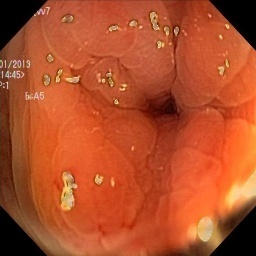

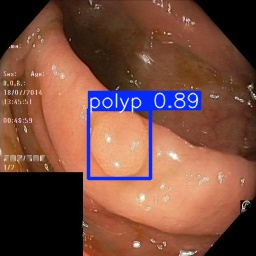

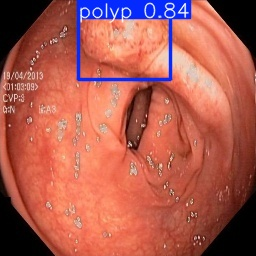

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'/content/runs/detect/predict'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=300))
    print("\n")

####test

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from collections import defaultdict

def compute_iou(box1, box2):
    """Menghitung IoU antara dua bounding box: [x_center, y_center, w, h]"""
    def to_corners(box):
        x, y, w, h = box
        return [x - w/2, y - h/2, x + w/2, y + h/2]

    box1 = to_corners(box1)
    box2 = to_corners(box2)

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append((cls, bbox))
    return labels

def evaluate(pred_dir, gt_dir, iou_threshold=0.5):
    predictions = []
    for pred_file in glob.glob(f"{pred_dir}/*.txt"):
        filename = os.path.basename(pred_file)
        image_id = filename.replace('.txt', '')
        gt_file = os.path.join(gt_dir, filename)

        pred_labels = []
        with open(pred_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                bbox = list(map(float, parts[1:5]))
                conf = float(parts[5]) if len(parts) > 5 else 1.0  # asumsikan confidence = 1.0 jika tidak tersedia
                pred_labels.append((image_id, cls, conf, bbox))
        predictions.extend(pred_labels)

    predictions.sort(key=lambda x: x[2], reverse=True)  # sort by confidence
    class_gt_counts = defaultdict(int)
    gt_boxes = defaultdict(list)

    for gt_file in glob.glob(f"{gt_dir}/*.txt"):
        image_id = os.path.basename(gt_file).replace('.txt', '')
        for cls, bbox in load_labels(gt_file):
            gt_boxes[(image_id, cls)].append({'bbox': bbox, 'used': False})
            class_gt_counts[cls] += 1

    stats = []
    acc_tp = 0
    acc_fp = 0

    for image_id, cls, conf, pred_box in predictions:
        matched = False
        candidates = gt_boxes.get((image_id, cls), [])
        for gt in candidates:
            if not gt['used']:
                iou = compute_iou(pred_box, gt['bbox'])
                if iou >= iou_threshold:
                    gt['used'] = True
                    matched = True
                    break

        tp = 1 if matched else 0
        fp = 0 if matched else 1

        acc_tp += tp
        acc_fp += fp

        precision = acc_tp / (acc_tp + acc_fp) if (acc_tp + acc_fp) > 0 else 0
        recall = acc_tp / sum(class_gt_counts.values()) if sum(class_gt_counts.values()) > 0 else 0

        stats.append([image_id, cls, conf, tp, fp, acc_tp, acc_fp, precision, recall])

    df = pd.DataFrame(stats, columns=["Image", "Class", "Confidence", "TP", "FP", "Acc TP", "Acc FP", "Precision", "Recall"])
    return df

# Contoh pemanggilan:
pred_dir = '/content/runs/detect/predict/labels'
gt_dir = '/content/dataset_split_HR_kvrs_1gt_rem/labels/test'
df_metrics = evaluate(pred_dir, gt_dir)
df_metrics.to_csv("/content/detection_metrics_HR_1gt_rem.csv", index=False)


Total Ground Truth: 109
Final Precision: 0.9158
Final Recall: 0.7982
Final F1-Score: 0.8529


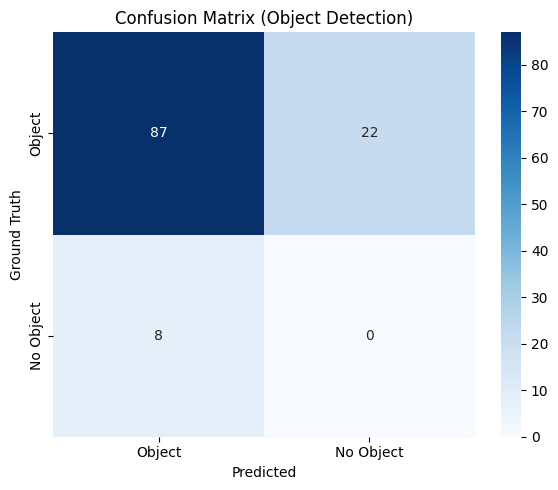

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def count_total_groundtruth(gt_dir):
    """
    Menghitung total jumlah bounding box (ground truth) dari folder label YOLO.

    Args:
        gt_dir (str): Path ke folder label ground truth (YOLO format)

    Returns:
        int: Total jumlah ground truth bounding box
    """
    total_gt = 0
    for file_name in os.listdir(gt_dir):
        if file_name.endswith('.txt'):
            file_path = os.path.join(gt_dir, file_name)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_gt += len(lines)
    return total_gt
gt_dir = '/content/dataset_split_HR_kvrs_1gt_rem/labels/test'
total_gt = count_total_groundtruth(gt_dir)
print(f"Total Ground Truth: {total_gt}")

def compute_final_metrics(df: pd.DataFrame, total_gt: int):
    """
    Menghitung TP, FP, FN, Precision, Recall, dan F1-score dari DataFrame hasil evaluasi.

    Args:
        df (pd.DataFrame): DataFrame berisi kolom ['TP', 'FP'] untuk masing-masing prediksi
        total_gt (int): Jumlah total ground truth (box sebenarnya)

    Returns:
        dict: Confusion matrix dan metrik evaluasi
    """
    tp = df['TP'].sum()
    fp = df['FP'].sum()
    fn = total_gt - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }
# Misalnya 'eval_df' adalah DataFrame berisi kolom ['TP', 'FP']
final_result = compute_final_metrics(df_metrics, total_gt)

print(f"Final Precision: {final_result['Precision']}")
print(f"Final Recall: {final_result['Recall']}")
print(f"Final F1-Score: {final_result['F1 Score']}")

tp = final_result['True Positive (TP)']
fp = final_result['False Positive (FP)']
fn = final_result['False Negative (FN)']
tn = 0  # TN tidak dihitung dalam object detection
# Plot confusion matrix
conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

labels = ['Object', 'No Object']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix (Object Detection)')
plt.tight_layout()
plt.show()

#download

In [ ]:
import shutil
from google.colab import files

# Path folder yang mau di-zip
folder_path = '/content/dataset_split_asli_kvrs_1gt_rem'
# Path untuk output zip (di luar folder target)
output_zip = '/content/dataset_split_asli_kvrs_1gt_rem'

# Buat ZIP
shutil.make_archive(output_zip, 'zip', folder_path)

# Download
files.download(output_zip + '.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Simpan model ke lokasi baru
model2.save("/content/YOLO_asli_1gt_rem.pt")

In [ ]:
import shutil
from google.colab import files

# Path folder yang mau di-zip
folder_path = '/content/runs/detect/predict'

# Path untuk output zip (di luar folder target)
output_zip = '/content/predict_asli_1gt_rem'

# Buat ZIP
shutil.make_archive(output_zip, 'zip', folder_path)

# Download
files.download(output_zip + '.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Perbandingan

✅ Unzipped: Asli
✅ Unzipped: AGC-HR
✅ Unzipped: HR-AGC
✅ Unzipped: AGC
✅ Unzipped: HR

📊 Total Ground Truth per Skenario:
Asli: 108
AGC-HR: 108
HR-AGC: 108
AGC: 109
HR: 109


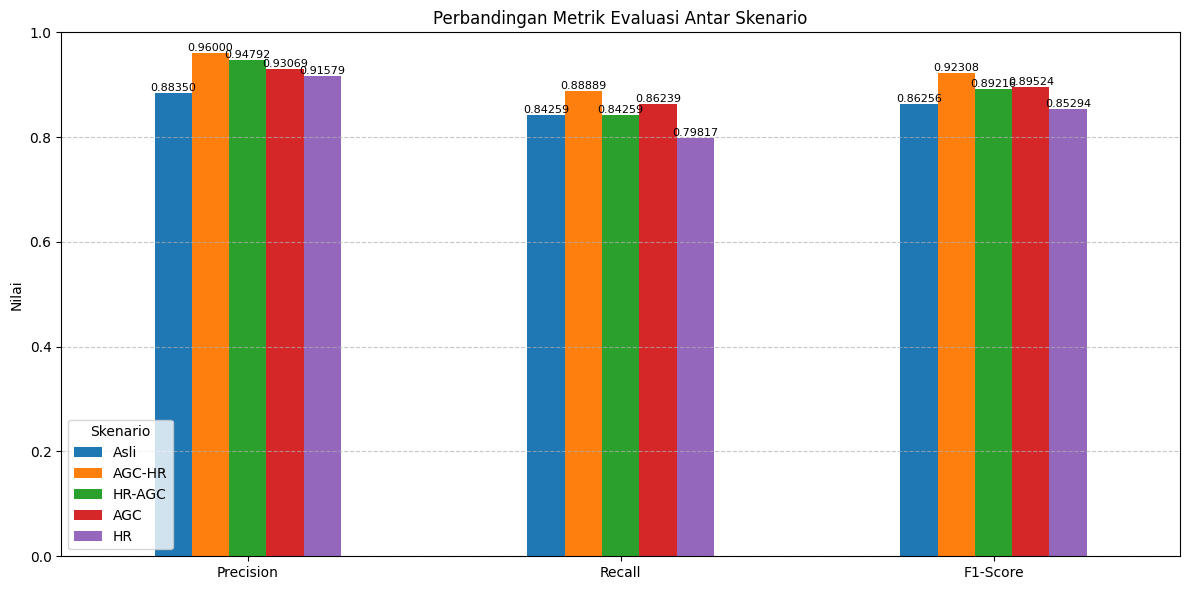

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

# Path ke file CSV dari lima skenario
csv_paths = {
    "Asli": "/content/detection_metrics_asli_1gt_rem_fix.csv",
    "AGC-HR": "/content/detection_metrics_AGC_HR_1gt_rem.csv",
    "HR-AGC": "/content/detection_metrics_HR_AGC_1gt_rem.csv",
    "AGC": "/content/detection_metrics_AGC_1gt_rem.csv",
    "HR": "/content/detection_metrics_HR_1gt_rem.csv"
}

metrics = {}

def unzip_dataset(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def count_total_groundtruth(gt_dir):
    total_gt = 0
    for file_name in os.listdir(gt_dir):
        if file_name.endswith('.txt'):
            file_path = os.path.join(gt_dir, file_name)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_gt += len(lines)
    return total_gt

dataset_info = {
    "Asli": "/content/dataset_split_asli_kvrs_1gt_rem_fix.zip",
    "AGC-HR": "/content/dataset_split_AGC_HR_kvrs_1gt_rem.zip",
    "HR-AGC": "/content/dataset_split_HR_AGC_kvrs_1gt_rem.zip",
    "AGC": "/content/dataset_split_AGC_kvrs_1gt_rem.zip",
    "HR": "/content/dataset_split_HR_kvrs_1gt_rem.zip"
}
total_gt_dict = {}

for label, zip_path in dataset_info.items():
    extract_path = zip_path.replace(".zip", "")
    if not os.path.exists(extract_path):
        unzip_dataset(zip_path, extract_path)
        print(f"✅ Unzipped: {label}")
    else:
        print(f"📂 Sudah ada: {label}")

    gt_path = os.path.join(extract_path, "labels", "test")
    total_gt = count_total_groundtruth(gt_path)
    total_gt_dict[label] = total_gt

print("\n📊 Total Ground Truth per Skenario:")
for label, gt in total_gt_dict.items():
    print(f"{label}: {gt}")

for label, path in csv_paths.items():
    df = pd.read_csv(path)
    last_row = df.iloc[-1]

    precision = last_row["Precision"]
    recall = last_row["Recall"]
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    tp = last_row["Acc TP"]
    fp = last_row["Acc FP"]

    metrics[label] = {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }
# Buat DataFrame dari hasil
metrics_df = pd.DataFrame(metrics)

# Plot
ax = metrics_df.plot(kind="bar", figsize=(12, 6), rot=0)
plt.title("Perbandingan Metrik Evaluasi Antar Skenario")
plt.ylabel("Nilai")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Skenario")
# Tambahkan label angka per batang
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.5f}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
